In [1]:
#%matplotlib notebook
%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




Modules loaded
Reload complete
GPUs available: 1


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
%%javascript
Jupyter.keyboard_manager.disable();
//System.out.println("disabled");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('j');
//System.out.println("remove j");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('k');
//System.out.println("remove k");

Total number of training images = 2379


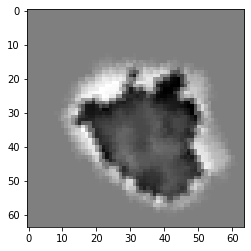

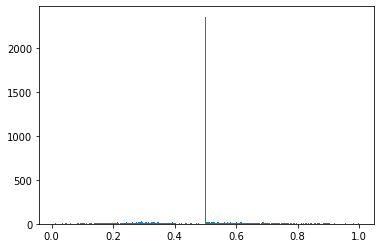

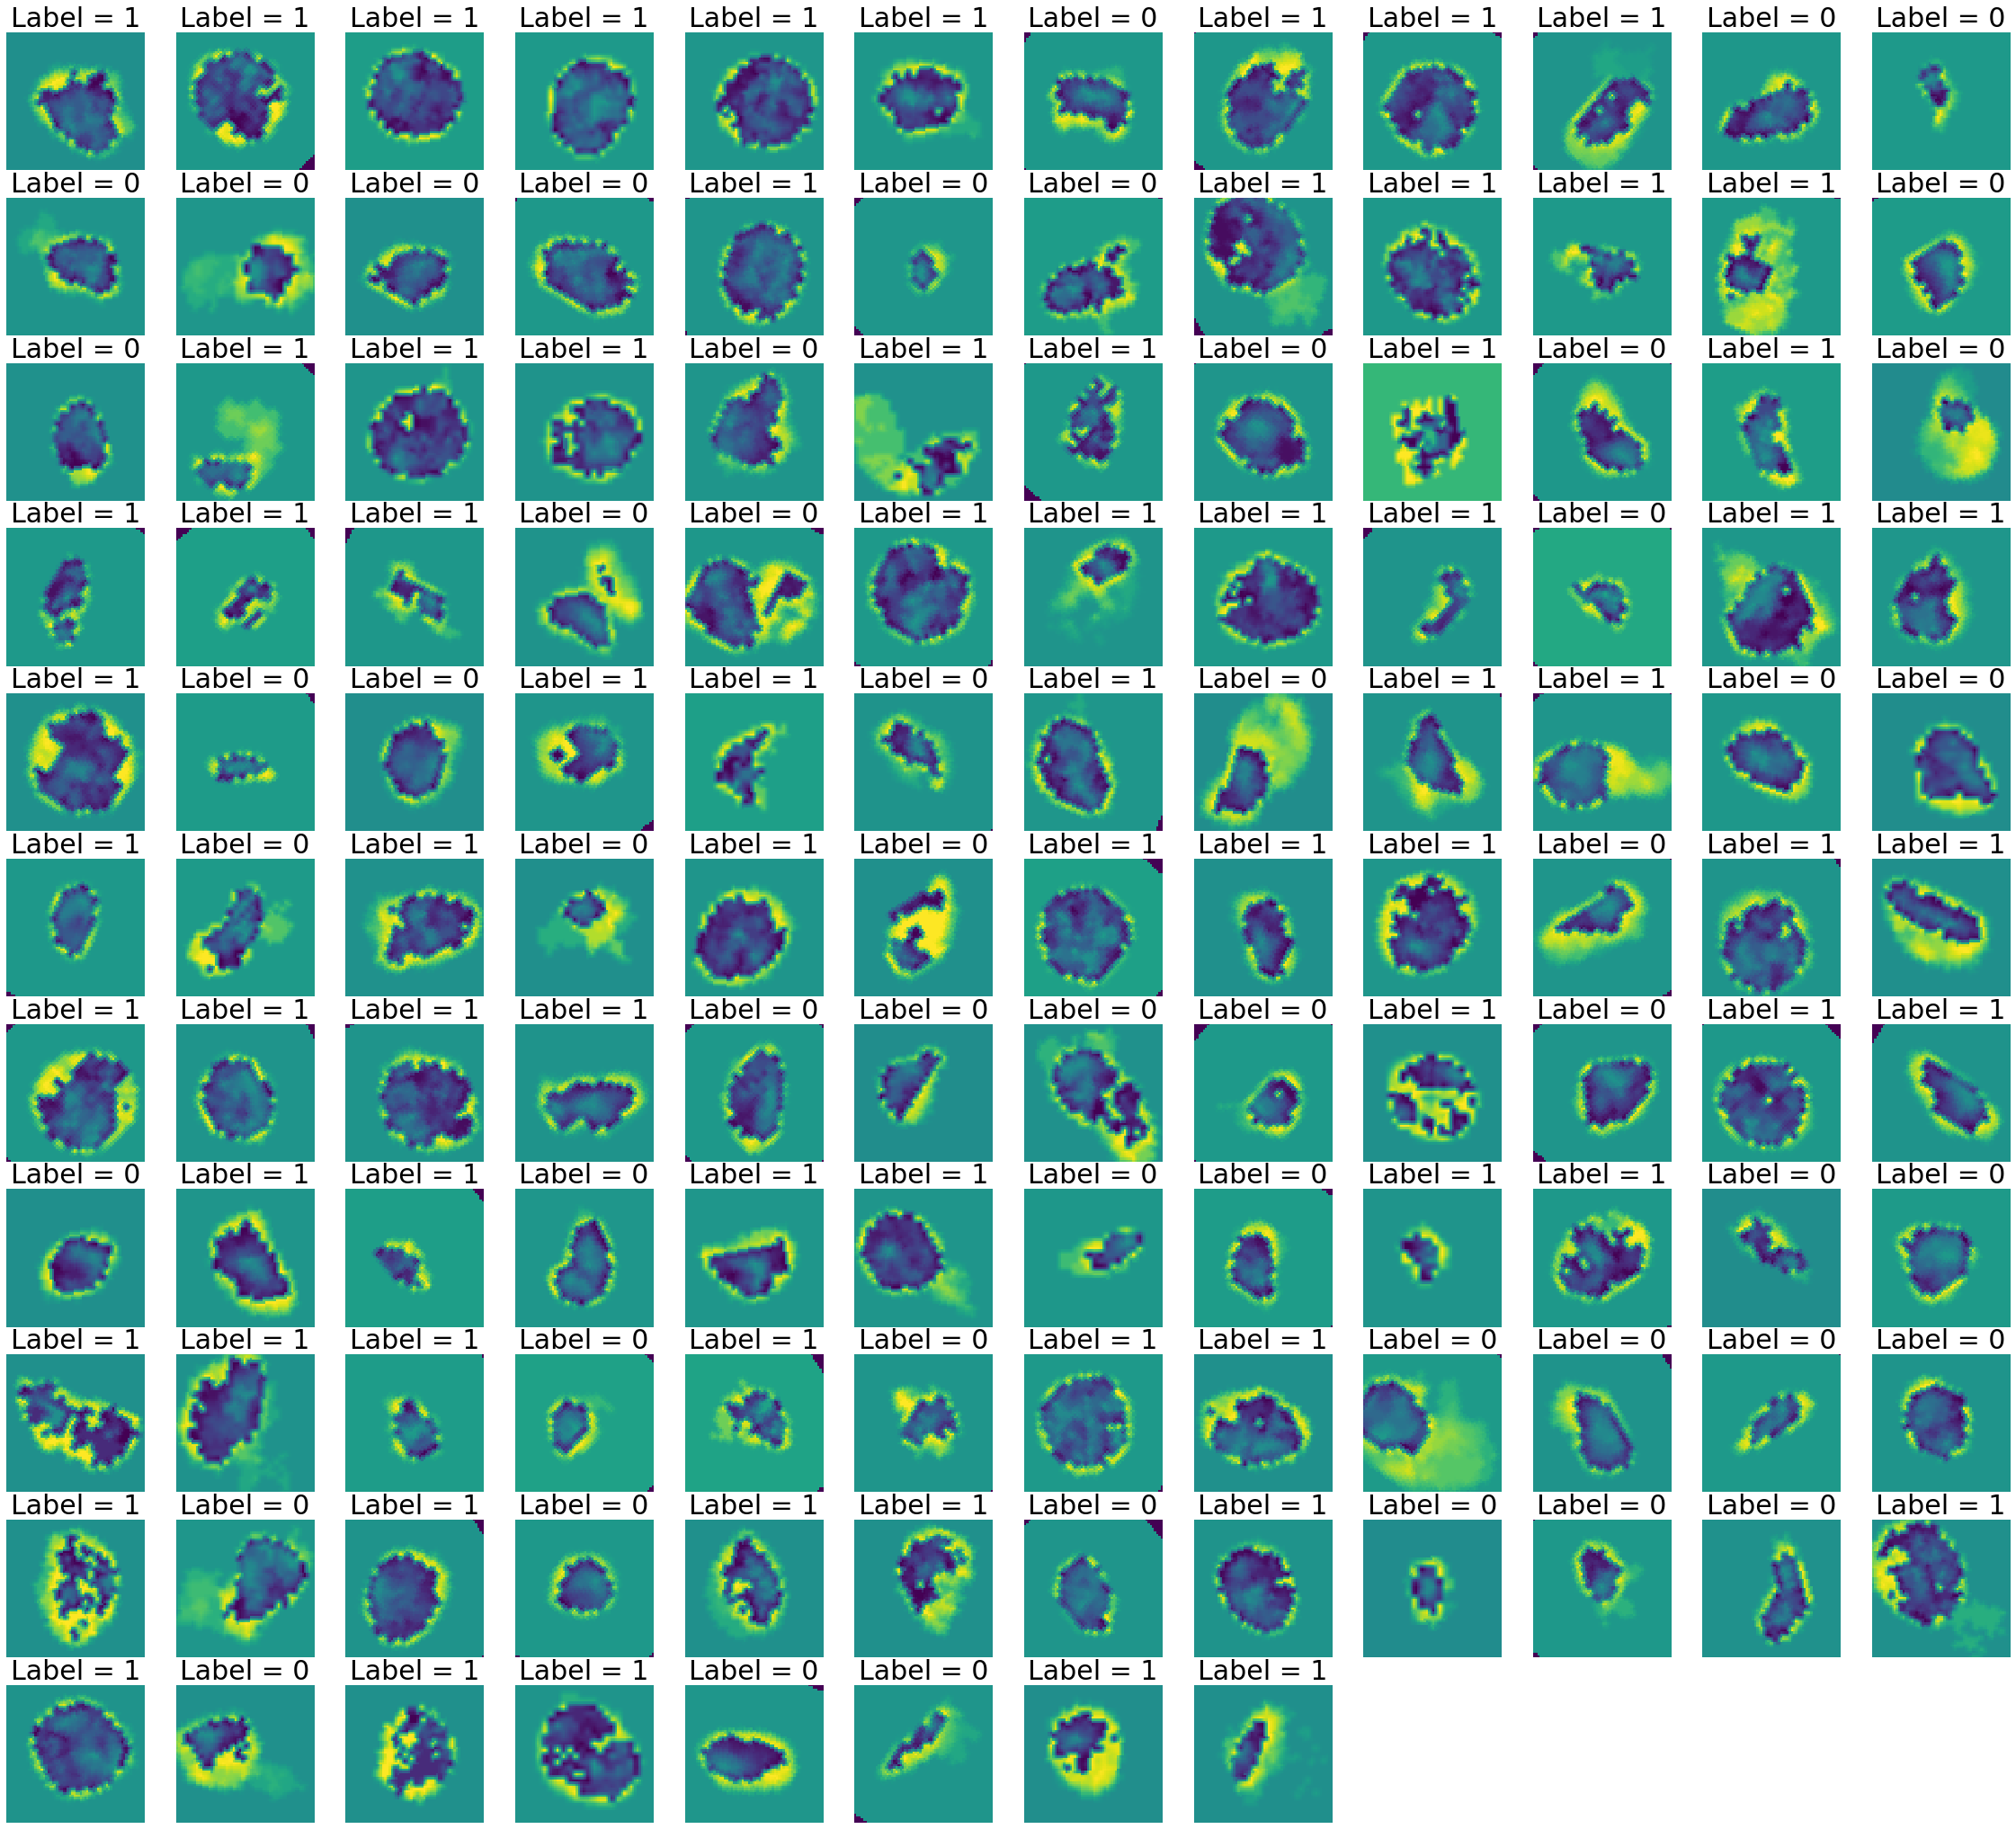

In [4]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

In [8]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    #torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [9]:
config_file = '../configs/config_hdf5_2d.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [10]:
# Train the network
main(config, None)

Total number of training images = 2379
heatmapModel64(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Conv2d(256, 512, k

/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
    epoch          : 1
    loss           : 1.539772916585207
    my_metric      : 0.5672263728762136
    f1             : 0.525977580192696
    balanced_accuracy: 0.583565356137237
    precision      : 0.6803099274185055
    recall         : 0.5672263728762136
    val_loss       : 0.6998770236968994
    val_my_metric  : 0.47020833333333334
    val_f1         : 0.4517132934849955
    val_balanced_accuracy: 0.6122024590763057
    val_precision  : 0.7555268274632114
    val

Model has not improved in -------------| 1 epochs


    epoch          : 4
    loss           : 0.6093647927045822
    my_metric      : 0.6362257281553398
    f1             : 0.6446224083483836
    balanced_accuracy: 0.6562278908554
    precision      : 0.702635891216315
    recall         : 0.6362257281553398
    val_loss       : 0.5677528182665507
    val_my_metric  : 0.6360416666666667
    val_f1         : 0.6521631563047056
    val_balanced_accuracy: 0.6973571922638137
    val_precision  : 0.7640695594083015
    val_recall     : 0.6360416666666667
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch4.pth ...
Saving current best: model_best.pth ...
    epoch          : 5
    loss           : 0.6025925986468792
    my_metric      : 0.6595447132888349
    f1             : 0.666289562132207
    balanced_accuracy: 0.6800365762044582
    precision      : 0.7334578772912785
    recall         : 0.6595447132888349
    val_loss       : 0.5948950250943502
    val_my_metric  : 0.6065625
    val_f1         : 0.61834

Model has not improved in -------------| 1 epochs


    epoch          : 6
    loss           : 0.5971034020185471
    my_metric      : 0.6450290124393204
    f1             : 0.6502125258950359
    balanced_accuracy: 0.6799780345749311
    precision      : 0.7359445900594277
    recall         : 0.6450290124393204
    val_loss       : 0.618124763170878
    val_my_metric  : 0.5541666666666667
    val_f1         : 0.5559766987791182
    val_balanced_accuracy: 0.6732396562591599
    val_precision  : 0.7921652631995166
    val_recall     : 0.5541666666666667


Model has not improved in -------------| 2 epochs


    epoch          : 7
    loss           : 0.5777959376573563
    my_metric      : 0.6533297936893204
    f1             : 0.6613507686551666
    balanced_accuracy: 0.6892425335868404
    precision      : 0.7398774232343114
    recall         : 0.6533297936893204
    val_loss       : 0.5715882778167725
    val_my_metric  : 0.6136458333333333
    val_f1         : 0.6262742681889368
    val_balanced_accuracy: 0.7028745180919094
    val_precision  : 0.7869076056376353
    val_recall     : 0.6136458333333333


Model has not improved in -------------| 3 epochs


    epoch          : 8
    loss           : 0.5760989375412464
    my_metric      : 0.6614077669902912
    f1             : 0.6703948899030058
    balanced_accuracy: 0.6929700565419594
    precision      : 0.7366577869587764
    recall         : 0.6614077669902912
    val_loss       : 0.5937309662501017
    val_my_metric  : 0.5947916666666667
    val_f1         : 0.6043663424602506
    val_balanced_accuracy: 0.6977087380605472
    val_precision  : 0.7946857078455202
    val_recall     : 0.5947916666666667


Model has not improved in -------------| 4 epochs


    epoch          : 9
    loss           : 0.5714133568108082
    my_metric      : 0.6599287014563107
    f1             : 0.6669719466985793
    balanced_accuracy: 0.6883782763456742
    precision      : 0.7338092304086626
    recall         : 0.6599287014563107
    val_loss       : 0.5648946960767111
    val_my_metric  : 0.6515624999999999
    val_f1         : 0.6660994744487883
    val_balanced_accuracy: 0.7217926885006113
    val_precision  : 0.7887164045737349
    val_recall     : 0.6515624999999999
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch9.pth ...
Saving current best: model_best.pth ...
    epoch          : 10
    loss           : 0.5604823213070631
    my_metric      : 0.6762647906553398
    f1             : 0.6853632005751362
    balanced_accuracy: 0.7110563378508075
    precision      : 0.753773298467243
    recall         : 0.6762647906553398
    val_loss       : 0.5544214447339376
    val_my_metric  : 0.6842708333333333
    val_f1    

Model has not improved in -------------| 1 epochs


    epoch          : 12
    loss           : 0.5665780566632748
    my_metric      : 0.6805265852548543
    f1             : 0.6884651220358542
    balanced_accuracy: 0.6980644937029156
    precision      : 0.737742718703458
    recall         : 0.6805265852548543
    val_loss       : 0.5593122641245524
    val_my_metric  : 0.6994791666666668
    val_f1         : 0.7127868673860482
    val_balanced_accuracy: 0.690250135445725
    val_precision  : 0.7463527676027676
    val_recall     : 0.6994791666666668


Model has not improved in -------------| 2 epochs


    epoch          : 13
    loss           : 0.5589795988053083
    my_metric      : 0.6801425970873787
    f1             : 0.6873617802716644
    balanced_accuracy: 0.7115622355940298
    precision      : 0.7538812408231208
    recall         : 0.6801425970873787
    val_loss       : 0.5500984390576681
    val_my_metric  : 0.669375
    val_f1         : 0.6858194543683988
    val_balanced_accuracy: 0.7003359468247109
    val_precision  : 0.7552974843783667
    val_recall     : 0.669375
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch13.pth ...
Saving current best: model_best.pth ...
    epoch          : 14
    loss           : 0.5485847257077694
    my_metric      : 0.6934731492718447
    f1             : 0.7026265647908019
    balanced_accuracy: 0.7187967407011888
    precision      : 0.7531756676714455
    recall         : 0.6934731492718447
    val_loss       : 0.5530307491620382
    val_my_metric  : 0.6998958333333333
    val_f1         : 0.71378232

Model has not improved in -------------| 1 epochs


    epoch          : 15
    loss           : 0.557707641273737
    my_metric      : 0.6929848680218447
    f1             : 0.7016984735743326
    balanced_accuracy: 0.7143283518632165
    precision      : 0.7483652438840427
    recall         : 0.6929848680218447
    val_loss       : 0.5621373951435089
    val_my_metric  : 0.64
    val_f1         : 0.6554739706539677
    val_balanced_accuracy: 0.7041082751895109
    val_precision  : 0.7754155296245795
    val_recall     : 0.64


Model has not improved in -------------| 2 epochs


    epoch          : 16
    loss           : 0.5478381998836994
    my_metric      : 0.6943169751213593
    f1             : 0.7030980312240113
    balanced_accuracy: 0.7180939898045515
    precision      : 0.7543509625930245
    recall         : 0.6943169751213593
    val_loss       : 0.5299778580665588
    val_my_metric  : 0.6827083333333333
    val_f1         : 0.6980831521643925
    val_balanced_accuracy: 0.7189630088621114
    val_precision  : 0.7701445948904366
    val_recall     : 0.6827083333333333
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch16.pth ...
Saving current best: model_best.pth ...
    epoch          : 17
    loss           : 0.541854852810502
    my_metric      : 0.6864144038228155
    f1             : 0.6958339746196381
    balanced_accuracy: 0.7135205512951881
    precision      : 0.751076306818298
    recall         : 0.6864144038228155
    val_loss       : 0.5486686031023661
    val_my_metric  : 0.679375
    val_f1         : 0.

Model has not improved in -------------| 1 epochs


    epoch          : 18
    loss           : 0.5414742417633533
    my_metric      : 0.6974694705703883
    f1             : 0.7049289642848999
    balanced_accuracy: 0.7250150171616189
    precision      : 0.764699561508836
    recall         : 0.6974694705703883
    val_loss       : 0.5214000840981802
    val_my_metric  : 0.761875
    val_f1         : 0.7663664667260526
    val_balanced_accuracy: 0.7261991504067967
    val_precision  : 0.7734689555646135
    val_recall     : 0.761875
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch18.pth ...
Saving current best: model_best.pth ...
    epoch          : 19
    loss           : 0.5470727551728487
    my_metric      : 0.7039640852548543
    f1             : 0.7109547661399981
    balanced_accuracy: 0.7243771351487616
    precision      : 0.7611179405583962
    recall         : 0.7039640852548543
    val_loss       : 0.523060123125712
    val_my_metric  : 0.7608333333333333
    val_f1         : 0.7702044998

Model has not improved in -------------| 1 epochs


    epoch          : 20
    loss           : 0.5358709618449211
    my_metric      : 0.7109185376213593
    f1             : 0.7192411728560496
    balanced_accuracy: 0.74005249468008
    precision      : 0.7741990365421977
    recall         : 0.7109185376213593
    val_loss       : 0.5303168098131815
    val_my_metric  : 0.6883333333333334
    val_f1         : 0.7029502244437088
    val_balanced_accuracy: 0.7436530198802288
    val_precision  : 0.795987171869525
    val_recall     : 0.6883333333333334


Model has not improved in -------------| 2 epochs


    epoch          : 21
    loss           : 0.5273482296615839
    my_metric      : 0.7135827518203883
    f1             : 0.7224205338327455
    balanced_accuracy: 0.7413234238346758
    precision      : 0.7732217230995555
    recall         : 0.7135827518203883
    val_loss       : 0.5193043251832327
    val_my_metric  : 0.6938541666666667
    val_f1         : 0.7088208594840334
    val_balanced_accuracy: 0.71979485336773
    val_precision  : 0.7678962106566273
    val_recall     : 0.6938541666666667
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch21.pth ...
Saving current best: model_best.pth ...
    epoch          : 22
    loss           : 0.5264680776745081
    my_metric      : 0.7144834648058253
    f1             : 0.7229149703574418
    balanced_accuracy: 0.7341850682220943
    precision      : 0.7641962144772428
    recall         : 0.7144834648058253
    val_loss       : 0.58523561557134
    val_my_metric  : 0.6267708333333334
    val_f1     

Model has not improved in -------------| 1 epochs


    epoch          : 23
    loss           : 0.5296921972185373
    my_metric      : 0.7225329945388349
    f1             : 0.7294767946487201
    balanced_accuracy: 0.7413755750658766
    precision      : 0.7772789281049974
    recall         : 0.7225329945388349
    val_loss       : 0.5667583346366882
    val_my_metric  : 0.6603125
    val_f1         : 0.676418713257514
    val_balanced_accuracy: 0.7327022061779794
    val_precision  : 0.8073531581602357
    val_recall     : 0.6603125


Model has not improved in -------------| 2 epochs


    epoch          : 24
    loss           : 0.5323385186493397
    my_metric      : 0.7122648665048543
    f1             : 0.7201885642668898
    balanced_accuracy: 0.7391752680726836
    precision      : 0.7720210429106783
    recall         : 0.7122648665048543
    val_loss       : 0.5422599713007609
    val_my_metric  : 0.6708333333333334
    val_f1         : 0.6869859714503118
    val_balanced_accuracy: 0.7120909395794787
    val_precision  : 0.768799263276634
    val_recall     : 0.6708333333333334


Model has not improved in -------------| 3 epochs


    epoch          : 25
    loss           : 0.5188806913793087
    my_metric      : 0.7301985361043689
    f1             : 0.7379983732460224
    balanced_accuracy: 0.7423096000666674
    precision      : 0.7717123717374782
    recall         : 0.7301985361043689
    val_loss       : 0.5488324264685313
    val_my_metric  : 0.6731250000000001
    val_f1         : 0.689172454156421
    val_balanced_accuracy: 0.7292529274551747
    val_precision  : 0.7873054737669247
    val_recall     : 0.6731250000000001


Model has not improved in -------------| 4 epochs


    epoch          : 26
    loss           : 0.5289388168603182
    my_metric      : 0.7237608085558253
    f1             : 0.7320272662417255
    balanced_accuracy: 0.7483802523424509
    precision      : 0.7803563435348567
    recall         : 0.7237608085558253
    val_loss       : 0.5355982184410095
    val_my_metric  : 0.7139583333333333
    val_f1         : 0.7283631151911019
    val_balanced_accuracy: 0.7562930366716446
    val_precision  : 0.8023459456470676
    val_recall     : 0.7139583333333333


Model has not improved in -------------| 5 epochs


    epoch          : 27
    loss           : 0.5118176490068436
    my_metric      : 0.7299472845873787
    f1             : 0.7382012975948712
    balanced_accuracy: 0.7559947097794065
    precision      : 0.7847389432905074
    recall         : 0.7299472845873787
    val_loss       : 0.5408207575480143
    val_my_metric  : 0.7569791666666666
    val_f1         : 0.7663941861267595
    val_balanced_accuracy: 0.7535932231975608
    val_precision  : 0.7910553327462432
    val_recall     : 0.7569791666666666


Model has not improved in -------------| 6 epochs


    epoch          : 28
    loss           : 0.5164280515164137
    my_metric      : 0.7363233844053398
    f1             : 0.7423001059165716
    balanced_accuracy: 0.7540425885642017
    precision      : 0.786357806930132
    recall         : 0.7363233844053398
    val_loss       : 0.556599497795105
    val_my_metric  : 0.7637499999999999
    val_f1         : 0.760754453483521
    val_balanced_accuracy: 0.7029029979248532
    val_precision  : 0.7620869204864115
    val_recall     : 0.7637499999999999


Model has not improved in -------------| 7 epochs


    epoch          : 29
    loss           : 0.5191537011414766
    my_metric      : 0.7112740822208737
    f1             : 0.7174474974271383
    balanced_accuracy: 0.7384732411183439
    precision      : 0.7775842724818169
    recall         : 0.7112740822208737
    val_loss       : 0.5496195554733276
    val_my_metric  : 0.7552083333333334
    val_f1         : 0.7599980513472758
    val_balanced_accuracy: 0.7220256891863842
    val_precision  : 0.767628440069753
    val_recall     : 0.7552083333333334


Model has not improved in -------------| 8 epochs


    epoch          : 30
    loss           : 0.5166234131902456
    my_metric      : 0.7284682190533981
    f1             : 0.7352495610730966
    balanced_accuracy: 0.7521436703613513
    precision      : 0.7869131008402014
    recall         : 0.7284682190533981
    val_loss       : 0.5333051284154257
    val_my_metric  : 0.7637499999999999
    val_f1         : 0.7696551321871435
    val_balanced_accuracy: 0.7409024528589746
    val_precision  : 0.7819714755934756
    val_recall     : 0.7637499999999999


Model has not improved in -------------| 9 epochs


    epoch          : 31
    loss           : 0.5123207233846188
    my_metric      : 0.7265435376213593
    f1             : 0.73383840149912
    balanced_accuracy: 0.7460746706998033
    precision      : 0.7775886377459038
    recall         : 0.7265435376213593
    val_loss       : 0.5507899820804596
    val_my_metric  : 0.7317708333333334
    val_f1         : 0.7451861700060927
    val_balanced_accuracy: 0.7545482376611349
    val_precision  : 0.7945009334932318
    val_recall     : 0.7317708333333334


Model has not improved in -------------| 10 epochs


    epoch          : 32
    loss           : 0.515514362603426
    my_metric      : 0.7232440837378641
    f1             : 0.7296276490324416
    balanced_accuracy: 0.74311675770386
    precision      : 0.7764756266620717
    recall         : 0.7232440837378641
    val_loss       : 0.5210300087928772
    val_my_metric  : 0.7236458333333333
    val_f1         : 0.73596302433719
    val_balanced_accuracy: 0.7338221792935014
    val_precision  : 0.7757504569062473
    val_recall     : 0.7236458333333333


Model has not improved in -------------| 11 epochs


    epoch          : 33
    loss           : 0.5168099738657475
    my_metric      : 0.7169106492718447
    f1             : 0.7251883548153122
    balanced_accuracy: 0.746527090085755
    precision      : 0.7798048411665426
    recall         : 0.7169106492718447
    val_loss       : 0.56055615345637
    val_my_metric  : 0.6732291666666667
    val_f1         : 0.6882334027594718
    val_balanced_accuracy: 0.729854409357329
    val_precision  : 0.7927880288568386
    val_recall     : 0.6732291666666667


Model has not improved in -------------| 12 epochs


    epoch          : 34
    loss           : 0.5155365522950888
    my_metric      : 0.7227842460558253
    f1             : 0.7312333907284598
    balanced_accuracy: 0.7567852514434734
    precision      : 0.7930242331395025
    recall         : 0.7227842460558253
    val_loss       : 0.5347174604733785
    val_my_metric  : 0.7213541666666666
    val_f1         : 0.7364813654779816
    val_balanced_accuracy: 0.7601026069447122
    val_precision  : 0.8071254937746803
    val_recall     : 0.7213541666666666


Model has not improved in -------------| 13 epochs


    epoch          : 35
    loss           : 0.5035736709833145
    my_metric      : 0.7303170509708737
    f1             : 0.737350311544324
    balanced_accuracy: 0.7468215119140172
    precision      : 0.7765672618044814
    recall         : 0.7303170509708737
    val_loss       : 0.5359721680482229
    val_my_metric  : 0.7203125
    val_f1         : 0.7346312225679786
    val_balanced_accuracy: 0.7499991997183009
    val_precision  : 0.7955247808943048
    val_recall     : 0.7203125


Model has not improved in -------------| 14 epochs


    epoch          : 36
    loss           : 0.5032800026237965
    my_metric      : 0.7233625986043689
    f1             : 0.7315317995348972
    balanced_accuracy: 0.7494974005241019
    precision      : 0.7790166042691815
    recall         : 0.7233625986043689
    val_loss       : 0.5860983530680338
    val_my_metric  : 0.6615625
    val_f1         : 0.6781691099358431
    val_balanced_accuracy: 0.7234533313201329
    val_precision  : 0.7901778610298898
    val_recall     : 0.6615625


Model has not improved in -------------| 15 epochs


    epoch          : 37
    loss           : 0.5021626520901918
    my_metric      : 0.7406752503033981
    f1             : 0.7483648351928778
    balanced_accuracy: 0.763151375842909
    precision      : 0.7912039587127778
    recall         : 0.7406752503033981
    val_loss       : 0.5756169954935709
    val_my_metric  : 0.6623958333333334
    val_f1         : 0.6776840510131584
    val_balanced_accuracy: 0.7267571931621167
    val_precision  : 0.7885755966025577
    val_recall     : 0.6623958333333334


Model has not improved in -------------| 16 epochs


    epoch          : 38
    loss           : 0.5066147986799479
    my_metric      : 0.7392530719053398
    f1             : 0.7463390093751356
    balanced_accuracy: 0.7637030983098119
    precision      : 0.7937519549496793
    recall         : 0.7392530719053398
    val_loss       : 0.5423940519491831
    val_my_metric  : 0.6965625000000001
    val_f1         : 0.7111314930019864
    val_balanced_accuracy: 0.7486960519720965
    val_precision  : 0.7985860142461704
    val_recall     : 0.6965625000000001


Model has not improved in -------------| 17 epochs


    epoch          : 39
    loss           : 0.5000689439475536
    my_metric      : 0.7314121283373787
    f1             : 0.739272177999811
    balanced_accuracy: 0.7528597475636668
    precision      : 0.7823032502393137
    recall         : 0.7314121283373787
    val_loss       : 0.5301531851291656
    val_my_metric  : 0.696875
    val_f1         : 0.7111677324391251
    val_balanced_accuracy: 0.7375751715000772
    val_precision  : 0.790826599615662
    val_recall     : 0.696875


Model has not improved in -------------| 18 epochs


    epoch          : 40
    loss           : 0.5003026928752661
    my_metric      : 0.7345930673543689
    f1             : 0.7417438501969897
    balanced_accuracy: 0.7582315359726738
    precision      : 0.7908024524608581
    recall         : 0.7345930673543689
    val_loss       : 0.546515166759491
    val_my_metric  : 0.685
    val_f1         : 0.6994353094519824
    val_balanced_accuracy: 0.7444796988860031
    val_precision  : 0.7995987038231619
    val_recall     : 0.685


Model has not improved in -------------| 19 epochs


    epoch          : 41
    loss           : 0.4954823739826679
    my_metric      : 0.7436618249393204
    f1             : 0.7508417973117197
    balanced_accuracy: 0.7644232557779606
    precision      : 0.791958004083099
    recall         : 0.7436618249393204
    val_loss       : 0.5680227080980936
    val_my_metric  : 0.6883333333333334
    val_f1         : 0.7043227178108359
    val_balanced_accuracy: 0.7159769961234842
    val_precision  : 0.783003192011981
    val_recall     : 0.6883333333333334


Model has not improved in -------------| 20 epochs


    epoch          : 42
    loss           : 0.5022946465760469
    my_metric      : 0.7419457296723301
    f1             : 0.7478890769514916
    balanced_accuracy: 0.7705580571591845
    precision      : 0.804382579857529
    recall         : 0.7419457296723301
    val_loss       : 0.5471544861793518
    val_my_metric  : 0.6901041666666666
    val_f1         : 0.7037753012866794
    val_balanced_accuracy: 0.758615984405458
    val_precision  : 0.8136764372375427
    val_recall     : 0.6901041666666666


Model has not improved in -------------| 21 epochs


    epoch          : 43
    loss           : 0.49934723414480686
    my_metric      : 0.7346215109223301
    f1             : 0.7413966061985574
    balanced_accuracy: 0.7592518215967994
    precision      : 0.7917350152737095
    recall         : 0.7346215109223301
    val_loss       : 0.5467467109362284
    val_my_metric  : 0.718125
    val_f1         : 0.7317872146029917
    val_balanced_accuracy: 0.7586803238977152
    val_precision  : 0.8015575794522704
    val_recall     : 0.718125


Model has not improved in -------------| 22 epochs


    epoch          : 44
    loss           : 0.49465638771653175
    my_metric      : 0.7298429915048543
    f1             : 0.7380276987236624
    balanced_accuracy: 0.7544161919309424
    precision      : 0.7840433036718298
    recall         : 0.7298429915048543
    val_loss       : 0.5445903340975443
    val_my_metric  : 0.706875
    val_f1         : 0.7212636950615335
    val_balanced_accuracy: 0.757698198863217
    val_precision  : 0.8039808693910256
    val_recall     : 0.706875


Model has not improved in -------------| 23 epochs


    epoch          : 45
    loss           : 0.48282182961702347
    my_metric      : 0.7496112712378641
    f1             : 0.7574546343858413
    balanced_accuracy: 0.7707115001896764
    precision      : 0.7953613094370594
    recall         : 0.7496112712378641
    val_loss       : 0.5174247225125631
    val_my_metric  : 0.7365625000000001
    val_f1         : 0.7502649025205425
    val_balanced_accuracy: 0.7745958012411925
    val_precision  : 0.8175725887481922
    val_recall     : 0.7365625000000001
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch45.pth ...
Saving current best: model_best.pth ...
    epoch          : 46
    loss           : 0.49754701741039753
    my_metric      : 0.7444629854368932
    f1             : 0.7518915937051006
    balanced_accuracy: 0.7672128603593099
    precision      : 0.7934511185137911
    recall         : 0.7444629854368932
    val_loss       : 0.5133019884427389
    val_my_metric  : 0.7443750000000001
    val_f

Model has not improved in -------------| 1 epochs


    epoch          : 48
    loss           : 0.4956790916621685
    my_metric      : 0.7375227548543689
    f1             : 0.7451364184954127
    balanced_accuracy: 0.7639635250817336
    precision      : 0.7945107258220265
    recall         : 0.7375227548543689
    val_loss       : 0.5277408361434937
    val_my_metric  : 0.7478124999999999
    val_f1         : 0.7584481024738081
    val_balanced_accuracy: 0.7570872733576112
    val_precision  : 0.7924520570038661
    val_recall     : 0.7478124999999999


Model has not improved in -------------| 2 epochs


    epoch          : 49
    loss           : 0.49251888692379
    my_metric      : 0.7480279126213593
    f1             : 0.755385204649301
    balanced_accuracy: 0.7674150784547639
    precision      : 0.7934232920434123
    recall         : 0.7480279126213593
    val_loss       : 0.5206361810366312
    val_my_metric  : 0.7307291666666668
    val_f1         : 0.7431048433307931
    val_balanced_accuracy: 0.7646837293576424
    val_precision  : 0.8045002728337307
    val_recall     : 0.7307291666666668


Model has not improved in -------------| 3 epochs


    epoch          : 50
    loss           : 0.48806040920317173
    my_metric      : 0.7502465109223301
    f1             : 0.7575567717748477
    balanced_accuracy: 0.7721457145676874
    precision      : 0.8001450387490007
    recall         : 0.7502465109223301
    val_loss       : 0.5277381241321564
    val_my_metric  : 0.7347916666666666
    val_f1         : 0.7464218517650462
    val_balanced_accuracy: 0.7561145968672328
    val_precision  : 0.7948394296696494
    val_recall     : 0.7347916666666666


Model has not improved in -------------| 4 epochs


    epoch          : 51
    loss           : 0.484930070117116
    my_metric      : 0.7470513501213593
    f1             : 0.7547816171636275
    balanced_accuracy: 0.7688749765532662
    precision      : 0.7939995460816103
    recall         : 0.7470513501213593
    val_loss       : 0.5529374778270721
    val_my_metric  : 0.706875
    val_f1         : 0.7217710120964212
    val_balanced_accuracy: 0.7439191009716793
    val_precision  : 0.7861428727886096
    val_recall     : 0.706875


Model has not improved in -------------| 5 epochs


    epoch          : 52
    loss           : 0.48521103896200657
    my_metric      : 0.7426425970873787
    f1             : 0.7501993907169631
    balanced_accuracy: 0.7675595908662423
    precision      : 0.7953027513549958
    recall         : 0.7426425970873787
    val_loss       : 0.5287367304166158
    val_my_metric  : 0.7047916666666666
    val_f1         : 0.7200726375384585
    val_balanced_accuracy: 0.7391152899217416
    val_precision  : 0.7872399321055276
    val_recall     : 0.7047916666666666


Model has not improved in -------------| 6 epochs


    epoch          : 53
    loss           : 0.4968258757144213
    my_metric      : 0.7532378261529126
    f1             : 0.7598066779022394
    balanced_accuracy: 0.7736114426734408
    precision      : 0.8044905857312799
    recall         : 0.7532378261529126
    val_loss       : 0.5145903527736664
    val_my_metric  : 0.7354166666666666
    val_f1         : 0.7481130132224451
    val_balanced_accuracy: 0.760688485111355
    val_precision  : 0.8012544476946011
    val_recall     : 0.7354166666666666


Model has not improved in -------------| 7 epochs


    epoch          : 54
    loss           : 0.4850681107491255
    my_metric      : 0.7483834572208737
    f1             : 0.7563589326928115
    balanced_accuracy: 0.7747063942088311
    precision      : 0.8001534731734095
    recall         : 0.7483834572208737
    val_loss       : 0.5232121547063192
    val_my_metric  : 0.7165624999999999
    val_f1         : 0.7305421094500403
    val_balanced_accuracy: 0.746800916516623
    val_precision  : 0.7907162732454093
    val_recall     : 0.7165624999999999


Model has not improved in -------------| 8 epochs


    epoch          : 55
    loss           : 0.49185674637556076
    my_metric      : 0.7496112712378641
    f1             : 0.757356238185912
    balanced_accuracy: 0.7744738502469679
    precision      : 0.7995456104466486
    recall         : 0.7496112712378641
    val_loss       : 0.5274817049503326
    val_my_metric  : 0.7640625
    val_f1         : 0.7736155053823751
    val_balanced_accuracy: 0.7626897669315484
    val_precision  : 0.8002985385832101
    val_recall     : 0.7640625


Model has not improved in -------------| 9 epochs


    epoch          : 56
    loss           : 0.48505826853215694
    my_metric      : 0.7444772072208737
    f1             : 0.7514610147666266
    balanced_accuracy: 0.7690504463145553
    precision      : 0.7979201616526699
    recall         : 0.7444772072208737
    val_loss       : 0.5157449742158254
    val_my_metric  : 0.7355208333333333
    val_f1         : 0.7474134184678075
    val_balanced_accuracy: 0.7539253817343705
    val_precision  : 0.7902092894465428
    val_recall     : 0.7355208333333333


Model has not improved in -------------| 10 epochs


    epoch          : 57
    loss           : 0.49127626046538353
    my_metric      : 0.7486489305218447
    f1             : 0.7550922852343622
    balanced_accuracy: 0.7728907222185093
    precision      : 0.8035171920297282
    recall         : 0.7486489305218447
    val_loss       : 0.5394841829935709
    val_my_metric  : 0.7362500000000001
    val_f1         : 0.7496950395737905
    val_balanced_accuracy: 0.7529638521584677
    val_precision  : 0.7962677522580138
    val_recall     : 0.7362500000000001


Model has not improved in -------------| 11 epochs


    epoch          : 58
    loss           : 0.49113861843943596
    my_metric      : 0.7399499393203883
    f1             : 0.7472193023224424
    balanced_accuracy: 0.7688103495122286
    precision      : 0.7989748221932869
    recall         : 0.7399499393203883
    val_loss       : 0.49230560660362244
    val_my_metric  : 0.7614583333333332
    val_f1         : 0.7720787228063989
    val_balanced_accuracy: 0.7669027556599911
    val_precision  : 0.8050966170934425
    val_recall     : 0.7614583333333332
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch58.pth ...
Saving current best: model_best.pth ...
    epoch          : 59
    loss           : 0.4867145046591759
    my_metric      : 0.7546125986043689
    f1             : 0.75978607903485
    balanced_accuracy: 0.7722453520984665
    precision      : 0.8000751939211204
    recall         : 0.7546125986043689
    val_loss       : 0.5579542716344198
    val_my_metric  : 0.6902083333333334
    val_f1 

Model has not improved in -------------| 1 epochs


    epoch          : 60
    loss           : 0.4941601324826479
    my_metric      : 0.7482649423543689
    f1             : 0.7557818644069405
    balanced_accuracy: 0.7691911245774508
    precision      : 0.7919691927993504
    recall         : 0.7482649423543689
    val_loss       : 0.5339686572551727
    val_my_metric  : 0.7552083333333334
    val_f1         : 0.765452312591032
    val_balanced_accuracy: 0.7603700302732029
    val_precision  : 0.7958843397179326
    val_recall     : 0.7552083333333334


Model has not improved in -------------| 2 epochs


    epoch          : 61
    loss           : 0.4850477110594511
    my_metric      : 0.7492415048543689
    f1             : 0.7573161070768066
    balanced_accuracy: 0.7763080673022239
    precision      : 0.8009725981550438
    recall         : 0.7492415048543689
    val_loss       : 0.5067153672377268
    val_my_metric  : 0.7815625
    val_f1         : 0.7907306413233082
    val_balanced_accuracy: 0.7896708016659058
    val_precision  : 0.81943845905896
    val_recall     : 0.7815625


Model has not improved in -------------| 3 epochs


    epoch          : 62
    loss           : 0.4872135054320097
    my_metric      : 0.7437661180218447
    f1             : 0.7509106448932942
    balanced_accuracy: 0.7706363284802564
    precision      : 0.8001579843007747
    recall         : 0.7437661180218447
    val_loss       : 0.5407864848772684
    val_my_metric  : 0.7478124999999999
    val_f1         : 0.7579179455536922
    val_balanced_accuracy: 0.7444970997602577
    val_precision  : 0.7843131985877151
    val_recall     : 0.7478124999999999


Model has not improved in -------------| 4 epochs


    epoch          : 63
    loss           : 0.473311360925436
    my_metric      : 0.7526594736043689
    f1             : 0.7593364963522976
    balanced_accuracy: 0.771942091618163
    precision      : 0.7963729598721345
    recall         : 0.7526594736043689
    val_loss       : 0.5593794484933218
    val_my_metric  : 0.6896875000000001
    val_f1         : 0.7051201892943432
    val_balanced_accuracy: 0.7243994746098533
    val_precision  : 0.7756053865504019
    val_recall     : 0.6896875000000001


Model has not improved in -------------| 5 epochs


    epoch          : 64
    loss           : 0.4700236860662699
    my_metric      : 0.7633732175364077
    f1             : 0.7700719754712526
    balanced_accuracy: 0.7837463866838206
    precision      : 0.8053006791263002
    recall         : 0.7633732175364077
    val_loss       : 0.5297691226005554
    val_my_metric  : 0.7054166666666667
    val_f1         : 0.7197866393448514
    val_balanced_accuracy: 0.7391753915080487
    val_precision  : 0.7866747438022571
    val_recall     : 0.7054166666666667


Model has not improved in -------------| 6 epochs


    epoch          : 65
    loss           : 0.4711128957569599
    my_metric      : 0.7664498634708737
    f1             : 0.7726837604634893
    balanced_accuracy: 0.7840648395254126
    precision      : 0.8061942848128248
    recall         : 0.7664498634708737
    val_loss       : 0.5367501378059387
    val_my_metric  : 0.7682291666666666
    val_f1         : 0.7764264558105758
    val_balanced_accuracy: 0.7616684064052485
    val_precision  : 0.7975464170392449
    val_recall     : 0.7682291666666666


Model has not improved in -------------| 7 epochs


    epoch          : 66
    loss           : 0.4706619381904602
    my_metric      : 0.7523181507888349
    f1             : 0.7595588729013704
    balanced_accuracy: 0.7763591702936185
    precision      : 0.8007248337612651
    recall         : 0.7523181507888349
    val_loss       : 0.5862345099449158
    val_my_metric  : 0.6563541666666667
    val_f1         : 0.672700419170277
    val_balanced_accuracy: 0.7033317378689047
    val_precision  : 0.7616219019592712
    val_recall     : 0.6563541666666667


Model has not improved in -------------| 8 epochs


    epoch          : 67
    loss           : 0.4964836984872818
    my_metric      : 0.7266762742718447
    f1             : 0.7339233628242992
    balanced_accuracy: 0.7584883356872434
    precision      : 0.7930432092383052
    recall         : 0.7266762742718447
    val_loss       : 0.5068355699380239
    val_my_metric  : 0.7485416666666667
    val_f1         : 0.7608152595084791
    val_balanced_accuracy: 0.7611801595585673
    val_precision  : 0.8010331993088471
    val_recall     : 0.7485416666666667


Model has not improved in -------------| 9 epochs


    epoch          : 68
    loss           : 0.4833953082561493
    my_metric      : 0.7470655719053398
    f1             : 0.753805643059354
    balanced_accuracy: 0.7671887489030247
    precision      : 0.7932903372654452
    recall         : 0.7470655719053398
    val_loss       : 0.5251331627368927
    val_my_metric  : 0.73
    val_f1         : 0.7426616548995127
    val_balanced_accuracy: 0.7701386341092223
    val_precision  : 0.8062502888715942
    val_recall     : 0.73


Model has not improved in -------------| 10 epochs


    epoch          : 69
    loss           : 0.4581510741263628
    my_metric      : 0.7797519720873787
    f1             : 0.7859437213158678
    balanced_accuracy: 0.7953246354944417
    precision      : 0.8156058330646724
    recall         : 0.7797519720873787
    val_loss       : 0.6081385612487793
    val_my_metric  : 0.6373958333333333
    val_f1         : 0.6511377208103385
    val_balanced_accuracy: 0.7199282910312718
    val_precision  : 0.7951768315352415
    val_recall     : 0.6373958333333333


Model has not improved in -------------| 11 epochs


    epoch          : 70
    loss           : 0.458152923732996
    my_metric      : 0.7635201759708737
    f1             : 0.7707046468452228
    balanced_accuracy: 0.7896618508554673
    precision      : 0.8136496488757902
    recall         : 0.7635201759708737
    val_loss       : 0.5838503837585449
    val_my_metric  : 0.7723958333333334
    val_f1         : 0.7768334229887929
    val_balanced_accuracy: 0.7326432757072507
    val_precision  : 0.7845574601378468
    val_recall     : 0.7723958333333334


Model has not improved in -------------| 12 epochs


    epoch          : 71
    loss           : 0.4788371454924345
    my_metric      : 0.7553521313713593
    f1             : 0.7624188102063614
    balanced_accuracy: 0.77690908483089
    precision      : 0.8016495614492881
    recall         : 0.7553521313713593
    val_loss       : 0.5527539650599161
    val_my_metric  : 0.7652083333333334
    val_f1         : 0.7743270229395001
    val_balanced_accuracy: 0.7526920245323212
    val_precision  : 0.7967984773215662
    val_recall     : 0.7652083333333334


Model has not improved in -------------| 13 epochs


    epoch          : 72
    loss           : 0.46931132301688194
    my_metric      : 0.7570682266383495
    f1             : 0.7646200220271332
    balanced_accuracy: 0.7826944859063052
    precision      : 0.8072000632687589
    recall         : 0.7570682266383495
    val_loss       : 0.5558480521043142
    val_my_metric  : 0.7644791666666667
    val_f1         : 0.7727319011884205
    val_balanced_accuracy: 0.7516473785381348
    val_precision  : 0.7925237139643775
    val_recall     : 0.7644791666666667


Model has not improved in -------------| 14 epochs


    epoch          : 73
    loss           : 0.46448800154030323
    my_metric      : 0.7659473604368932
    f1             : 0.7723973952928801
    balanced_accuracy: 0.786323096194838
    precision      : 0.8074917283210548
    recall         : 0.7659473604368932
    val_loss       : 0.4959819515546163
    val_my_metric  : 0.7689583333333333
    val_f1         : 0.7781246180992717
    val_balanced_accuracy: 0.7722639924484196
    val_precision  : 0.804467496100628
    val_recall     : 0.7689583333333333


Model has not improved in -------------| 15 epochs


    epoch          : 74
    loss           : 0.4556722901761532
    my_metric      : 0.7660516535194175
    f1             : 0.7731734651693982
    balanced_accuracy: 0.7904291522444501
    precision      : 0.8135467138234074
    recall         : 0.7660516535194175
    val_loss       : 0.560484766960144
    val_my_metric  : 0.7229166666666668
    val_f1         : 0.7376167528020923
    val_balanced_accuracy: 0.7345825308662365
    val_precision  : 0.7824704296484716
    val_recall     : 0.7229166666666668


Model has not improved in -------------| 16 epochs


    epoch          : 75
    loss           : 0.45713747665286064
    my_metric      : 0.7796192354368932
    f1             : 0.7861817636305862
    balanced_accuracy: 0.7983280485910246
    precision      : 0.8175031547605892
    recall         : 0.7796192354368932
    val_loss       : 0.5736131072044373
    val_my_metric  : 0.6861458333333333
    val_f1         : 0.7043974613633047
    val_balanced_accuracy: 0.7340229965229965
    val_precision  : 0.7936186322858451
    val_recall     : 0.6861458333333333


Model has not improved in -------------| 17 epochs


    epoch          : 76
    loss           : 0.46066906675696373
    my_metric      : 0.7634016611043689
    f1             : 0.7706495136634414
    balanced_accuracy: 0.7842733996945126
    precision      : 0.8065842692388083
    recall         : 0.7634016611043689
    val_loss       : 0.5559605161348978
    val_my_metric  : 0.7017708333333333
    val_f1         : 0.7189221268217433
    val_balanced_accuracy: 0.7311720860060728
    val_precision  : 0.7834596985167962
    val_recall     : 0.7017708333333333


Model has not improved in -------------| 18 epochs


    epoch          : 77
    loss           : 0.45944007858633995
    my_metric      : 0.7735228307038835
    f1             : 0.780396518395044
    balanced_accuracy: 0.7987230845151749
    precision      : 0.8189474523719203
    recall         : 0.7735228307038835
    val_loss       : 0.5606861114501953
    val_my_metric  : 0.7481249999999999
    val_f1         : 0.7575684244054842
    val_balanced_accuracy: 0.7354319258680254
    val_precision  : 0.7792799024467802
    val_recall     : 0.7481249999999999


Model has not improved in -------------| 19 epochs


    epoch          : 78
    loss           : 0.471239659935236
    my_metric      : 0.7615670509708737
    f1             : 0.7680406417202074
    balanced_accuracy: 0.7813134728926405
    precision      : 0.8057442559183976
    recall         : 0.7615670509708737
    val_loss       : 0.5058954358100891
    val_my_metric  : 0.7447916666666666
    val_f1         : 0.7573815444068703
    val_balanced_accuracy: 0.7821426456844623
    val_precision  : 0.8175411693191865
    val_recall     : 0.7447916666666666


Model has not improved in -------------| 20 epochs


    epoch          : 79
    loss           : 0.4572129659354687
    my_metric      : 0.7687727548543689
    f1             : 0.775350799325454
    balanced_accuracy: 0.7911359009320456
    precision      : 0.8146869539741882
    recall         : 0.7687727548543689
    val_loss       : 0.5401137967904409
    val_my_metric  : 0.7172916666666667
    val_f1         : 0.7320591180233597
    val_balanced_accuracy: 0.7621172137658863
    val_precision  : 0.8087602401366508
    val_recall     : 0.7172916666666667


Model has not improved in -------------| 21 epochs


    epoch          : 80
    loss           : 0.45944309048354626
    my_metric      : 0.7670424378033981
    f1             : 0.7740401974688189
    balanced_accuracy: 0.7900690272445294
    precision      : 0.8119352059666293
    recall         : 0.7670424378033981
    val_loss       : 0.5322535733381907
    val_my_metric  : 0.6997916666666667
    val_f1         : 0.7145570339281736
    val_balanced_accuracy: 0.7338542710211714
    val_precision  : 0.7813331832537763
    val_recall     : 0.6997916666666667


Model has not improved in -------------| 22 epochs


    epoch          : 81
    loss           : 0.4629419930279255
    my_metric      : 0.763965791868932
    f1             : 0.7710294908475476
    balanced_accuracy: 0.7844062234503534
    precision      : 0.8079688893813356
    recall         : 0.763965791868932
    val_loss       : 0.5422517160574595
    val_my_metric  : 0.7577083333333333
    val_f1         : 0.7668708940750464
    val_balanced_accuracy: 0.7571375723549636
    val_precision  : 0.7931210254372019
    val_recall     : 0.7577083333333333


Model has not improved in -------------| 23 epochs


    epoch          : 82
    loss           : 0.46567150205373764
    my_metric      : 0.7617898589199029
    f1             : 0.7691233427309175
    balanced_accuracy: 0.7884311583347313
    precision      : 0.811868173728781
    recall         : 0.7617898589199029
    val_loss       : 0.5363922715187073
    val_my_metric  : 0.7233333333333333
    val_f1         : 0.7382454550525986
    val_balanced_accuracy: 0.7571827564499767
    val_precision  : 0.8021972257052902
    val_recall     : 0.7233333333333333


Model has not improved in -------------| 24 epochs


    epoch          : 83
    loss           : 0.45548393949866295
    my_metric      : 0.7699721253033981
    f1             : 0.7768060188637717
    balanced_accuracy: 0.7921487299946677
    precision      : 0.8156543800244246
    recall         : 0.7699721253033981
    val_loss       : 0.5354613264401754
    val_my_metric  : 0.7514583333333333
    val_f1         : 0.7630343972957631
    val_balanced_accuracy: 0.768490100740283
    val_precision  : 0.8042902781702138
    val_recall     : 0.7514583333333333


Model has not improved in -------------| 25 epochs


    epoch          : 84
    loss           : 0.4567165281623602
    my_metric      : 0.7660516535194175
    f1             : 0.7730938553120129
    balanced_accuracy: 0.7880188530292342
    precision      : 0.8097915437189532
    recall         : 0.7660516535194175
    val_loss       : 0.5233139793078104
    val_my_metric  : 0.7002083333333333
    val_f1         : 0.7148442683480942
    val_balanced_accuracy: 0.7398694712858586
    val_precision  : 0.7887883314535613
    val_recall     : 0.7002083333333333


Model has not improved in -------------| 26 epochs


    epoch          : 85
    loss           : 0.459228303283453
    my_metric      : 0.7594669675364077
    f1             : 0.7665937819472789
    balanced_accuracy: 0.7828606875730977
    precision      : 0.8071242855415379
    recall         : 0.7594669675364077
    val_loss       : 0.5402166148026785
    val_my_metric  : 0.7563541666666667
    val_f1         : 0.7681131166803367
    val_balanced_accuracy: 0.7779149759113179
    val_precision  : 0.8109549779391045
    val_recall     : 0.7563541666666667


Model has not improved in -------------| 27 epochs


    epoch          : 86
    loss           : 0.4533889312297106
    my_metric      : 0.7641127503033981
    f1             : 0.7704356551526956
    balanced_accuracy: 0.7878409682938946
    precision      : 0.8110003554176753
    recall         : 0.7641127503033981
    val_loss       : 0.5255850354830424
    val_my_metric  : 0.7592708333333333
    val_f1         : 0.7698776600997315
    val_balanced_accuracy: 0.7756032648846877
    val_precision  : 0.8074277526280951
    val_recall     : 0.7592708333333333


Model has not improved in -------------| 28 epochs


    epoch          : 87
    loss           : 0.4695275668054819
    my_metric      : 0.7547311134708737
    f1             : 0.7604692639518353
    balanced_accuracy: 0.7811015920832935
    precision      : 0.8092229229750947
    recall         : 0.7547311134708737
    val_loss       : 0.543475329875946
    val_my_metric  : 0.7882291666666666
    val_f1         : 0.7926922355250529
    val_balanced_accuracy: 0.7664385232022726
    val_precision  : 0.8032314302601281
    val_recall     : 0.7882291666666666


Model has not improved in -------------| 29 epochs


    epoch          : 88
    loss           : 0.45801485888659954
    my_metric      : 0.7658288455703883
    f1             : 0.7724897031246548
    balanced_accuracy: 0.7855872322371823
    precision      : 0.810341972145873
    recall         : 0.7658288455703883
    val_loss       : 0.5027735730012258
    val_my_metric  : 0.7455208333333333
    val_f1         : 0.7572372034078271
    val_balanced_accuracy: 0.7689984927782173
    val_precision  : 0.8031929419950253
    val_recall     : 0.7455208333333333


Model has not improved in -------------| 30 epochs


    epoch          : 89
    loss           : 0.4540284648537636
    my_metric      : 0.7664640852548543
    f1             : 0.7733119766807817
    balanced_accuracy: 0.7913569617801324
    precision      : 0.8123795369544999
    recall         : 0.7664640852548543
    val_loss       : 0.509689857562383
    val_my_metric  : 0.7559374999999999
    val_f1         : 0.7670493271801755
    val_balanced_accuracy: 0.76988714120336
    val_precision  : 0.8047223863599345
    val_recall     : 0.7559374999999999


Model has not improved in -------------| 31 epochs


    epoch          : 90
    loss           : 0.45514577627182007
    my_metric      : 0.7767037697208737
    f1             : 0.7836407508178707
    balanced_accuracy: 0.7969840479513736
    precision      : 0.8184674059818439
    recall         : 0.7767037697208737
    val_loss       : 0.5285291969776154
    val_my_metric  : 0.7220833333333333
    val_f1         : 0.7369209917102312
    val_balanced_accuracy: 0.7419759034643961
    val_precision  : 0.7929786686691545
    val_recall     : 0.7220833333333333


Model has not improved in -------------| 32 epochs


    epoch          : 91
    loss           : 0.4572613276541233
    my_metric      : 0.7741154050364077
    f1             : 0.7806390602766118
    balanced_accuracy: 0.7924814275062908
    precision      : 0.8119006690281292
    recall         : 0.7741154050364077
    val_loss       : 0.5328232844670614
    val_my_metric  : 0.7585416666666666
    val_f1         : 0.7699230392529994
    val_balanced_accuracy: 0.777996810926244
    val_precision  : 0.812503484848365
    val_recall     : 0.7585416666666666


Model has not improved in -------------| 33 epochs


    epoch          : 92
    loss           : 0.45922040939331055
    my_metric      : 0.7682560300364077
    f1             : 0.7747169526982189
    balanced_accuracy: 0.7923093358163753
    precision      : 0.8168947082134222
    recall         : 0.7682560300364077
    val_loss       : 0.519159863392512
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7725115682550427
    val_balanced_accuracy: 0.7529239766081871
    val_precision  : 0.7930590244569503
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 34 epochs


    epoch          : 93
    loss           : 0.44676580652594566
    my_metric      : 0.7698536104368932
    f1             : 0.7768747013064367
    balanced_accuracy: 0.7946344376159362
    precision      : 0.8175469356607641
    recall         : 0.7698536104368932
    val_loss       : 0.5625444253285726
    val_my_metric  : 0.7844791666666667
    val_f1         : 0.7885019194362526
    val_balanced_accuracy: 0.7568444934722285
    val_precision  : 0.8000316506589734
    val_recall     : 0.7844791666666667


Model has not improved in -------------| 35 epochs


    epoch          : 94
    loss           : 0.445543110370636
    my_metric      : 0.7760969736043689
    f1             : 0.7824117311157581
    balanced_accuracy: 0.7998753589173618
    precision      : 0.822798145742311
    recall         : 0.7760969736043689
    val_loss       : 0.508093943198522
    val_my_metric  : 0.7934375
    val_f1         : 0.8011530451401826
    val_balanced_accuracy: 0.7984699624952781
    val_precision  : 0.8274629329010179
    val_recall     : 0.7934375


Model has not improved in -------------| 36 epochs


    epoch          : 95
    loss           : 0.4449318293482065
    my_metric      : 0.7803445464199029
    f1             : 0.7867379684018
    balanced_accuracy: 0.8006829924235986
    precision      : 0.8195359133335345
    recall         : 0.7803445464199029
    val_loss       : 0.5280327498912811
    val_my_metric  : 0.7785416666666666
    val_f1         : 0.7854858703398935
    val_balanced_accuracy: 0.7700567707146654
    val_precision  : 0.8027235280275756
    val_recall     : 0.7785416666666666


Model has not improved in -------------| 37 epochs


    epoch          : 96
    loss           : 0.45118189975619316
    my_metric      : 0.7696023589199029
    f1             : 0.7764223320619773
    balanced_accuracy: 0.7906219541588893
    precision      : 0.813874705097117
    recall         : 0.7696023589199029
    val_loss       : 0.5385269522666931
    val_my_metric  : 0.7243749999999999
    val_f1         : 0.7390899876153124
    val_balanced_accuracy: 0.7632607845989282
    val_precision  : 0.8084326295225068
    val_recall     : 0.7243749999999999


Model has not improved in -------------| 38 epochs


    epoch          : 97
    loss           : 0.4333016090095043
    my_metric      : 0.7740111119538835
    f1             : 0.781048253959203
    balanced_accuracy: 0.8011302879586971
    precision      : 0.8223964772383567
    recall         : 0.7740111119538835
    val_loss       : 0.5344130595525106
    val_my_metric  : 0.7324999999999999
    val_f1         : 0.7452398479209877
    val_balanced_accuracy: 0.760730140645871
    val_precision  : 0.8027871922527524
    val_recall     : 0.7324999999999999


Model has not improved in -------------| 39 epochs


    epoch          : 98
    loss           : 0.44876646250486374
    my_metric      : 0.7783771996359223
    f1             : 0.7847534194067125
    balanced_accuracy: 0.8012179977343776
    precision      : 0.8214196926257982
    recall         : 0.7783771996359223
    val_loss       : 0.5446005860964457
    val_my_metric  : 0.7447916666666666
    val_f1         : 0.7578659045657875
    val_balanced_accuracy: 0.7820181498319322
    val_precision  : 0.8176041210202786
    val_recall     : 0.7447916666666666


Model has not improved in -------------| 40 epochs


    epoch          : 99
    loss           : 0.44252072647213936
    my_metric      : 0.783008760618932
    f1             : 0.7892352520823307
    balanced_accuracy: 0.8054218898727349
    precision      : 0.8230457352794883
    recall         : 0.783008760618932
    val_loss       : 0.5607396264870962
    val_my_metric  : 0.7670833333333333
    val_f1         : 0.773074203288249
    val_balanced_accuracy: 0.7459902567818908
    val_precision  : 0.7848116627833139
    val_recall     : 0.7670833333333333


Model has not improved in -------------| 41 epochs


    epoch          : 100
    loss           : 0.4426931142807007
    my_metric      : 0.7755660270024272
    f1             : 0.7816116006150406
    balanced_accuracy: 0.7964163189849158
    precision      : 0.8162200490929851
    recall         : 0.7755660270024272
    val_loss       : 0.5307668646176656
    val_my_metric  : 0.7473958333333334
    val_f1         : 0.7573589856494567
    val_balanced_accuracy: 0.7592336405819436
    val_precision  : 0.7991343378639334
    val_recall     : 0.7473958333333334


Model has not improved in -------------| 42 epochs


Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch100.pth ...
    epoch          : 101
    loss           : 0.4392600003629923
    my_metric      : 0.7843693112864077
    f1             : 0.7900133964372432
    balanced_accuracy: 0.7971995478248297
    precision      : 0.8156631488805349
    recall         : 0.7843693112864077
    val_loss       : 0.5429185032844543
    val_my_metric  : 0.73
    val_f1         : 0.7427610864055726
    val_balanced_accuracy: 0.765393068078026
    val_precision  : 0.79921072743302
    val_recall     : 0.73


Model has not improved in -------------| 43 epochs


    epoch          : 102
    loss           : 0.43399663642048836
    my_metric      : 0.7781543916868932
    f1             : 0.7847511392143957
    balanced_accuracy: 0.8004846309362068
    precision      : 0.8206116456023689
    recall         : 0.7781543916868932
    val_loss       : 0.5355720023314158
    val_my_metric  : 0.7653125
    val_f1         : 0.7750300736190625
    val_balanced_accuracy: 0.7806623055013168
    val_precision  : 0.8122617788823782
    val_recall     : 0.7653125


Model has not improved in -------------| 44 epochs


    epoch          : 103
    loss           : 0.43154746294021606
    my_metric      : 0.7853458737864077
    f1             : 0.7915930466537664
    balanced_accuracy: 0.8022809280194094
    precision      : 0.8202184112173457
    recall         : 0.7853458737864077
    val_loss       : 0.5237548549969991
    val_my_metric  : 0.7463541666666668
    val_f1         : 0.7585097667464621
    val_balanced_accuracy: 0.7783201560375473
    val_precision  : 0.8133364745408729
    val_recall     : 0.7463541666666668


Model has not improved in -------------| 45 epochs


    epoch          : 104
    loss           : 0.4252952206879854
    my_metric      : 0.7835112636529126
    f1             : 0.7901416308240711
    balanced_accuracy: 0.8096251966142685
    precision      : 0.8303505854526099
    recall         : 0.7835112636529126
    val_loss       : 0.5483176708221436
    val_my_metric  : 0.7678125000000001
    val_f1         : 0.77730853078022
    val_balanced_accuracy: 0.7753016597357553
    val_precision  : 0.8069764416856646
    val_recall     : 0.7678125000000001


Model has not improved in -------------| 46 epochs


    epoch          : 105
    loss           : 0.42036754079163074
    my_metric      : 0.7888065078883495
    f1             : 0.794875521553316
    balanced_accuracy: 0.8059277258284631
    precision      : 0.8245120124916754
    recall         : 0.7888065078883495
    val_loss       : 0.4978129764397939
    val_my_metric  : 0.7465625
    val_f1         : 0.7587440940187299
    val_balanced_accuracy: 0.7735365125269205
    val_precision  : 0.8089123571276332
    val_recall     : 0.7465625


Model has not improved in -------------| 47 epochs


    epoch          : 106
    loss           : 0.4298663232475519
    my_metric      : 0.7790266611043689
    f1             : 0.7856287697230456
    balanced_accuracy: 0.8040212005763793
    precision      : 0.8247287988691345
    recall         : 0.7790266611043689
    val_loss       : 0.5703001419703165
    val_my_metric  : 0.7396875
    val_f1         : 0.7517979445160577
    val_balanced_accuracy: 0.7600496758105454
    val_precision  : 0.7977615260935117
    val_recall     : 0.7396875


Model has not improved in -------------| 48 epochs


    epoch          : 107
    loss           : 0.41136899031698704
    my_metric      : 0.7909539972694175
    f1             : 0.7968874041295536
    balanced_accuracy: 0.8138941095000194
    precision      : 0.8301076089656891
    recall         : 0.7909539972694175
    val_loss       : 0.49393096566200256
    val_my_metric  : 0.7436458333333333
    val_f1         : 0.7551706856732158
    val_balanced_accuracy: 0.7589128153009774
    val_precision  : 0.7949987388157312
    val_recall     : 0.7436458333333333


Model has not improved in -------------| 49 epochs


    epoch          : 108
    loss           : 0.42663119174540043
    my_metric      : 0.7859668916868932
    f1             : 0.7919315984383676
    balanced_accuracy: 0.8071235029295494
    precision      : 0.8249249224547257
    recall         : 0.7859668916868932
    val_loss       : 0.5616118907928467
    val_my_metric  : 0.7570833333333334
    val_f1         : 0.7678668563982841
    val_balanced_accuracy: 0.7652104243808994
    val_precision  : 0.7993376385107981
    val_recall     : 0.7570833333333334


Model has not improved in -------------| 50 epochs


    epoch          : 109
    loss           : 0.42963461950421333
    my_metric      : 0.7847675212378641
    f1             : 0.7912904779029979
    balanced_accuracy: 0.802191905827198
    precision      : 0.8208673013027449
    recall         : 0.7847675212378641
    val_loss       : 0.550247460603714
    val_my_metric  : 0.761875
    val_f1         : 0.7737308559841455
    val_balanced_accuracy: 0.7758070756721178
    val_precision  : 0.8156873553956888
    val_recall     : 0.761875


Model has not improved in -------------| 51 epochs


    epoch          : 110
    loss           : 0.42558313719928265
    my_metric      : 0.7859668916868932
    f1             : 0.7923784038330125
    balanced_accuracy: 0.8140776875195791
    precision      : 0.8320322541561994
    recall         : 0.7859668916868932
    val_loss       : 0.530942291021347
    val_my_metric  : 0.7544791666666667
    val_f1         : 0.7645504906928485
    val_balanced_accuracy: 0.7646333918992086
    val_precision  : 0.8007493164587142
    val_recall     : 0.7544791666666667


Model has not improved in -------------| 52 epochs


    epoch          : 111
    loss           : 0.4199289567768574
    my_metric      : 0.7953627503033981
    f1             : 0.8009730810084176
    balanced_accuracy: 0.814762901673182
    precision      : 0.8311336310753207
    recall         : 0.7953627503033981
    val_loss       : 0.5208485325177511
    val_my_metric  : 0.7511458333333333
    val_f1         : 0.7625612510455891
    val_balanced_accuracy: 0.7579017825067137
    val_precision  : 0.8028523460236868
    val_recall     : 0.7511458333333333


Model has not improved in -------------| 53 epochs


    epoch          : 112
    loss           : 0.42461165599524975
    my_metric      : 0.7847248558859223
    f1             : 0.7913937829582873
    balanced_accuracy: 0.8109069633997343
    precision      : 0.8302942932449873
    recall         : 0.7847248558859223
    val_loss       : 0.5367479721705118
    val_my_metric  : 0.7452083333333333
    val_f1         : 0.7573718299199098
    val_balanced_accuracy: 0.7737091933831065
    val_precision  : 0.8116147745329481
    val_recall     : 0.7452083333333333


Model has not improved in -------------| 54 epochs


    epoch          : 113
    loss           : 0.41372428461909294
    my_metric      : 0.7959695464199029
    f1             : 0.8017530878762991
    balanced_accuracy: 0.8144915375293444
    precision      : 0.8302658970467833
    recall         : 0.7959695464199029
    val_loss       : 0.5162437458833059
    val_my_metric  : 0.7410416666666667
    val_f1         : 0.7524569739728029
    val_balanced_accuracy: 0.7629499730623327
    val_precision  : 0.802901370536199
    val_recall     : 0.7410416666666667


Model has not improved in -------------| 55 epochs


    epoch          : 114
    loss           : 0.4206055477261543
    my_metric      : 0.7804630612864077
    f1             : 0.7870133567051603
    balanced_accuracy: 0.8101394626563237
    precision      : 0.830408881570769
    recall         : 0.7804630612864077
    val_loss       : 0.5592691401640574
    val_my_metric  : 0.7675000000000001
    val_f1         : 0.7736868229863747
    val_balanced_accuracy: 0.747462963391302
    val_precision  : 0.7871234495043934
    val_recall     : 0.7675000000000001


Model has not improved in -------------| 56 epochs


    epoch          : 115
    loss           : 0.42946080304682255
    my_metric      : 0.7866922026699029
    f1             : 0.7928161973993452
    balanced_accuracy: 0.8016019853869883
    precision      : 0.8202579795293569
    recall         : 0.7866922026699029
    val_loss       : 0.5575472911198934
    val_my_metric  : 0.7269791666666666
    val_f1         : 0.7397072236901755
    val_balanced_accuracy: 0.7654147213940851
    val_precision  : 0.8078854984711611
    val_recall     : 0.7269791666666666


Model has not improved in -------------| 57 epochs


    epoch          : 116
    loss           : 0.417898491024971
    my_metric      : 0.7803303246359223
    f1             : 0.7866558871023551
    balanced_accuracy: 0.8036788323979132
    precision      : 0.8238426800936574
    recall         : 0.7803303246359223
    val_loss       : 0.4951244393984477
    val_my_metric  : 0.7847916666666667
    val_f1         : 0.7937789115498294
    val_balanced_accuracy: 0.7840049652154741
    val_precision  : 0.8174893388984058
    val_recall     : 0.7847916666666667


Model has not improved in -------------| 58 epochs


    epoch          : 117
    loss           : 0.41565027460455894
    my_metric      : 0.7948744690533981
    f1             : 0.8005262186234946
    balanced_accuracy: 0.8112015038229253
    precision      : 0.8282647270107973
    recall         : 0.7948744690533981
    val_loss       : 0.5075811644395193
    val_my_metric  : 0.7547916666666667
    val_f1         : 0.7655822046412301
    val_balanced_accuracy: 0.7747664972552961
    val_precision  : 0.8109628330591406
    val_recall     : 0.7547916666666667


Model has not improved in -------------| 59 epochs


    epoch          : 118
    loss           : 0.4249713458120823
    my_metric      : 0.7854643886529126
    f1             : 0.7921637034718798
    balanced_accuracy: 0.8086643079306954
    precision      : 0.8278119778141648
    recall         : 0.7854643886529126
    val_loss       : 0.5306546986103058
    val_my_metric  : 0.7585416666666666
    val_f1         : 0.7696548742383605
    val_balanced_accuracy: 0.7857662085614896
    val_precision  : 0.8174415065945135
    val_recall     : 0.7585416666666666


Model has not improved in -------------| 60 epochs


    epoch          : 119
    loss           : 0.4270048588514328
    my_metric      : 0.7797661938713593
    f1             : 0.7862986554457817
    balanced_accuracy: 0.7947127956225816
    precision      : 0.8150255967001663
    recall         : 0.7797661938713593
    val_loss       : 0.5150985618432363
    val_my_metric  : 0.7714583333333334
    val_f1         : 0.7810901724404621
    val_balanced_accuracy: 0.7825024944507203
    val_precision  : 0.8130037418642355
    val_recall     : 0.7714583333333334


Model has not improved in -------------| 61 epochs


    epoch          : 120
    loss           : 0.40808383747935295
    my_metric      : 0.7891193871359223
    f1             : 0.7956470863588988
    balanced_accuracy: 0.8137498112993694
    precision      : 0.8311430787448424
    recall         : 0.7891193871359223
    val_loss       : 0.5272418161233267
    val_my_metric  : 0.7552083333333334
    val_f1         : 0.7659750288360295
    val_balanced_accuracy: 0.7608285653264036
    val_precision  : 0.7980949767324321
    val_recall     : 0.7552083333333334


Model has not improved in -------------| 62 epochs


    epoch          : 121
    loss           : 0.4196024164557457
    my_metric      : 0.7901101714199029
    f1             : 0.7959076105526934
    balanced_accuracy: 0.8087357214198888
    precision      : 0.8259898588190157
    recall         : 0.7901101714199029
    val_loss       : 0.531775027513504
    val_my_metric  : 0.7324999999999999
    val_f1         : 0.7454020455985106
    val_balanced_accuracy: 0.7647065078092193
    val_precision  : 0.803909190044599
    val_recall     : 0.7324999999999999


Model has not improved in -------------| 63 epochs


    epoch          : 122
    loss           : 0.40819177590310574
    my_metric      : 0.7852273589199029
    f1             : 0.791570426505418
    balanced_accuracy: 0.8082461947724185
    precision      : 0.830088133902269
    recall         : 0.7852273589199029
    val_loss       : 0.5387063423792521
    val_my_metric  : 0.7756250000000001
    val_f1         : 0.7834660110613213
    val_balanced_accuracy: 0.7716547224623067
    val_precision  : 0.8039646255127195
    val_recall     : 0.7756250000000001


Model has not improved in -------------| 64 epochs


    epoch          : 123
    loss           : 0.4252659101039171
    my_metric      : 0.7897830703883495
    f1             : 0.795620976751965
    balanced_accuracy: 0.8083915494966035
    precision      : 0.8248532934423163
    recall         : 0.7897830703883495
    val_loss       : 0.5332850913206736
    val_my_metric  : 0.7359375
    val_f1         : 0.752370132972914
    val_balanced_accuracy: 0.7708347839548169
    val_precision  : 0.8163228611590746
    val_recall     : 0.7359375


Model has not improved in -------------| 65 epochs


    epoch          : 124
    loss           : 0.4092070832848549
    my_metric      : 0.7855829035194175
    f1             : 0.7922494765294804
    balanced_accuracy: 0.8097595532910447
    precision      : 0.8289135337261195
    recall         : 0.7855829035194175
    val_loss       : 0.539463629325231
    val_my_metric  : 0.7805208333333334
    val_f1         : 0.7856598297213623
    val_balanced_accuracy: 0.7670943507340566
    val_precision  : 0.7995471737463925
    val_recall     : 0.7805208333333334


Model has not improved in -------------| 66 epochs


    epoch          : 125
    loss           : 0.4177554491907358
    my_metric      : 0.7889250227548543
    f1             : 0.7952615808849184
    balanced_accuracy: 0.8095812574583198
    precision      : 0.8277029900238131
    recall         : 0.7889250227548543
    val_loss       : 0.5314665834108988
    val_my_metric  : 0.7463541666666668
    val_f1         : 0.7589205290339187
    val_balanced_accuracy: 0.7689393939393939
    val_precision  : 0.8060629713577826
    val_recall     : 0.7463541666666668


Model has not improved in -------------| 67 epochs


    epoch          : 126
    loss           : 0.4230419211089611
    my_metric      : 0.7758315003033981
    f1             : 0.7825179426686696
    balanced_accuracy: 0.7986399181254689
    precision      : 0.8185477962313689
    recall         : 0.7758315003033981
    val_loss       : 0.5274377365907034
    val_my_metric  : 0.7670833333333333
    val_f1         : 0.778386122490609
    val_balanced_accuracy: 0.7898808276788772
    val_precision  : 0.8203255802797242
    val_recall     : 0.7670833333333333


Model has not improved in -------------| 68 epochs


    epoch          : 127
    loss           : 0.41216447576880455
    my_metric      : 0.7898873634708737
    f1             : 0.7967599651394478
    balanced_accuracy: 0.8142327823401313
    precision      : 0.8332128266779075
    recall         : 0.7898873634708737
    val_loss       : 0.5590254068374634
    val_my_metric  : 0.7582291666666666
    val_f1         : 0.7689027770718613
    val_balanced_accuracy: 0.7655149404391063
    val_precision  : 0.8026018714199127
    val_recall     : 0.7582291666666666


Model has not improved in -------------| 69 epochs


    epoch          : 128
    loss           : 0.4103577136993408
    my_metric      : 0.8046400940533981
    f1             : 0.8094839698828348
    balanced_accuracy: 0.814979090140268
    precision      : 0.8300760399815492
    recall         : 0.8046400940533981
    val_loss       : 0.549788216749827
    val_my_metric  : 0.7292708333333334
    val_f1         : 0.741911174008386
    val_balanced_accuracy: 0.7653086667111912
    val_precision  : 0.8025347397502663
    val_recall     : 0.7292708333333334


Model has not improved in -------------| 70 epochs


    epoch          : 129
    loss           : 0.41073780693113804
    my_metric      : 0.7874317354368932
    f1             : 0.7942994095800978
    balanced_accuracy: 0.8169876731390056
    precision      : 0.8369855134410774
    recall         : 0.7874317354368932
    val_loss       : 0.531935453414917
    val_my_metric  : 0.7377083333333333
    val_f1         : 0.7508051377878133
    val_balanced_accuracy: 0.7579745961375203
    val_precision  : 0.7987182957090372
    val_recall     : 0.7377083333333333


Model has not improved in -------------| 71 epochs


    epoch          : 130
    loss           : 0.4112246260046959
    my_metric      : 0.8036777533373787
    f1             : 0.8089689652878066
    balanced_accuracy: 0.8172610924566996
    precision      : 0.8322651130905505
    recall         : 0.8036777533373787
    val_loss       : 0.5272744496663412
    val_my_metric  : 0.7421875
    val_f1         : 0.7546636463937536
    val_balanced_accuracy: 0.7709883355044646
    val_precision  : 0.8069147386579986
    val_recall     : 0.7421875


Model has not improved in -------------| 72 epochs


    epoch          : 131
    loss           : 0.40975204296410084
    my_metric      : 0.7980696298543689
    f1             : 0.8042938256871724
    balanced_accuracy: 0.8208755842273243
    precision      : 0.836994828279359
    recall         : 0.7980696298543689
    val_loss       : 0.5158409476280212
    val_my_metric  : 0.7422916666666667
    val_f1         : 0.7551732775133938
    val_balanced_accuracy: 0.7666505456956614
    val_precision  : 0.8045994772716968
    val_recall     : 0.7422916666666667


Model has not improved in -------------| 73 epochs


    epoch          : 132
    loss           : 0.4100806340575218
    my_metric      : 0.7961022830703883
    f1             : 0.8025665843079414
    balanced_accuracy: 0.8194588374253947
    precision      : 0.8366882158913365
    recall         : 0.7961022830703883
    val_loss       : 0.5455611348152161
    val_my_metric  : 0.7556249999999999
    val_f1         : 0.7643009609821796
    val_balanced_accuracy: 0.7555213309280893
    val_precision  : 0.7905590545788069
    val_recall     : 0.7556249999999999


Model has not improved in -------------| 74 epochs


    epoch          : 133
    loss           : 0.406471312046051
    my_metric      : 0.7982924378033981
    f1             : 0.8039167422036788
    balanced_accuracy: 0.8125508097759907
    precision      : 0.8288006479278439
    recall         : 0.7982924378033981
    val_loss       : 0.5303177038828532
    val_my_metric  : 0.7273958333333334
    val_f1         : 0.7405085145309901
    val_balanced_accuracy: 0.7587340770570584
    val_precision  : 0.7963458430897274
    val_recall     : 0.7273958333333334


Model has not improved in -------------| 75 epochs


    epoch          : 134
    loss           : 0.40519306994974613
    my_metric      : 0.7953485285194175
    f1             : 0.8013412239138527
    balanced_accuracy: 0.824235806997108
    precision      : 0.8411552526286131
    recall         : 0.7953485285194175
    val_loss       : 0.5325779616832733
    val_my_metric  : 0.7707291666666666
    val_f1         : 0.7805814345378072
    val_balanced_accuracy: 0.7736172804992113
    val_precision  : 0.8080756878619018
    val_recall     : 0.7707291666666666


Model has not improved in -------------| 76 epochs


    epoch          : 135
    loss           : 0.41096436977386475
    my_metric      : 0.8027912621359223
    f1             : 0.8085550146699202
    balanced_accuracy: 0.8213346884129045
    precision      : 0.8368158154683467
    recall         : 0.8027912621359223
    val_loss       : 0.5360567569732666
    val_my_metric  : 0.7692708333333332
    val_f1         : 0.7785210963883467
    val_balanced_accuracy: 0.7737842079947344
    val_precision  : 0.8058285871886154
    val_recall     : 0.7692708333333332


Model has not improved in -------------| 77 epochs


    epoch          : 136
    loss           : 0.40555528178811073
    my_metric      : 0.8017246283373787
    f1             : 0.807616306998935
    balanced_accuracy: 0.8234624262104755
    precision      : 0.8395161928844298
    recall         : 0.8017246283373787
    val_loss       : 0.5190344949563345
    val_my_metric  : 0.7451041666666667
    val_f1         : 0.7554873142816442
    val_balanced_accuracy: 0.7572194063717426
    val_precision  : 0.7952379847280909
    val_recall     : 0.7451041666666667


Model has not improved in -------------| 78 epochs


    epoch          : 137
    loss           : 0.40667248889803886
    my_metric      : 0.8008523589199029
    f1             : 0.8063222300942195
    balanced_accuracy: 0.8176577552952139
    precision      : 0.8325361710527728
    recall         : 0.8008523589199029
    val_loss       : 0.5327500899632772
    val_my_metric  : 0.7440625000000001
    val_f1         : 0.7560175147778927
    val_balanced_accuracy: 0.764783111625217
    val_precision  : 0.8021965267929819
    val_recall     : 0.7440625000000001


Model has not improved in -------------| 79 epochs


    epoch          : 138
    loss           : 0.4093605801463127
    my_metric      : 0.7943861878033981
    f1             : 0.8003541758573172
    balanced_accuracy: 0.814433712314916
    precision      : 0.8312703788325935
    recall         : 0.7943861878033981
    val_loss       : 0.5129549403985342
    val_my_metric  : 0.7652083333333334
    val_f1         : 0.7733299186378715
    val_balanced_accuracy: 0.7628791120838985
    val_precision  : 0.7986594013728207
    val_recall     : 0.7652083333333334


Model has not improved in -------------| 80 epochs


    epoch          : 139
    loss           : 0.4137386456131935
    my_metric      : 0.7913379854368932
    f1             : 0.7971268062345226
    balanced_accuracy: 0.8065785619200028
    precision      : 0.8239062600595153
    recall         : 0.7913379854368932
    val_loss       : 0.5519997974236807
    val_my_metric  : 0.7566666666666667
    val_f1         : 0.7680374960841155
    val_balanced_accuracy: 0.7678417225582027
    val_precision  : 0.8054598176371006
    val_recall     : 0.7566666666666667


Model has not improved in -------------| 81 epochs


    epoch          : 140
    loss           : 0.40720722638070583
    my_metric      : 0.7923003261529126
    f1             : 0.7983205639987819
    balanced_accuracy: 0.8163031956950705
    precision      : 0.8336724740199544
    recall         : 0.7923003261529126
    val_loss       : 0.5152171353499094
    val_my_metric  : 0.7756250000000001
    val_f1         : 0.784843319045232
    val_balanced_accuracy: 0.7820150483804612
    val_precision  : 0.8134110385213326
    val_recall     : 0.7756250000000001


Model has not improved in -------------| 82 epochs


    epoch          : 141
    loss           : 0.412492249161005
    my_metric      : 0.7959979899878641
    f1             : 0.8018822432150846
    balanced_accuracy: 0.814620340923124
    precision      : 0.830648025751029
    recall         : 0.7959979899878641
    val_loss       : 0.5197507540384928
    val_my_metric  : 0.7782291666666667
    val_f1         : 0.7873626562747797
    val_balanced_accuracy: 0.7939329682317059
    val_precision  : 0.8216907988278227
    val_recall     : 0.7782291666666667


Model has not improved in -------------| 83 epochs


    epoch          : 142
    loss           : 0.4071301780641079
    my_metric      : 0.8036493097694175
    f1             : 0.8093740600579395
    balanced_accuracy: 0.8220011735040581
    precision      : 0.8372876825306095
    recall         : 0.8036493097694175
    val_loss       : 0.5223446687062582
    val_my_metric  : 0.7378125
    val_f1         : 0.7497482057643787
    val_balanced_accuracy: 0.7571124675605007
    val_precision  : 0.7946285732953133
    val_recall     : 0.7378125


Model has not improved in -------------| 84 epochs


    epoch          : 143
    loss           : 0.4041759204119444
    my_metric      : 0.7973158753033981
    f1             : 0.8030797699633223
    balanced_accuracy: 0.8144662457877423
    precision      : 0.829552802405274
    recall         : 0.7973158753033981
    val_loss       : 0.5259555578231812
    val_my_metric  : 0.7489583333333334
    val_f1         : 0.7603197030567287
    val_balanced_accuracy: 0.7736900329178135
    val_precision  : 0.8077763998681234
    val_recall     : 0.7489583333333334


Model has not improved in -------------| 85 epochs


    epoch          : 144
    loss           : 0.40134103037416935
    my_metric      : 0.7959695464199029
    f1             : 0.8028010738224034
    balanced_accuracy: 0.8254773367515018
    precision      : 0.8433050049341375
    recall         : 0.7959695464199029
    val_loss       : 0.5391693512598673
    val_my_metric  : 0.7484375
    val_f1         : 0.7565667484612465
    val_balanced_accuracy: 0.7341180167267124
    val_precision  : 0.7748467606757004
    val_recall     : 0.7484375


Model has not improved in -------------| 86 epochs


    epoch          : 145
    loss           : 0.4034293722361326
    my_metric      : 0.8064604824029126
    f1             : 0.8114471865752222
    balanced_accuracy: 0.8209957609615063
    precision      : 0.8363557678230683
    recall         : 0.8064604824029126
    val_loss       : 0.560249388217926
    val_my_metric  : 0.7255208333333334
    val_f1         : 0.7383611882387622
    val_balanced_accuracy: 0.754479188512802
    val_precision  : 0.7909629772543627
    val_recall     : 0.7255208333333334


Model has not improved in -------------| 87 epochs


    epoch          : 146
    loss           : 0.3951691295951605
    my_metric      : 0.797657198118932
    f1             : 0.8037333905608187
    balanced_accuracy: 0.8218904564578802
    precision      : 0.8387285550546567
    recall         : 0.797657198118932
    val_loss       : 0.5451866686344147
    val_my_metric  : 0.7622916666666667
    val_f1         : 0.7724399952088478
    val_balanced_accuracy: 0.7694392851650916
    val_precision  : 0.8036646059563685
    val_recall     : 0.7622916666666667


Model has not improved in -------------| 88 epochs


    epoch          : 147
    loss           : 0.4094204567372799
    my_metric      : 0.8003782994538835
    f1             : 0.8069729730158439
    balanced_accuracy: 0.824126881405933
    precision      : 0.8406539779771129
    recall         : 0.8003782994538835
    val_loss       : 0.5304849743843079
    val_my_metric  : 0.7644791666666667
    val_f1         : 0.7742245905004297
    val_balanced_accuracy: 0.7735702065026424
    val_precision  : 0.8070769106446232
    val_recall     : 0.7644791666666667


Model has not improved in -------------| 89 epochs


    epoch          : 148
    loss           : 0.39837996289134026
    my_metric      : 0.8085463440533981
    f1             : 0.8135378623164414
    balanced_accuracy: 0.822938449684385
    precision      : 0.8367634240672217
    recall         : 0.8085463440533981
    val_loss       : 0.5468797485033671
    val_my_metric  : 0.7785416666666666
    val_f1         : 0.7861825937145092
    val_balanced_accuracy: 0.7779105885623002
    val_precision  : 0.8084289942344397
    val_recall     : 0.7785416666666666


Model has not improved in -------------| 90 epochs


    epoch          : 149
    loss           : 0.4058324098587036
    my_metric      : 0.7924330628033981
    f1             : 0.7981719424872519
    balanced_accuracy: 0.8135581957161828
    precision      : 0.829390247638203
    recall         : 0.7924330628033981
    val_loss       : 0.5417640209197998
    val_my_metric  : 0.7485416666666667
    val_f1         : 0.7598001101210321
    val_balanced_accuracy: 0.7671543831011141
    val_precision  : 0.8034358943799988
    val_recall     : 0.7485416666666667


Model has not improved in -------------| 91 epochs


    epoch          : 150
    loss           : 0.4086319636553526
    my_metric      : 0.7953485285194175
    f1             : 0.801563430076275
    balanced_accuracy: 0.815847327900682
    precision      : 0.8327650919784071
    recall         : 0.7953485285194175
    val_loss       : 0.529134194056193
    val_my_metric  : 0.7566666666666667
    val_f1         : 0.767369557055662
    val_balanced_accuracy: 0.7765997774073616
    val_precision  : 0.8105055333286849
    val_recall     : 0.7566666666666667


Model has not improved in -------------| 92 epochs


    epoch          : 151
    loss           : 0.39792272821068764
    my_metric      : 0.8063419675364077
    f1             : 0.8116330605339481
    balanced_accuracy: 0.8259408823019742
    precision      : 0.8408529420386728
    recall         : 0.8063419675364077
    val_loss       : 0.49934043486913043
    val_my_metric  : 0.7670833333333333
    val_f1         : 0.7771725741378303
    val_balanced_accuracy: 0.7840693791672186
    val_precision  : 0.8139652659420505
    val_recall     : 0.7670833333333333


Model has not improved in -------------| 93 epochs


    epoch          : 152
    loss           : 0.40756285563111305
    my_metric      : 0.7944904808859223
    f1             : 0.8001297268847716
    balanced_accuracy: 0.8149149841218224
    precision      : 0.8316250811309422
    recall         : 0.7944904808859223
    val_loss       : 0.5545448362827301
    val_my_metric  : 0.7570833333333334
    val_f1         : 0.7669383928453918
    val_balanced_accuracy: 0.76598685417471
    val_precision  : 0.798029646604031
    val_recall     : 0.7570833333333334


Model has not improved in -------------| 94 epochs


    epoch          : 153
    loss           : 0.4019409753382206
    my_metric      : 0.8179279808859223
    f1             : 0.8227090520687822
    balanced_accuracy: 0.8312989200838623
    precision      : 0.8441850932153825
    recall         : 0.8179279808859223
    val_loss       : 0.5432865023612976
    val_my_metric  : 0.7396875
    val_f1         : 0.7537776473579755
    val_balanced_accuracy: 0.753332250084326
    val_precision  : 0.7984620639446588
    val_recall     : 0.7396875


Model has not improved in -------------| 95 epochs


    epoch          : 154
    loss           : 0.39912459440529346
    my_metric      : 0.7906126744538835
    f1             : 0.7974437872529079
    balanced_accuracy: 0.8190513026506
    precision      : 0.8379306175388395
    recall         : 0.7906126744538835
    val_loss       : 0.5647388497988383
    val_my_metric  : 0.7582291666666666
    val_f1         : 0.7699789971888356
    val_balanced_accuracy: 0.7621575649456287
    val_precision  : 0.8035233634724722
    val_recall     : 0.7582291666666666


Model has not improved in -------------| 96 epochs


    epoch          : 155
    loss           : 0.39722094871103764
    my_metric      : 0.8096271996359223
    f1             : 0.8145702005743984
    balanced_accuracy: 0.8220028041536757
    precision      : 0.8366440050788484
    recall         : 0.8096271996359223
    val_loss       : 0.5458984375
    val_my_metric  : 0.7329166666666667
    val_f1         : 0.7465075042871628
    val_balanced_accuracy: 0.7676835084154702
    val_precision  : 0.8099013024013025
    val_recall     : 0.7329166666666667


Model has not improved in -------------| 97 epochs


    epoch          : 156
    loss           : 0.3995657544583082
    my_metric      : 0.7907311893203883
    f1             : 0.796809669966867
    balanced_accuracy: 0.8174185457867568
    precision      : 0.8355660731890483
    recall         : 0.7907311893203883
    val_loss       : 0.5483628312746683
    val_my_metric  : 0.7704166666666667
    val_f1         : 0.7767230871676837
    val_balanced_accuracy: 0.7533254459773069
    val_precision  : 0.7929218659717722
    val_recall     : 0.7704166666666667


Model has not improved in -------------| 98 epochs


    epoch          : 157
    loss           : 0.39670468866825104
    my_metric      : 0.8087833737864077
    f1             : 0.8136566812180254
    balanced_accuracy: 0.8241306467035279
    precision      : 0.8380165120371018
    recall         : 0.8087833737864077
    val_loss       : 0.5365456938743591
    val_my_metric  : 0.7399999999999999
    val_f1         : 0.7520433467155888
    val_balanced_accuracy: 0.7669336302114983
    val_precision  : 0.8033193711746343
    val_recall     : 0.7399999999999999


Model has not improved in -------------| 99 epochs


    epoch          : 158
    loss           : 0.39642745442688465
    my_metric      : 0.8055882129854369
    f1             : 0.8116503065121434
    balanced_accuracy: 0.8284465803754962
    precision      : 0.8444867330868145
    recall         : 0.8055882129854369
    val_loss       : 0.5397415657838186
    val_my_metric  : 0.7673958333333334
    val_f1         : 0.7742344217880288
    val_balanced_accuracy: 0.7537699290358558
    val_precision  : 0.7922922189446285
    val_recall     : 0.7673958333333334


Model has not improved in -------------| 100 epochs


    epoch          : 159
    loss           : 0.40292766503989697
    my_metric      : 0.8119643128033981
    f1             : 0.8173687229436761
    balanced_accuracy: 0.8327235425893191
    precision      : 0.84627038881569
    recall         : 0.8119643128033981
    val_loss       : 0.5385480225086212
    val_my_metric  : 0.7775
    val_f1         : 0.7870249936113723
    val_balanced_accuracy: 0.7915262283683336
    val_precision  : 0.8207743352099802
    val_recall     : 0.7775


Model has not improved in -------------| 101 epochs


    epoch          : 160
    loss           : 0.4073941111564636
    my_metric      : 0.7958652533373787
    f1             : 0.8012914693071603
    balanced_accuracy: 0.8130671202817196
    precision      : 0.8295818815612594
    recall         : 0.7958652533373787
    val_loss       : 0.5341340800126394
    val_my_metric  : 0.7470833333333333
    val_f1         : 0.7588948958226066
    val_balanced_accuracy: 0.7830168242148132
    val_precision  : 0.8144303604915711
    val_recall     : 0.7470833333333333


Model has not improved in -------------| 102 epochs


    epoch          : 161
    loss           : 0.40291810408234596
    my_metric      : 0.8032937651699029
    f1             : 0.809189807773494
    balanced_accuracy: 0.828219892745243
    precision      : 0.8433412221232062
    recall         : 0.8032937651699029
    val_loss       : 0.5425798296928406
    val_my_metric  : 0.7747916666666667
    val_f1         : 0.7810892759980956
    val_balanced_accuracy: 0.7607952386178193
    val_precision  : 0.7996012056560141
    val_recall     : 0.7747916666666667


Model has not improved in -------------| 103 epochs


    epoch          : 162
    loss           : 0.3928544782102108
    my_metric      : 0.8039147830703883
    f1             : 0.8094791312185908
    balanced_accuracy: 0.822046986696154
    precision      : 0.8369822413239733
    recall         : 0.8039147830703883
    val_loss       : 0.538037916024526
    val_my_metric  : 0.7548958333333333
    val_f1         : 0.7683557066449979
    val_balanced_accuracy: 0.7749803184245693
    val_precision  : 0.8150480975032846
    val_recall     : 0.7548958333333333


Model has not improved in -------------| 104 epochs


    epoch          : 163
    loss           : 0.3914105258882046
    my_metric      : 0.8063561893203883
    f1             : 0.812860042685862
    balanced_accuracy: 0.8354097331541414
    precision      : 0.8506339107910773
    recall         : 0.8063561893203883
    val_loss       : 0.5232597490151724
    val_my_metric  : 0.7757291666666667
    val_f1         : 0.7861895285969811
    val_balanced_accuracy: 0.7808330445974531
    val_precision  : 0.8176968108870305
    val_recall     : 0.7757291666666667


Model has not improved in -------------| 105 epochs


    epoch          : 164
    loss           : 0.40452499128878117
    my_metric      : 0.8053796268203883
    f1             : 0.8106842625415327
    balanced_accuracy: 0.8201767312086682
    precision      : 0.8353936983595268
    recall         : 0.8053796268203883
    val_loss       : 0.5382644931475321
    val_my_metric  : 0.7429166666666666
    val_f1         : 0.7557588707034889
    val_balanced_accuracy: 0.7725491280852292
    val_precision  : 0.8097939938243589
    val_recall     : 0.7429166666666666


Model has not improved in -------------| 106 epochs


    epoch          : 165
    loss           : 0.39258456975221634
    my_metric      : 0.8059722011529126
    f1             : 0.8116248040078942
    balanced_accuracy: 0.8302340192009133
    precision      : 0.8445003791191406
    recall         : 0.8059722011529126
    val_loss       : 0.5402223368485769
    val_my_metric  : 0.7704166666666667
    val_f1         : 0.7798304603310527
    val_balanced_accuracy: 0.7812191732546222
    val_precision  : 0.8118200397136951
    val_recall     : 0.7704166666666667


Model has not improved in -------------| 107 epochs


    epoch          : 166
    loss           : 0.38870581798255444
    my_metric      : 0.8140359526699029
    f1             : 0.8190819552455866
    balanced_accuracy: 0.8310869900389407
    precision      : 0.8445240516607672
    recall         : 0.8140359526699029
    val_loss       : 0.5408827364444733
    val_my_metric  : 0.7366666666666667
    val_f1         : 0.7499007225577395
    val_balanced_accuracy: 0.7540926179084074
    val_precision  : 0.7960848325216924
    val_recall     : 0.7366666666666667


Model has not improved in -------------| 108 epochs


    epoch          : 167
    loss           : 0.40391016751527786
    my_metric      : 0.7859811134708737
    f1             : 0.7929465143542029
    balanced_accuracy: 0.8129516623443623
    precision      : 0.8346131934031562
    recall         : 0.7859811134708737
    val_loss       : 0.5292851626873016
    val_my_metric  : 0.7641666666666667
    val_f1         : 0.7710769009113498
    val_balanced_accuracy: 0.747563937061654
    val_precision  : 0.7870092113479705
    val_recall     : 0.7641666666666667


Model has not improved in -------------| 109 epochs


    epoch          : 168
    loss           : 0.4052025731652975
    my_metric      : 0.7989134557038835
    f1             : 0.8044818268900775
    balanced_accuracy: 0.8118631470564885
    precision      : 0.8294434989477597
    recall         : 0.7989134557038835
    val_loss       : 0.5445770422617594
    val_my_metric  : 0.7087499999999999
    val_f1         : 0.7231376262626262
    val_balanced_accuracy: 0.7502507838642293
    val_precision  : 0.7970027982040726
    val_recall     : 0.7087499999999999


Model has not improved in -------------| 110 epochs


    epoch          : 169
    loss           : 0.39132833294570446
    my_metric      : 0.7974343901699029
    f1             : 0.8034333480010438
    balanced_accuracy: 0.8245067155047336
    precision      : 0.8409352515198296
    recall         : 0.7974343901699029
    val_loss       : 0.5616259376207987
    val_my_metric  : 0.7552083333333334
    val_f1         : 0.7643102491790178
    val_balanced_accuracy: 0.7463751186737255
    val_precision  : 0.7866044400970872
    val_recall     : 0.7552083333333334


Model has not improved in -------------| 111 epochs


    epoch          : 170
    loss           : 0.3941440489143133
    my_metric      : 0.8044030643203883
    f1             : 0.8100359881219177
    balanced_accuracy: 0.8223321206438149
    precision      : 0.8380122971060135
    recall         : 0.8044030643203883
    val_loss       : 0.5228168268998464
    val_my_metric  : 0.7363541666666666
    val_f1         : 0.7474018773307072
    val_balanced_accuracy: 0.7530106120642771
    val_precision  : 0.7880190924348672
    val_recall     : 0.7363541666666666


Model has not improved in -------------| 112 epochs


    epoch          : 171
    loss           : 0.3990535940974951
    my_metric      : 0.7987664972694175
    f1             : 0.8049030286047645
    balanced_accuracy: 0.8189193760218475
    precision      : 0.8356654994466866
    recall         : 0.7987664972694175
    val_loss       : 0.5179992616176605
    val_my_metric  : 0.7738541666666666
    val_f1         : 0.7842649076443009
    val_balanced_accuracy: 0.7888829167054974
    val_precision  : 0.8211916797242024
    val_recall     : 0.7738541666666666


Model has not improved in -------------| 113 epochs


    epoch          : 172
    loss           : 0.39875541254878044
    my_metric      : 0.7987807190533981
    f1             : 0.8044614360490641
    balanced_accuracy: 0.8197229533950925
    precision      : 0.8354620765953842
    recall         : 0.7987807190533981
    val_loss       : 0.48437302311261493
    val_my_metric  : 0.7855208333333333
    val_f1         : 0.7951636310954932
    val_balanced_accuracy: 0.8016763472170775
    val_precision  : 0.8289652395885638
    val_recall     : 0.7855208333333333
Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch172.pth ...
Saving current best: model_best.pth ...
    epoch          : 173
    loss           : 0.39252881705760956
    my_metric      : 0.8102339957524272
    f1             : 0.815612095196896
    balanced_accuracy: 0.8281523872519768
    precision      : 0.8416121595692397
    recall         : 0.8102339957524272
    val_loss       : 0.5462919374306997
    val_my_metric  : 0.7530208333333333
    va

Model has not improved in -------------| 1 epochs


    epoch          : 174
    loss           : 0.399283554404974
    my_metric      : 0.7947701759708737
    f1             : 0.8010945072850488
    balanced_accuracy: 0.8183167460320518
    precision      : 0.8357789422664554
    recall         : 0.7947701759708737
    val_loss       : 0.5397816101710001
    val_my_metric  : 0.7696875
    val_f1         : 0.7776943051777877
    val_balanced_accuracy: 0.762116781853624
    val_precision  : 0.7984376183712122
    val_recall     : 0.7696875


Model has not improved in -------------| 2 epochs


    epoch          : 175
    loss           : 0.3974557612091303
    my_metric      : 0.8065647754854369
    f1             : 0.8121502201173816
    balanced_accuracy: 0.822649359947423
    precision      : 0.8384466699950008
    recall         : 0.8065647754854369
    val_loss       : 0.540082057317098
    val_my_metric  : 0.7310416666666667
    val_f1         : 0.7420008024471935
    val_balanced_accuracy: 0.7450519469763902
    val_precision  : 0.7888945657860983
    val_recall     : 0.7310416666666667


Model has not improved in -------------| 3 epochs


    epoch          : 176
    loss           : 0.3909714110195637
    my_metric      : 0.8109735285194175
    f1             : 0.8155186376431185
    balanced_accuracy: 0.8256612413440556
    precision      : 0.8415110452186138
    recall         : 0.8109735285194175
    val_loss       : 0.5651877323786417
    val_my_metric  : 0.738125
    val_f1         : 0.7503816797134296
    val_balanced_accuracy: 0.7626878757393465
    val_precision  : 0.7989972778879681
    val_recall     : 0.738125


Model has not improved in -------------| 4 epochs


    epoch          : 177
    loss           : 0.38321963511407375
    my_metric      : 0.8115945464199029
    f1             : 0.8171747833192009
    balanced_accuracy: 0.8320908882928365
    precision      : 0.8457150007081797
    recall         : 0.8115945464199029
    val_loss       : 0.537097841501236
    val_my_metric  : 0.75375
    val_f1         : 0.7649677326229757
    val_balanced_accuracy: 0.7760501435896255
    val_precision  : 0.8089080594799896
    val_recall     : 0.75375


Model has not improved in -------------| 5 epochs


    epoch          : 178
    loss           : 0.3894743528217077
    my_metric      : 0.7961022830703883
    f1             : 0.8022514494372178
    balanced_accuracy: 0.8182570421139981
    precision      : 0.8340428425612447
    recall         : 0.7961022830703883
    val_loss       : 0.5179100533326467
    val_my_metric  : 0.7696875
    val_f1         : 0.7794527198574256
    val_balanced_accuracy: 0.7797180839289252
    val_precision  : 0.8107853047966861
    val_recall     : 0.7696875


Model has not improved in -------------| 6 epochs


    epoch          : 179
    loss           : 0.38416406512260437
    my_metric      : 0.8092716550364077
    f1             : 0.8148102018966037
    balanced_accuracy: 0.8262941005921919
    precision      : 0.8412805358480961
    recall         : 0.8092716550364077
    val_loss       : 0.5259237686793009
    val_my_metric  : 0.7592708333333333
    val_f1         : 0.7700872349824177
    val_balanced_accuracy: 0.7738986354775829
    val_precision  : 0.8065508021390375
    val_recall     : 0.7592708333333333


Model has not improved in -------------| 7 epochs


    epoch          : 180
    loss           : 0.3878037612885237
    my_metric      : 0.8039290048543689
    f1             : 0.8094469165603099
    balanced_accuracy: 0.8192170162183946
    precision      : 0.8356483302541587
    recall         : 0.8039290048543689
    val_loss       : 0.5389787256717682
    val_my_metric  : 0.7444791666666667
    val_f1         : 0.7557704392044767
    val_balanced_accuracy: 0.7623995967077889
    val_precision  : 0.7969599040767705
    val_recall     : 0.7444791666666667


Model has not improved in -------------| 8 epochs


    epoch          : 181
    loss           : 0.38765840604901314
    my_metric      : 0.8108692354368932
    f1             : 0.8163907757607253
    balanced_accuracy: 0.8333028353658776
    precision      : 0.8473289755887677
    recall         : 0.8108692354368932
    val_loss       : 0.5175147950649261
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7754052601393738
    val_balanced_accuracy: 0.7608215539896531
    val_precision  : 0.8014989620796005
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 9 epochs


    epoch          : 182
    loss           : 0.39476640336215496
    my_metric      : 0.8086790807038835
    f1             : 0.814217153844519
    balanced_accuracy: 0.8263928843264652
    precision      : 0.8414294348386585
    recall         : 0.8086790807038835
    val_loss       : 0.5229189991950989
    val_my_metric  : 0.738125
    val_f1         : 0.7497008042615749
    val_balanced_accuracy: 0.7515676825124213
    val_precision  : 0.7890568718147284
    val_recall     : 0.738125


Model has not improved in -------------| 10 epochs


    epoch          : 183
    loss           : 0.38858965411782265
    my_metric      : 0.8123198574029126
    f1             : 0.8174782513095112
    balanced_accuracy: 0.8328753271999292
    precision      : 0.8460924840559569
    recall         : 0.8123198574029126
    val_loss       : 0.5169974366823832
    val_my_metric  : 0.7857291666666667
    val_f1         : 0.792748915155573
    val_balanced_accuracy: 0.7867418409435216
    val_precision  : 0.8126067460867005
    val_recall     : 0.7857291666666667


Model has not improved in -------------| 11 epochs


    epoch          : 184
    loss           : 0.3783733732998371
    my_metric      : 0.8115945464199029
    f1             : 0.8170209568851138
    balanced_accuracy: 0.8288142563829164
    precision      : 0.8435841345198137
    recall         : 0.8115945464199029
    val_loss       : 0.5579058627287546
    val_my_metric  : 0.7329166666666667
    val_f1         : 0.7451925729766996
    val_balanced_accuracy: 0.7538463998617063
    val_precision  : 0.791011251571076
    val_recall     : 0.7329166666666667


Model has not improved in -------------| 12 epochs


    epoch          : 185
    loss           : 0.38319310918450356
    my_metric      : 0.8122155643203883
    f1             : 0.8173898241568133
    balanced_accuracy: 0.8310028624641671
    precision      : 0.8458620096772933
    recall         : 0.8122155643203883
    val_loss       : 0.5679163734118143
    val_my_metric  : 0.7640625
    val_f1         : 0.7747434975026316
    val_balanced_accuracy: 0.7874125477256498
    val_precision  : 0.8171592237778591
    val_recall     : 0.7640625


Model has not improved in -------------| 13 epochs


    epoch          : 186
    loss           : 0.38255815766751766
    my_metric      : 0.8048913455703883
    f1             : 0.8105079944842181
    balanced_accuracy: 0.82891011918278
    precision      : 0.8434393442386148
    recall         : 0.8048913455703883
    val_loss       : 0.5552469293276469
    val_my_metric  : 0.7485416666666667
    val_f1         : 0.7577484567421156
    val_balanced_accuracy: 0.7540859725070251
    val_precision  : 0.7948663534560758
    val_recall     : 0.7485416666666667


Model has not improved in -------------| 14 epochs


    epoch          : 187
    loss           : 0.39129522256553173
    my_metric      : 0.8087549302184466
    f1             : 0.8140094515977984
    balanced_accuracy: 0.8299970628836422
    precision      : 0.8429313934011465
    recall         : 0.8087549302184466
    val_loss       : 0.5183237195014954
    val_my_metric  : 0.7666666666666666
    val_f1         : 0.7752873676355155
    val_balanced_accuracy: 0.7650798321902377
    val_precision  : 0.7991761090503079
    val_recall     : 0.7666666666666666


Model has not improved in -------------| 15 epochs


    epoch          : 188
    loss           : 0.383503383025527
    my_metric      : 0.8103809541868932
    f1             : 0.8155936680548184
    balanced_accuracy: 0.82801460459216
    precision      : 0.8421276231584203
    recall         : 0.8103809541868932
    val_loss       : 0.5921977559725443
    val_my_metric  : 0.7407291666666667
    val_f1         : 0.7527715225559275
    val_balanced_accuracy: 0.7588946536314958
    val_precision  : 0.800820660572373
    val_recall     : 0.7407291666666667


Model has not improved in -------------| 16 epochs


    epoch          : 189
    loss           : 0.3860063124448061
    my_metric      : 0.8094043916868932
    f1             : 0.8145330875392601
    balanced_accuracy: 0.829207423610509
    precision      : 0.8429266087580977
    recall         : 0.8094043916868932
    val_loss       : 0.5242838660875956
    val_my_metric  : 0.7377083333333333
    val_f1         : 0.7494822293617452
    val_balanced_accuracy: 0.7545856423482218
    val_precision  : 0.792010081984727
    val_recall     : 0.7377083333333333


Model has not improved in -------------| 17 epochs


    epoch          : 190
    loss           : 0.38488364592194557
    my_metric      : 0.8046258722694175
    f1             : 0.8105166838905066
    balanced_accuracy: 0.8283247044734611
    precision      : 0.8429782979027236
    recall         : 0.8046258722694175
    val_loss       : 0.5596449176470438
    val_my_metric  : 0.7902083333333333
    val_f1         : 0.7978293412356741
    val_balanced_accuracy: 0.7903263853560704
    val_precision  : 0.8196170593078568
    val_recall     : 0.7902083333333333


Model has not improved in -------------| 18 epochs


    epoch          : 191
    loss           : 0.3857895787805319
    my_metric      : 0.8092574332524272
    f1             : 0.8146227993608334
    balanced_accuracy: 0.8238364099864464
    precision      : 0.8387482961189356
    recall         : 0.8092574332524272
    val_loss       : 0.5444538295269012
    val_my_metric  : 0.7242708333333333
    val_f1         : 0.7356766795545635
    val_balanced_accuracy: 0.7502824684065524
    val_precision  : 0.7949583237942613
    val_recall     : 0.7242708333333333


Model has not improved in -------------| 19 epochs


    epoch          : 192
    loss           : 0.38524411246180534
    my_metric      : 0.8116087682038835
    f1             : 0.8167264368926366
    balanced_accuracy: 0.8303693769743782
    precision      : 0.8463435998392694
    recall         : 0.8116087682038835
    val_loss       : 0.565578560034434
    val_my_metric  : 0.7615625
    val_f1         : 0.771145819788608
    val_balanced_accuracy: 0.7720984135079506
    val_precision  : 0.8017811291986418
    val_recall     : 0.7615625


Model has not improved in -------------| 20 epochs


    epoch          : 193
    loss           : 0.3862265292555094
    my_metric      : 0.8102482175364077
    f1             : 0.8154057755117767
    balanced_accuracy: 0.8275502977117348
    precision      : 0.8427768789375173
    recall         : 0.8102482175364077
    val_loss       : 0.5279656151930491
    val_my_metric  : 0.7885416666666667
    val_f1         : 0.7960409088011545
    val_balanced_accuracy: 0.792280701754386
    val_precision  : 0.817982995014245
    val_recall     : 0.7885416666666667


Model has not improved in -------------| 21 epochs


    epoch          : 194
    loss           : 0.38155974075198174
    my_metric      : 0.8154865746359223
    f1             : 0.8207381802300764
    balanced_accuracy: 0.8386011978502459
    precision      : 0.8518855174370162
    recall         : 0.8154865746359223
    val_loss       : 0.5381653606891632
    val_my_metric  : 0.7760416666666666
    val_f1         : 0.7854179762121293
    val_balanced_accuracy: 0.7870064555541836
    val_precision  : 0.8182253677730652
    val_recall     : 0.7760416666666666


Model has not improved in -------------| 22 epochs


    epoch          : 195
    loss           : 0.37079156190156937
    my_metric      : 0.825000948118932
    f1             : 0.8300294501906976
    balanced_accuracy: 0.844912758739122
    precision      : 0.8571484439363698
    recall         : 0.825000948118932
    val_loss       : 0.5402471621831259
    val_my_metric  : 0.758125
    val_f1         : 0.7688127619131443
    val_balanced_accuracy: 0.7606507387901397
    val_precision  : 0.7991432108697887
    val_recall     : 0.758125


Model has not improved in -------------| 23 epochs


    epoch          : 196
    loss           : 0.38575972430408
    my_metric      : 0.8069487636529126
    f1             : 0.8124934666404373
    balanced_accuracy: 0.8278168726798256
    precision      : 0.8424266015008273
    recall         : 0.8069487636529126
    val_loss       : 0.5622557799021403
    val_my_metric  : 0.7744791666666666
    val_f1         : 0.7815506015144452
    val_balanced_accuracy: 0.7655534775099992
    val_precision  : 0.8000315351758321
    val_recall     : 0.7744791666666666


Model has not improved in -------------| 24 epochs


    epoch          : 197
    loss           : 0.37920758314430714
    my_metric      : 0.815235323118932
    f1             : 0.8204663554828461
    balanced_accuracy: 0.8365241580601168
    precision      : 0.8492562296417498
    recall         : 0.815235323118932
    val_loss       : 0.5512032906214396
    val_my_metric  : 0.7473958333333334
    val_f1         : 0.7602058259473353
    val_balanced_accuracy: 0.753039997466575
    val_precision  : 0.796375533483784
    val_recall     : 0.7473958333333334


Model has not improved in -------------| 25 epochs


    epoch          : 198
    loss           : 0.37574395909905434
    my_metric      : 0.8079253261529126
    f1             : 0.8135400704833341
    balanced_accuracy: 0.8293478578020399
    precision      : 0.8433401927910336
    recall         : 0.8079253261529126
    val_loss       : 0.5469383299350739
    val_my_metric  : 0.7589583333333333
    val_f1         : 0.7695933247207501
    val_balanced_accuracy: 0.7735624813657825
    val_precision  : 0.806440401013855
    val_recall     : 0.7589583333333333


Model has not improved in -------------| 26 epochs


    epoch          : 199
    loss           : 0.3722503427416086
    my_metric      : 0.8231663379854369
    f1             : 0.8282450691838119
    balanced_accuracy: 0.8402604046861504
    precision      : 0.8521146952105085
    recall         : 0.8231663379854369
    val_loss       : 0.5615386565526327
    val_my_metric  : 0.7228125
    val_f1         : 0.7357497002645035
    val_balanced_accuracy: 0.7396255790992633
    val_precision  : 0.7811996284959357
    val_recall     : 0.7228125


Model has not improved in -------------| 27 epochs


    epoch          : 200
    loss           : 0.37619195133447647
    my_metric      : 0.8198953276699029
    f1             : 0.8250547794184955
    balanced_accuracy: 0.839256318057254
    precision      : 0.8521380602157297
    recall         : 0.8198953276699029
    val_loss       : 0.5169607102870941
    val_my_metric  : 0.7740625
    val_f1         : 0.7840327290972139
    val_balanced_accuracy: 0.7994883102839326
    val_precision  : 0.8260051582562019
    val_recall     : 0.7740625


Model has not improved in -------------| 28 epochs


Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch200.pth ...
    epoch          : 201
    loss           : 0.37072642892599106
    my_metric      : 0.810840791868932
    f1             : 0.8161262063123
    balanced_accuracy: 0.8318480402885727
    precision      : 0.8457094616569855
    recall         : 0.810840791868932
    val_loss       : 0.5521829227606455
    val_my_metric  : 0.7714583333333334
    val_f1         : 0.7806855992408633
    val_balanced_accuracy: 0.7753404898310136
    val_precision  : 0.8076833743451735
    val_recall     : 0.7714583333333334


Model has not improved in -------------| 29 epochs


    epoch          : 202
    loss           : 0.3827976584434509
    my_metric      : 0.8144057190533981
    f1             : 0.8200758766620352
    balanced_accuracy: 0.8362156060924495
    precision      : 0.8500128338534394
    recall         : 0.8144057190533981
    val_loss       : 0.564484715461731
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7748136269315412
    val_balanced_accuracy: 0.7610817516814143
    val_precision  : 0.8023442814326497
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 30 epochs


    epoch          : 203
    loss           : 0.3667242228984833
    my_metric      : 0.8178379095873787
    f1             : 0.8236192100426822
    balanced_accuracy: 0.8380859544952626
    precision      : 0.8520256063610959
    recall         : 0.8178379095873787
    val_loss       : 0.5701946119467417
    val_my_metric  : 0.7489583333333334
    val_f1         : 0.759182882207044
    val_balanced_accuracy: 0.7587922164749821
    val_precision  : 0.7918380405324258
    val_recall     : 0.7489583333333334


Model has not improved in -------------| 31 epochs


    epoch          : 204
    loss           : 0.3699563816189766
    my_metric      : 0.8206206386529126
    f1             : 0.8257526596418722
    balanced_accuracy: 0.839052791638482
    precision      : 0.8521537367988246
    recall         : 0.8206206386529126
    val_loss       : 0.5379080275694529
    val_my_metric  : 0.7473958333333334
    val_f1         : 0.7585500715655288
    val_balanced_accuracy: 0.7612848408901041
    val_precision  : 0.7982843496905997
    val_recall     : 0.7473958333333334


Model has not improved in -------------| 32 epochs


    epoch          : 205
    loss           : 0.3722528051584959
    my_metric      : 0.8188002503033981
    f1             : 0.8234412353949355
    balanced_accuracy: 0.8358134048166833
    precision      : 0.8479662849327789
    recall         : 0.8188002503033981
    val_loss       : 0.4891949196656545
    val_my_metric  : 0.7696875
    val_f1         : 0.7794340714042317
    val_balanced_accuracy: 0.7841669839211974
    val_precision  : 0.8132563120287953
    val_recall     : 0.7696875


Model has not improved in -------------| 33 epochs


    epoch          : 206
    loss           : 0.37591618299484253
    my_metric      : 0.8150125151699029
    f1             : 0.8206727667126767
    balanced_accuracy: 0.8369802279486833
    precision      : 0.8509735285465135
    recall         : 0.8150125151699029
    val_loss       : 0.5310134589672089
    val_my_metric  : 0.7815625
    val_f1         : 0.7898004054720316
    val_balanced_accuracy: 0.783433789845612
    val_precision  : 0.81377404755635
    val_recall     : 0.7815625


Model has not improved in -------------| 34 epochs


    epoch          : 207
    loss           : 0.376492477953434
    my_metric      : 0.8195397830703883
    f1             : 0.8249629869378629
    balanced_accuracy: 0.8407455171223688
    precision      : 0.8531781366757248
    recall         : 0.8195397830703883
    val_loss       : 0.5076037645339966
    val_my_metric  : 0.7637499999999999
    val_f1         : 0.7737966058302072
    val_balanced_accuracy: 0.7785355200571802
    val_precision  : 0.809179520334916
    val_recall     : 0.7637499999999999


Model has not improved in -------------| 35 epochs


    epoch          : 208
    loss           : 0.3645983822643757
    my_metric      : 0.8206348604368932
    f1             : 0.8253291927799162
    balanced_accuracy: 0.836378640041032
    precision      : 0.8482312287294387
    recall         : 0.8206348604368932
    val_loss       : 0.5396836797396342
    val_my_metric  : 0.7626041666666667
    val_f1         : 0.7728621173682125
    val_balanced_accuracy: 0.7719003917089747
    val_precision  : 0.8053046808016604
    val_recall     : 0.7626041666666667


Model has not improved in -------------| 36 epochs


    epoch          : 209
    loss           : 0.3654106967151165
    my_metric      : 0.8296751744538835
    f1             : 0.8343389221176767
    balanced_accuracy: 0.8509054539970856
    precision      : 0.8613979386505037
    recall         : 0.8296751744538835
    val_loss       : 0.513045052687327
    val_my_metric  : 0.7630208333333334
    val_f1         : 0.7738937922291478
    val_balanced_accuracy: 0.7788410069068908
    val_precision  : 0.8139955774983365
    val_recall     : 0.7630208333333334


Model has not improved in -------------| 37 epochs


    epoch          : 210
    loss           : 0.37568451277911663
    my_metric      : 0.8139316595873787
    f1             : 0.8190461193009082
    balanced_accuracy: 0.8295795022499891
    precision      : 0.8444782027795803
    recall         : 0.8139316595873787
    val_loss       : 0.5510091384251913
    val_my_metric  : 0.7452083333333333
    val_f1         : 0.7562316943786657
    val_balanced_accuracy: 0.7572344678907278
    val_precision  : 0.7981416888092655
    val_recall     : 0.7452083333333333


Model has not improved in -------------| 38 epochs


    epoch          : 211
    loss           : 0.36739580146968365
    my_metric      : 0.8152495449029126
    f1             : 0.82036363906468
    balanced_accuracy: 0.8366668318623605
    precision      : 0.8497860271534311
    recall         : 0.8152495449029126
    val_loss       : 0.5155779321988424
    val_my_metric  : 0.7796875
    val_f1         : 0.788166632263939
    val_balanced_accuracy: 0.7785311448102146
    val_precision  : 0.8132551929776665
    val_recall     : 0.7796875


Model has not improved in -------------| 39 epochs


    epoch          : 212
    loss           : 0.3728694338351488
    my_metric      : 0.8151452518203883
    f1             : 0.8206377969955447
    balanced_accuracy: 0.8358368267365905
    precision      : 0.8488456477302632
    recall         : 0.8151452518203883
    val_loss       : 0.5551426013310751
    val_my_metric  : 0.7589583333333333
    val_f1         : 0.7696410107960844
    val_balanced_accuracy: 0.770137447034306
    val_precision  : 0.8048131462980281
    val_recall     : 0.7589583333333333


Model has not improved in -------------| 40 epochs


    epoch          : 213
    loss           : 0.3757574036717415
    my_metric      : 0.8193928246359223
    f1             : 0.8247534961863797
    balanced_accuracy: 0.8429357708689504
    precision      : 0.8547863887769646
    recall         : 0.8193928246359223
    val_loss       : 0.5460122426350912
    val_my_metric  : 0.7547916666666667
    val_f1         : 0.7648255756707498
    val_balanced_accuracy: 0.7640561347234923
    val_precision  : 0.7992196367641804
    val_recall     : 0.7547916666666667


Model has not improved in -------------| 41 epochs


    epoch          : 214
    loss           : 0.3666189294308424
    my_metric      : 0.8224552487864077
    f1             : 0.8276933000570282
    balanced_accuracy: 0.8437228889125347
    precision      : 0.8568869449501884
    recall         : 0.8224552487864077
    val_loss       : 0.5329123934110006
    val_my_metric  : 0.7626041666666667
    val_f1         : 0.7730169827720955
    val_balanced_accuracy: 0.7648514157555368
    val_precision  : 0.8013786059020521
    val_recall     : 0.7626041666666667


Model has not improved in -------------| 42 epochs


    epoch          : 215
    loss           : 0.38042048551142216
    my_metric      : 0.8146427487864077
    f1             : 0.8201537373575307
    balanced_accuracy: 0.8346732855310302
    precision      : 0.8476448664360466
    recall         : 0.8146427487864077
    val_loss       : 0.5543891191482544
    val_my_metric  : 0.7466666666666667
    val_f1         : 0.7574443764243376
    val_balanced_accuracy: 0.7566434907100738
    val_precision  : 0.7924295137202887
    val_recall     : 0.7466666666666667


Model has not improved in -------------| 43 epochs


    epoch          : 216
    loss           : 0.3720598630607128
    my_metric      : 0.8140501744538835
    f1             : 0.8191093196986563
    balanced_accuracy: 0.8329135698547775
    precision      : 0.8451219249674771
    recall         : 0.8140501744538835
    val_loss       : 0.5536612073580424
    val_my_metric  : 0.7507291666666666
    val_f1         : 0.760528069143624
    val_balanced_accuracy: 0.7475046664016444
    val_precision  : 0.7878448980860794
    val_recall     : 0.7507291666666666


Model has not improved in -------------| 44 epochs


    epoch          : 217
    loss           : 0.376219242811203
    my_metric      : 0.8165816520024272
    f1             : 0.8218672204560635
    balanced_accuracy: 0.8329643300468617
    precision      : 0.8479017392663943
    recall         : 0.8165816520024272
    val_loss       : 0.503866453965505
    val_my_metric  : 0.7822916666666666
    val_f1         : 0.7916288527202883
    val_balanced_accuracy: 0.8005639199179754
    val_precision  : 0.826809674352564
    val_recall     : 0.7822916666666666


Model has not improved in -------------| 45 epochs


    epoch          : 218
    loss           : 0.36434514820575714
    my_metric      : 0.8178236878033981
    f1             : 0.8227679876781574
    balanced_accuracy: 0.8384913786676225
    precision      : 0.8510374055366665
    recall         : 0.8178236878033981
    val_loss       : 0.5982860128084818
    val_my_metric  : 0.74375
    val_f1         : 0.7543234022921523
    val_balanced_accuracy: 0.7500837667645817
    val_precision  : 0.788812653460036
    val_recall     : 0.74375


Model has not improved in -------------| 46 epochs


    epoch          : 219
    loss           : 0.37250886484980583
    my_metric      : 0.8172168916868932
    f1             : 0.8224136467640354
    balanced_accuracy: 0.837718740073326
    precision      : 0.8498168298365811
    recall         : 0.8172168916868932
    val_loss       : 0.5389449596405029
    val_my_metric  : 0.7529166666666667
    val_f1         : 0.7636021364207614
    val_balanced_accuracy: 0.762885519306792
    val_precision  : 0.7987280644530751
    val_recall     : 0.7529166666666667


Model has not improved in -------------| 47 epochs


    epoch          : 220
    loss           : 0.36601436883211136
    my_metric      : 0.8311257964199029
    f1             : 0.8354839205360425
    balanced_accuracy: 0.8482786836228228
    precision      : 0.8583161933004722
    recall         : 0.8311257964199029
    val_loss       : 0.5312760472297668
    val_my_metric  : 0.7711458333333333
    val_f1         : 0.7798569746259312
    val_balanced_accuracy: 0.7824148281721914
    val_precision  : 0.8148530638868433
    val_recall     : 0.7711458333333333


Model has not improved in -------------| 48 epochs


    epoch          : 221
    loss           : 0.3681573159992695
    my_metric      : 0.821094698118932
    f1             : 0.8260876409637432
    balanced_accuracy: 0.8405544867435515
    precision      : 0.8530600848448437
    recall         : 0.821094698118932
    val_loss       : 0.5212922394275665
    val_my_metric  : 0.7805208333333334
    val_f1         : 0.790374796644484
    val_balanced_accuracy: 0.791682769726248
    val_precision  : 0.8256832679068022
    val_recall     : 0.7805208333333334


Model has not improved in -------------| 49 epochs


    epoch          : 222
    loss           : 0.3718084767460823
    my_metric      : 0.8140217308859223
    f1             : 0.8192475735561472
    balanced_accuracy: 0.8326754156585728
    precision      : 0.8454785031229999
    recall         : 0.8140217308859223
    val_loss       : 0.5725972950458527
    val_my_metric  : 0.7619791666666668
    val_f1         : 0.7731352827774144
    val_balanced_accuracy: 0.7712862271797674
    val_precision  : 0.807574718567308
    val_recall     : 0.7619791666666668


Model has not improved in -------------| 50 epochs


    epoch          : 223
    loss           : 0.37327174469828606
    my_metric      : 0.8163446222694175
    f1             : 0.8217969700871546
    balanced_accuracy: 0.8383065541483601
    precision      : 0.8508873872064416
    recall         : 0.8163446222694175
    val_loss       : 0.5322439273198446
    val_my_metric  : 0.7492708333333334
    val_f1         : 0.7610832536568005
    val_balanced_accuracy: 0.7624659749945791
    val_precision  : 0.7997476580144648
    val_recall     : 0.7492708333333334


Model has not improved in -------------| 51 epochs


    epoch          : 224
    loss           : 0.37203744798898697
    my_metric      : 0.8219669675364077
    f1             : 0.8268899351084603
    balanced_accuracy: 0.8425529340724028
    precision      : 0.8560985726634569
    recall         : 0.8219669675364077
    val_loss       : 0.534409354130427
    val_my_metric  : 0.7582291666666666
    val_f1         : 0.7683609983292312
    val_balanced_accuracy: 0.7740555270380858
    val_precision  : 0.8045778892369407
    val_recall     : 0.7582291666666666


Model has not improved in -------------| 52 epochs


    epoch          : 225
    loss           : 0.3690308500081301
    my_metric      : 0.8135192278519418
    f1             : 0.8191164344768724
    balanced_accuracy: 0.8336513495062168
    precision      : 0.8468871919811896
    recall         : 0.8135192278519418
    val_loss       : 0.5292295813560486
    val_my_metric  : 0.7785416666666666
    val_f1         : 0.7867942773231013
    val_balanced_accuracy: 0.7801286760613548
    val_precision  : 0.8116026398722361
    val_recall     : 0.7785416666666666


Model has not improved in -------------| 53 epochs


    epoch          : 226
    loss           : 0.3797980807721615
    my_metric      : 0.8160933707524272
    f1             : 0.8211563918374736
    balanced_accuracy: 0.8300829203277407
    precision      : 0.843732963219306
    recall         : 0.8160933707524272
    val_loss       : 0.5358620087305704
    val_my_metric  : 0.7667708333333333
    val_f1         : 0.7762655885450908
    val_balanced_accuracy: 0.7808677229389215
    val_precision  : 0.8166672485713522
    val_recall     : 0.7667708333333333


Model has not improved in -------------| 54 epochs


    epoch          : 227
    loss           : 0.37803205102682114
    my_metric      : 0.8165816520024272
    f1             : 0.8217988293475966
    balanced_accuracy: 0.8364206603800627
    precision      : 0.8485623195133637
    recall         : 0.8165816520024272
    val_loss       : 0.5309460361798605
    val_my_metric  : 0.7466666666666667
    val_f1         : 0.7589865637862797
    val_balanced_accuracy: 0.7597192540230515
    val_precision  : 0.7997261229138632
    val_recall     : 0.7466666666666667


Model has not improved in -------------| 55 epochs


    epoch          : 228
    loss           : 0.3750241417437792
    my_metric      : 0.8207391535194175
    f1             : 0.8259799368576554
    balanced_accuracy: 0.843776011046861
    precision      : 0.8550060149813195
    recall         : 0.8207391535194175
    val_loss       : 0.5491844813028971
    val_my_metric  : 0.7592708333333333
    val_f1         : 0.7694317205581362
    val_balanced_accuracy: 0.7590706510385145
    val_precision  : 0.7966974132358197
    val_recall     : 0.7592708333333333


Model has not improved in -------------| 56 epochs


    epoch          : 229
    loss           : 0.365291740745306
    my_metric      : 0.8236688410194175
    f1             : 0.8287487457156353
    balanced_accuracy: 0.8428197197245337
    precision      : 0.8544477148200966
    recall         : 0.8236688410194175
    val_loss       : 0.5562729239463806
    val_my_metric  : 0.7492708333333334
    val_f1         : 0.7598844873749958
    val_balanced_accuracy: 0.7552166118445259
    val_precision  : 0.7948729855398263
    val_recall     : 0.7492708333333334


Model has not improved in -------------| 57 epochs


    epoch          : 230
    loss           : 0.3660209346562624
    my_metric      : 0.8240528291868932
    f1             : 0.8290616568737339
    balanced_accuracy: 0.8439077926282316
    precision      : 0.8557122268083396
    recall         : 0.8240528291868932
    val_loss       : 0.5545506676038107
    val_my_metric  : 0.7481249999999999
    val_f1         : 0.7591279084728842
    val_balanced_accuracy: 0.7595506281168046
    val_precision  : 0.7958884075652747
    val_recall     : 0.7481249999999999


Model has not improved in -------------| 58 epochs


    epoch          : 231
    loss           : 0.37721154280006886
    my_metric      : 0.8122155643203883
    f1             : 0.8177444423836472
    balanced_accuracy: 0.8313482228496704
    precision      : 0.8464206113738566
    recall         : 0.8122155643203883
    val_loss       : 0.5485057234764099
    val_my_metric  : 0.7440625000000001
    val_f1         : 0.7550202393493514
    val_balanced_accuracy: 0.7488470162838565
    val_precision  : 0.7875407301999937
    val_recall     : 0.7440625000000001


Model has not improved in -------------| 59 epochs


    epoch          : 232
    loss           : 0.37441124953329563
    my_metric      : 0.8017104065533981
    f1             : 0.8075259504848075
    balanced_accuracy: 0.8242940461202755
    precision      : 0.8393689219319272
    recall         : 0.8017104065533981
    val_loss       : 0.5257386763890585
    val_my_metric  : 0.7511458333333333
    val_f1         : 0.7621674511415462
    val_balanced_accuracy: 0.7563008017331417
    val_precision  : 0.7958808418910337
    val_recall     : 0.7511458333333333


Model has not improved in -------------| 60 epochs


    epoch          : 233
    loss           : 0.37226757779717445
    my_metric      : 0.8216114229368932
    f1             : 0.826153003675149
    balanced_accuracy: 0.8356219795426905
    precision      : 0.8474305890572263
    recall         : 0.8216114229368932
    val_loss       : 0.5718245108922323
    val_my_metric  : 0.7685416666666667
    val_f1         : 0.7775751896923649
    val_balanced_accuracy: 0.7775130352975621
    val_precision  : 0.8108286040677363
    val_recall     : 0.7685416666666667


Model has not improved in -------------| 61 epochs


    epoch          : 234
    loss           : 0.3625589348375797
    my_metric      : 0.8241429004854369
    f1             : 0.8289944500579451
    balanced_accuracy: 0.8457035093878067
    precision      : 0.856138345095125
    recall         : 0.8241429004854369
    val_loss       : 0.5252241790294647
    val_my_metric  : 0.771875
    val_f1         : 0.7822315889189974
    val_balanced_accuracy: 0.7802518976002374
    val_precision  : 0.8137222540641167
    val_recall     : 0.771875


Model has not improved in -------------| 62 epochs


    epoch          : 235
    loss           : 0.36528867296874523
    my_metric      : 0.8300164972694175
    f1             : 0.834997707489811
    balanced_accuracy: 0.8519652920873824
    precision      : 0.8625037793935433
    recall         : 0.8300164972694175
    val_loss       : 0.5429262022177378
    val_my_metric  : 0.7627083333333333
    val_f1         : 0.7728976869960903
    val_balanced_accuracy: 0.7710792797312465
    val_precision  : 0.8059740021485883
    val_recall     : 0.7627083333333333


Model has not improved in -------------| 63 epochs


    epoch          : 236
    loss           : 0.3670242801308632
    my_metric      : 0.8299264259708737
    f1             : 0.834406188375173
    balanced_accuracy: 0.8465468124068518
    precision      : 0.8567705374212038
    recall         : 0.8299264259708737
    val_loss       : 0.5368455151716868
    val_my_metric  : 0.7740625
    val_f1         : 0.782056442114656
    val_balanced_accuracy: 0.7793367500362125
    val_precision  : 0.8138991161421147
    val_recall     : 0.7740625


Model has not improved in -------------| 64 epochs


    epoch          : 237
    loss           : 0.36528907530009747
    my_metric      : 0.8163588440533981
    f1             : 0.8214997257858878
    balanced_accuracy: 0.8369176900076926
    precision      : 0.8502242000989944
    recall         : 0.8163588440533981
    val_loss       : 0.5713649789492289
    val_my_metric  : 0.7518750000000001
    val_f1         : 0.7620024720628132
    val_balanced_accuracy: 0.7571943374780257
    val_precision  : 0.7926797889776299
    val_recall     : 0.7518750000000001


Model has not improved in -------------| 65 epochs


    epoch          : 238
    loss           : 0.37322076968848705
    my_metric      : 0.8141402457524272
    f1             : 0.8190795430423943
    balanced_accuracy: 0.8312027183663409
    precision      : 0.8444222122947438
    recall         : 0.8141402457524272
    val_loss       : 0.5354979634284973
    val_my_metric  : 0.7804166666666666
    val_f1         : 0.7890162626723308
    val_balanced_accuracy: 0.7849788497154385
    val_precision  : 0.8157449917002011
    val_recall     : 0.7804166666666666


Model has not improved in -------------| 66 epochs


    epoch          : 239
    loss           : 0.38153837621212006
    my_metric      : 0.8207533753033981
    f1             : 0.8259903885072152
    balanced_accuracy: 0.8403474459281602
    precision      : 0.8537863264204903
    recall         : 0.8207533753033981
    val_loss       : 0.5412061115105947
    val_my_metric  : 0.7682291666666666
    val_f1         : 0.7786295745831456
    val_balanced_accuracy: 0.7768049413530843
    val_precision  : 0.8121232514426007
    val_recall     : 0.7682291666666666


Model has not improved in -------------| 67 epochs


    epoch          : 240
    loss           : 0.35540592297911644
    my_metric      : 0.8230904884708737
    f1             : 0.8280312926273417
    balanced_accuracy: 0.8409528391019694
    precision      : 0.8524564967347776
    recall         : 0.8230904884708737
    val_loss       : 0.5363355080286661
    val_my_metric  : 0.7573958333333334
    val_f1         : 0.7675387442321799
    val_balanced_accuracy: 0.7670045427419024
    val_precision  : 0.8047058933273011
    val_recall     : 0.7573958333333334


Model has not improved in -------------| 68 epochs


    epoch          : 241
    loss           : 0.3698205351829529
    my_metric      : 0.8194070464199029
    f1             : 0.8243140298943086
    balanced_accuracy: 0.8367552326754312
    precision      : 0.848695903684774
    recall         : 0.8194070464199029
    val_loss       : 0.526332845290502
    val_my_metric  : 0.7644791666666667
    val_f1         : 0.7734827559616358
    val_balanced_accuracy: 0.7747239530786024
    val_precision  : 0.8099471664335042
    val_recall     : 0.7644791666666667


Model has not improved in -------------| 69 epochs


    epoch          : 242
    loss           : 0.3701634705066681
    my_metric      : 0.8157378261529126
    f1             : 0.8206557616596779
    balanced_accuracy: 0.832430855470595
    precision      : 0.8461847499150114
    recall         : 0.8157378261529126
    val_loss       : 0.5536760489145914
    val_my_metric  : 0.7362500000000001
    val_f1         : 0.747852377104282
    val_balanced_accuracy: 0.7387329637329637
    val_precision  : 0.781530971567086
    val_recall     : 0.7362500000000001


Model has not improved in -------------| 70 epochs


    epoch          : 243
    loss           : 0.37004039622843266
    my_metric      : 0.8211231416868932
    f1             : 0.8262262550313911
    balanced_accuracy: 0.8412610749303994
    precision      : 0.8544353835201786
    recall         : 0.8211231416868932
    val_loss       : 0.5382625758647919
    val_my_metric  : 0.7652083333333334
    val_f1         : 0.7739198820450621
    val_balanced_accuracy: 0.7627945437754473
    val_precision  : 0.7975137214077687
    val_recall     : 0.7652083333333334


Model has not improved in -------------| 71 epochs


    epoch          : 244
    loss           : 0.37060155160725117
    my_metric      : 0.8183119690533981
    f1             : 0.8232162732210504
    balanced_accuracy: 0.8360804953048335
    precision      : 0.8479200195965856
    recall         : 0.8183119690533981
    val_loss       : 0.5386044085025787
    val_my_metric  : 0.7689583333333333
    val_f1         : 0.7798906916097152
    val_balanced_accuracy: 0.7760152925407097
    val_precision  : 0.8125512234599208
    val_recall     : 0.7689583333333333


Model has not improved in -------------| 72 epochs


    epoch          : 245
    loss           : 0.37018292024731636
    my_metric      : 0.8159748558859223
    f1             : 0.8211473689669925
    balanced_accuracy: 0.8304162362901071
    precision      : 0.8446926831840263
    recall         : 0.8159748558859223
    val_loss       : 0.5517478386561075
    val_my_metric  : 0.7614583333333332
    val_f1         : 0.7706787507995422
    val_balanced_accuracy: 0.7742312605233953
    val_precision  : 0.8110930215241177
    val_recall     : 0.7614583333333332


Model has not improved in -------------| 73 epochs


    epoch          : 246
    loss           : 0.38327748887240887
    my_metric      : 0.8188002503033981
    f1             : 0.8241410592024353
    balanced_accuracy: 0.8417422919527364
    precision      : 0.8539802113088343
    recall         : 0.8188002503033981
    val_loss       : 0.5076957046985626
    val_my_metric  : 0.7770833333333332
    val_f1         : 0.7862323258039353
    val_balanced_accuracy: 0.7854884285139868
    val_precision  : 0.8149547043682771
    val_recall     : 0.7770833333333332


Model has not improved in -------------| 74 epochs


    epoch          : 247
    loss           : 0.3696309048682451
    my_metric      : 0.8126896237864077
    f1             : 0.8177848154233064
    balanced_accuracy: 0.8349848416831089
    precision      : 0.8478369527045824
    recall         : 0.8126896237864077
    val_loss       : 0.5277451773484548
    val_my_metric  : 0.7600000000000001
    val_f1         : 0.7707665441403814
    val_balanced_accuracy: 0.7822392057332288
    val_precision  : 0.8129090770118506
    val_recall     : 0.7600000000000001


Model has not improved in -------------| 75 epochs


    epoch          : 248
    loss           : 0.3611637055873871
    my_metric      : 0.8219527457524272
    f1             : 0.8274132049786176
    balanced_accuracy: 0.8420403597456875
    precision      : 0.8540837084574161
    recall         : 0.8219527457524272
    val_loss       : 0.5402764280637106
    val_my_metric  : 0.7559374999999999
    val_f1         : 0.7670514137924479
    val_balanced_accuracy: 0.7743316900458078
    val_precision  : 0.8073886111591854
    val_recall     : 0.7559374999999999


Model has not improved in -------------| 76 epochs


    epoch          : 249
    loss           : 0.36934267170727253
    my_metric      : 0.8179564244538835
    f1             : 0.8230320658726107
    balanced_accuracy: 0.8349160530690405
    precision      : 0.8480802870618587
    recall         : 0.8179564244538835
    val_loss       : 0.5502733290195465
    val_my_metric  : 0.765625
    val_f1         : 0.7764725582676116
    val_balanced_accuracy: 0.7859355647308757
    val_precision  : 0.816898104117417
    val_recall     : 0.765625


Model has not improved in -------------| 77 epochs


    epoch          : 250
    loss           : 0.3694204315543175
    my_metric      : 0.8231805597694175
    f1             : 0.8279051952862952
    balanced_accuracy: 0.8390596634507791
    precision      : 0.8511281156054398
    recall         : 0.8231805597694175
    val_loss       : 0.5442328055699667
    val_my_metric  : 0.7465625
    val_f1         : 0.7577610097345561
    val_balanced_accuracy: 0.7589475638281818
    val_precision  : 0.7956211732778532
    val_recall     : 0.7465625


Model has not improved in -------------| 78 epochs


    epoch          : 251
    loss           : 0.3776479735970497
    my_metric      : 0.8072142369538835
    f1             : 0.8128889311253398
    balanced_accuracy: 0.8287281283663963
    precision      : 0.843653218820787
    recall         : 0.8072142369538835
    val_loss       : 0.562772125005722
    val_my_metric  : 0.7563541666666667
    val_f1         : 0.7663568358687769
    val_balanced_accuracy: 0.76743542887772
    val_precision  : 0.8002285706184535
    val_recall     : 0.7563541666666667


Model has not improved in -------------| 79 epochs


    epoch          : 252
    loss           : 0.36463484540581703
    my_metric      : 0.8231805597694175
    f1             : 0.8281748673426037
    balanced_accuracy: 0.8413956558398104
    precision      : 0.8533709352711852
    recall         : 0.8231805597694175
    val_loss       : 0.555975337823232
    val_my_metric  : 0.7426041666666666
    val_f1         : 0.753327688521703
    val_balanced_accuracy: 0.7527777777777779
    val_precision  : 0.7903333430312912
    val_recall     : 0.7426041666666666


Model has not improved in -------------| 80 epochs


    epoch          : 253
    loss           : 0.36570074409246445
    my_metric      : 0.8241429004854369
    f1             : 0.8287573229200748
    balanced_accuracy: 0.8407523050398628
    precision      : 0.8527890652645198
    recall         : 0.8241429004854369
    val_loss       : 0.5220596392949423
    val_my_metric  : 0.76125
    val_f1         : 0.7706249523478063
    val_balanced_accuracy: 0.7697765236685293
    val_precision  : 0.8023407355148803
    val_recall     : 0.76125


Model has not improved in -------------| 81 epochs


    epoch          : 254
    loss           : 0.37776139192283154
    my_metric      : 0.8251194629854369
    f1             : 0.8302113746100284
    balanced_accuracy: 0.8448353500002572
    precision      : 0.85600251886886
    recall         : 0.8251194629854369
    val_loss       : 0.5174409250418345
    val_my_metric  : 0.7443750000000001
    val_f1         : 0.7558254441818897
    val_balanced_accuracy: 0.7576043599619083
    val_precision  : 0.795008562622642
    val_recall     : 0.7443750000000001


Model has not improved in -------------| 82 epochs


    epoch          : 255
    loss           : 0.3450978696346283
    my_metric      : 0.8228107933859223
    f1             : 0.828144297648618
    balanced_accuracy: 0.8487646125516374
    precision      : 0.8614773815918124
    recall         : 0.8228107933859223
    val_loss       : 0.5321198602517446
    val_my_metric  : 0.7696875
    val_f1         : 0.78034785074363
    val_balanced_accuracy: 0.7826623602187898
    val_precision  : 0.8163589086479615
    val_recall     : 0.7696875


Model has not improved in -------------| 83 epochs


    epoch          : 256
    loss           : 0.36839767917990685
    my_metric      : 0.8167143886529126
    f1             : 0.8221328766172578
    balanced_accuracy: 0.8360535739306518
    precision      : 0.8490519715542538
    recall         : 0.8167143886529126
    val_loss       : 0.5478936433792114
    val_my_metric  : 0.7789583333333333
    val_f1         : 0.787591574650054
    val_balanced_accuracy: 0.7800009063166957
    val_precision  : 0.8147368335757245
    val_recall     : 0.7789583333333333


Model has not improved in -------------| 84 epochs


    epoch          : 257
    loss           : 0.36431402154266834
    my_metric      : 0.8174681432038835
    f1             : 0.8224907339804319
    balanced_accuracy: 0.8384726479530603
    precision      : 0.8509770533937109
    recall         : 0.8174681432038835
    val_loss       : 0.5526009897391001
    val_my_metric  : 0.7696875
    val_f1         : 0.7787505467444215
    val_balanced_accuracy: 0.7788283495705733
    val_precision  : 0.8093803744092959
    val_recall     : 0.7696875


Model has not improved in -------------| 85 epochs


    epoch          : 258
    loss           : 0.3607888352125883
    my_metric      : 0.8229435300364077
    f1             : 0.8277132119946521
    balanced_accuracy: 0.8398860937283898
    precision      : 0.8510559892129247
    recall         : 0.8229435300364077
    val_loss       : 0.5181935131549835
    val_my_metric  : 0.7715624999999999
    val_f1         : 0.7809780835920108
    val_balanced_accuracy: 0.7835058661145617
    val_precision  : 0.8125495418090315
    val_recall     : 0.7715624999999999


Model has not improved in -------------| 86 epochs


    epoch          : 259
    loss           : 0.3602357152849436
    my_metric      : 0.8238015776699029
    f1             : 0.8288612681640845
    balanced_accuracy: 0.8442083915180038
    precision      : 0.8557204344536381
    recall         : 0.8238015776699029
    val_loss       : 0.5512187778949738
    val_my_metric  : 0.7555208333333333
    val_f1         : 0.7660233490080687
    val_balanced_accuracy: 0.7650149068108966
    val_precision  : 0.7994259810405643
    val_recall     : 0.7555208333333333


Model has not improved in -------------| 87 epochs


    epoch          : 260
    loss           : 0.36669797077775
    my_metric      : 0.8181792324029126
    f1             : 0.8228965461639692
    balanced_accuracy: 0.8339871861582521
    precision      : 0.8467225333907105
    recall         : 0.8181792324029126
    val_loss       : 0.5475269059340159
    val_my_metric  : 0.7603125
    val_f1         : 0.7696370973270176
    val_balanced_accuracy: 0.7668792058549291
    val_precision  : 0.8020453686354422
    val_recall     : 0.7603125


Model has not improved in -------------| 88 epochs


    epoch          : 261
    loss           : 0.36277196556329727
    my_metric      : 0.8186675136529126
    f1             : 0.8240555725174603
    balanced_accuracy: 0.836523880439891
    precision      : 0.850269673694328
    recall         : 0.8186675136529126
    val_loss       : 0.5384889344374338
    val_my_metric  : 0.7644791666666667
    val_f1         : 0.7745531910124986
    val_balanced_accuracy: 0.7763257837422178
    val_precision  : 0.8078702411113655
    val_recall     : 0.7644791666666667


Model has not improved in -------------| 89 epochs


    epoch          : 262
    loss           : 0.37258997187018394
    my_metric      : 0.8165816520024272
    f1             : 0.8214868080191807
    balanced_accuracy: 0.830414312116011
    precision      : 0.844275985317648
    recall         : 0.8165816520024272
    val_loss       : 0.514534185330073
    val_my_metric  : 0.7696875
    val_f1         : 0.7792841371834198
    val_balanced_accuracy: 0.7745764130449864
    val_precision  : 0.810816120991218
    val_recall     : 0.7696875


Model has not improved in -------------| 90 epochs


    epoch          : 263
    loss           : 0.3782923463732004
    my_metric      : 0.8185489987864077
    f1             : 0.8239684335872988
    balanced_accuracy: 0.8389634345471333
    precision      : 0.8532779360375987
    recall         : 0.8185489987864077
    val_loss       : 0.5266821384429932
    val_my_metric  : 0.7678125000000001
    val_f1         : 0.7768783603228048
    val_balanced_accuracy: 0.7703057516739092
    val_precision  : 0.8044644995108173
    val_recall     : 0.7678125000000001


Model has not improved in -------------| 91 epochs


    epoch          : 264
    loss           : 0.3647276069968939
    my_metric      : 0.8214786862864077
    f1             : 0.826430384503442
    balanced_accuracy: 0.840530679194584
    precision      : 0.8524902962556911
    recall         : 0.8214786862864077
    val_loss       : 0.5110552708307902
    val_my_metric  : 0.7808333333333334
    val_f1         : 0.7900343061655101
    val_balanced_accuracy: 0.7939526886895308
    val_precision  : 0.8228043365864659
    val_recall     : 0.7808333333333334


Model has not improved in -------------| 92 epochs


    epoch          : 265
    loss           : 0.35475253500044346
    my_metric      : 0.8287886832524272
    f1             : 0.8332267098292514
    balanced_accuracy: 0.8470059479065396
    precision      : 0.8571714694855473
    recall         : 0.8287886832524272
    val_loss       : 0.537693460782369
    val_my_metric  : 0.7481249999999999
    val_f1         : 0.7588269793054742
    val_balanced_accuracy: 0.7558625506418375
    val_precision  : 0.7919286500903929
    val_recall     : 0.7481249999999999


Model has not improved in -------------| 93 epochs


    epoch          : 266
    loss           : 0.36369287222623825
    my_metric      : 0.8257404808859223
    f1             : 0.8300815048595299
    balanced_accuracy: 0.8395444284385482
    precision      : 0.8512820536344068
    recall         : 0.8257404808859223
    val_loss       : 0.5270667473475138
    val_my_metric  : 0.74375
    val_f1         : 0.7573880481838776
    val_balanced_accuracy: 0.7694059031268333
    val_precision  : 0.8085585230570768
    val_recall     : 0.74375


Model has not improved in -------------| 94 epochs


    epoch          : 267
    loss           : 0.36360812932252884
    my_metric      : 0.8244368173543689
    f1             : 0.8295048191723355
    balanced_accuracy: 0.8448390330569149
    precision      : 0.8566204974789304
    recall         : 0.8244368173543689
    val_loss       : 0.5597259600957235
    val_my_metric  : 0.7495833333333334
    val_f1         : 0.7584451804670683
    val_balanced_accuracy: 0.7465702817906147
    val_precision  : 0.7890629444237997
    val_recall     : 0.7495833333333334


Model has not improved in -------------| 95 epochs


    epoch          : 268
    loss           : 0.35914874635636806
    my_metric      : 0.8190372800364077
    f1             : 0.8239848732023386
    balanced_accuracy: 0.837640566150837
    precision      : 0.8500497369117581
    recall         : 0.8190372800364077
    val_loss       : 0.5443841914335886
    val_my_metric  : 0.7569791666666666
    val_f1         : 0.7668696801666243
    val_balanced_accuracy: 0.7645765399160985
    val_precision  : 0.7980338848870444
    val_recall     : 0.7569791666666666


Model has not improved in -------------| 96 epochs


    epoch          : 269
    loss           : 0.3635758738964796
    my_metric      : 0.8270868097694175
    f1             : 0.8319228681596146
    balanced_accuracy: 0.8473722883430976
    precision      : 0.8587037196802552
    recall         : 0.8270868097694175
    val_loss       : 0.5643983483314514
    val_my_metric  : 0.758125
    val_f1         : 0.768109701450172
    val_balanced_accuracy: 0.7689817347712085
    val_precision  : 0.8021880218187762
    val_recall     : 0.758125


Model has not improved in -------------| 97 epochs


    epoch          : 270
    loss           : 0.3635497260838747
    my_metric      : 0.8159748558859223
    f1             : 0.8216955497261361
    balanced_accuracy: 0.8395765478880564
    precision      : 0.8534609631436159
    recall         : 0.8159748558859223
    val_loss       : 0.535332461198171
    val_my_metric  : 0.7511458333333333
    val_f1         : 0.7611446490846722
    val_balanced_accuracy: 0.7462605377079061
    val_precision  : 0.7872139985683059
    val_recall     : 0.7511458333333333


Model has not improved in -------------| 98 epochs


    epoch          : 271
    loss           : 0.35617134533822536
    my_metric      : 0.8328418916868932
    f1             : 0.8371310519161093
    balanced_accuracy: 0.8492505508114457
    precision      : 0.8581023394510352
    recall         : 0.8328418916868932
    val_loss       : 0.5890258351961771
    val_my_metric  : 0.7430208333333334
    val_f1         : 0.75462715690653
    val_balanced_accuracy: 0.7364759752159434
    val_precision  : 0.7833460733679206
    val_recall     : 0.7430208333333334


Model has not improved in -------------| 99 epochs


    epoch          : 272
    loss           : 0.3555606007575989
    my_metric      : 0.8236830628033981
    f1             : 0.8289244447839337
    balanced_accuracy: 0.8418344422065849
    precision      : 0.8546706727678586
    recall         : 0.8236830628033981
    val_loss       : 0.5416453381379446
    val_my_metric  : 0.7448958333333334
    val_f1         : 0.7569513906833342
    val_balanced_accuracy: 0.7395392996516592
    val_precision  : 0.7903001820683411
    val_recall     : 0.7448958333333334


Model has not improved in -------------| 100 epochs


    epoch          : 273
    loss           : 0.36823531053960323
    my_metric      : 0.8213601714199029
    f1             : 0.8262417133667534
    balanced_accuracy: 0.8391547309981926
    precision      : 0.8509158934992576
    recall         : 0.8213601714199029
    val_loss       : 0.5433198809623718
    val_my_metric  : 0.7514583333333333
    val_f1         : 0.7614587643354428
    val_balanced_accuracy: 0.7554695600322177
    val_precision  : 0.791264807886971
    val_recall     : 0.7514583333333333


Model has not improved in -------------| 101 epochs


    epoch          : 274
    loss           : 0.36509143747389317
    my_metric      : 0.8212416565533981
    f1             : 0.8263445228605095
    balanced_accuracy: 0.8402417588418196
    precision      : 0.8523358418598443
    recall         : 0.8212416565533981
    val_loss       : 0.5280953745047251
    val_my_metric  : 0.7652083333333334
    val_f1         : 0.7756070657087224
    val_balanced_accuracy: 0.7827476856319545
    val_precision  : 0.8134259104229052
    val_recall     : 0.7652083333333334


Model has not improved in -------------| 102 epochs


    epoch          : 275
    loss           : 0.36243139393627644
    my_metric      : 0.826954073118932
    f1             : 0.8319650532062142
    balanced_accuracy: 0.8506965217759298
    precision      : 0.8614445971606423
    recall         : 0.826954073118932
    val_loss       : 0.5427053968111674
    val_my_metric  : 0.7355208333333333
    val_f1         : 0.7464367823923754
    val_balanced_accuracy: 0.7391402839521005
    val_precision  : 0.7787393241673293
    val_recall     : 0.7355208333333333


Model has not improved in -------------| 103 epochs


    epoch          : 276
    loss           : 0.3621748685836792
    my_metric      : 0.8330504778519418
    f1             : 0.8374507413227325
    balanced_accuracy: 0.8502134819331513
    precision      : 0.860336350044601
    recall         : 0.8330504778519418
    val_loss       : 0.519316832224528
    val_my_metric  : 0.7570833333333334
    val_f1         : 0.7677418019465699
    val_balanced_accuracy: 0.7657528180354266
    val_precision  : 0.800951463977975
    val_recall     : 0.7570833333333334


Model has not improved in -------------| 104 epochs


    epoch          : 277
    loss           : 0.3629036918282509
    my_metric      : 0.8152495449029126
    f1             : 0.8206074118573701
    balanced_accuracy: 0.8352613949511138
    precision      : 0.8498835079661702
    recall         : 0.8152495449029126
    val_loss       : 0.5448983112970988
    val_my_metric  : 0.7552083333333334
    val_f1         : 0.7655966686322341
    val_balanced_accuracy: 0.7615901688932274
    val_precision  : 0.7996771354242475
    val_recall     : 0.7552083333333334


Model has not improved in -------------| 105 epochs


    epoch          : 278
    loss           : 0.3634955808520317
    my_metric      : 0.8225737636529126
    f1             : 0.8272367896357657
    balanced_accuracy: 0.8431995808774058
    precision      : 0.8539028408611578
    recall         : 0.8225737636529126
    val_loss       : 0.5357810656229655
    val_my_metric  : 0.7559374999999999
    val_f1         : 0.7660439009404213
    val_balanced_accuracy: 0.7646772092835494
    val_precision  : 0.7989658031179433
    val_recall     : 0.7559374999999999


Model has not improved in -------------| 106 epochs


    epoch          : 279
    loss           : 0.3665835466235876
    my_metric      : 0.8207675970873787
    f1             : 0.8260453917810887
    balanced_accuracy: 0.8404061515920734
    precision      : 0.8523774152778654
    recall         : 0.8207675970873787
    val_loss       : 0.5249256392319998
    val_my_metric  : 0.7715624999999999
    val_f1         : 0.780341503332361
    val_balanced_accuracy: 0.7761224648196735
    val_precision  : 0.8123725403232648
    val_recall     : 0.7715624999999999


Model has not improved in -------------| 107 epochs


    epoch          : 280
    loss           : 0.36411435529589653
    my_metric      : 0.8296609526699029
    f1             : 0.8342562331534082
    balanced_accuracy: 0.8448578810225624
    precision      : 0.8561050462252933
    recall         : 0.8296609526699029
    val_loss       : 0.5809980630874634
    val_my_metric  : 0.7804166666666666
    val_f1         : 0.7887529301978283
    val_balanced_accuracy: 0.7832275697887763
    val_precision  : 0.8126843233090284
    val_recall     : 0.7804166666666666


Model has not improved in -------------| 108 epochs


    epoch          : 281
    loss           : 0.35109213553369045
    my_metric      : 0.8258732175364077
    f1             : 0.8308646328663908
    balanced_accuracy: 0.8455796629371937
    precision      : 0.8570870657511572
    recall         : 0.8258732175364077
    val_loss       : 0.5178127984205881
    val_my_metric  : 0.7626041666666667
    val_f1         : 0.7733020383531436
    val_balanced_accuracy: 0.7803011113923842
    val_precision  : 0.813565678143158
    val_recall     : 0.7626041666666667


Model has not improved in -------------| 109 epochs


    epoch          : 282
    loss           : 0.36355224065482616
    my_metric      : 0.8195255612864077
    f1             : 0.8245450504111831
    balanced_accuracy: 0.840945715335192
    precision      : 0.8534788170483106
    recall         : 0.8195255612864077
    val_loss       : 0.5239026447137197
    val_my_metric  : 0.7633333333333333
    val_f1         : 0.7732460410684588
    val_balanced_accuracy: 0.7752287450744674
    val_precision  : 0.8079329370546086
    val_recall     : 0.7633333333333333


Model has not improved in -------------| 110 epochs


    epoch          : 283
    loss           : 0.37248747795820236
    my_metric      : 0.8097599362864077
    f1             : 0.8155491035210475
    balanced_accuracy: 0.8309198986372949
    precision      : 0.8456315724006905
    recall         : 0.8097599362864077
    val_loss       : 0.5261249542236328
    val_my_metric  : 0.7678125000000001
    val_f1         : 0.7782296097687119
    val_balanced_accuracy: 0.7844841643612991
    val_precision  : 0.8145546645613772
    val_recall     : 0.7678125000000001


Model has not improved in -------------| 111 epochs


    epoch          : 284
    loss           : 0.35914262756705284
    my_metric      : 0.8213601714199029
    f1             : 0.8265738985740394
    balanced_accuracy: 0.8418382846122953
    precision      : 0.8544426848693318
    recall         : 0.8213601714199029
    val_loss       : 0.5843470295270284
    val_my_metric  : 0.7518750000000001
    val_f1         : 0.7602004160860121
    val_balanced_accuracy: 0.7393746628609369
    val_precision  : 0.779590966230622
    val_recall     : 0.7518750000000001


Model has not improved in -------------| 112 epochs


    epoch          : 285
    loss           : 0.35483525693416595
    my_metric      : 0.8255176729368932
    f1             : 0.8309731213266647
    balanced_accuracy: 0.8466839978890502
    precision      : 0.8586693140353951
    recall         : 0.8255176729368932
    val_loss       : 0.5574086705843607
    val_my_metric  : 0.7611458333333333
    val_f1         : 0.7714725425660234
    val_balanced_accuracy: 0.7760889771191829
    val_precision  : 0.8075164229045808
    val_recall     : 0.7611458333333333


Model has not improved in -------------| 113 epochs


    epoch          : 286
    loss           : 0.3532379474490881
    my_metric      : 0.8307418082524272
    f1             : 0.8354701628134485
    balanced_accuracy: 0.8509766931134037
    precision      : 0.8611670165580282
    recall         : 0.8307418082524272
    val_loss       : 0.5752120415369669
    val_my_metric  : 0.7589583333333333
    val_f1         : 0.7690341216387929
    val_balanced_accuracy: 0.7626400365381184
    val_precision  : 0.7993758136044162
    val_recall     : 0.7589583333333333


Model has not improved in -------------| 114 epochs


    epoch          : 287
    loss           : 0.36278882063925266
    my_metric      : 0.833301729368932
    f1             : 0.8377125111798219
    balanced_accuracy: 0.8482622720946271
    precision      : 0.8583467360223245
    recall         : 0.833301729368932
    val_loss       : 0.5497105518976847
    val_my_metric  : 0.7559374999999999
    val_f1         : 0.7670063827550844
    val_balanced_accuracy: 0.773325412436417
    val_precision  : 0.8062427275854495
    val_recall     : 0.7559374999999999


Model has not improved in -------------| 115 epochs


    epoch          : 288
    loss           : 0.35818324610590935
    my_metric      : 0.823536104368932
    f1             : 0.82873081569897
    balanced_accuracy: 0.8441219207144227
    precision      : 0.8558146762308974
    recall         : 0.823536104368932
    val_loss       : 0.5455924471219381
    val_my_metric  : 0.7455208333333333
    val_f1         : 0.7567400101870025
    val_balanced_accuracy: 0.7583945268458873
    val_precision  : 0.7962782058599696
    val_recall     : 0.7455208333333333


Model has not improved in -------------| 116 epochs


    epoch          : 289
    loss           : 0.36155834048986435
    my_metric      : 0.8192743097694175
    f1             : 0.8249361334985049
    balanced_accuracy: 0.8411468397529628
    precision      : 0.8543161197557745
    recall         : 0.8192743097694175
    val_loss       : 0.5415500601132711
    val_my_metric  : 0.7589583333333333
    val_f1         : 0.7687206720822686
    val_balanced_accuracy: 0.7683339138282818
    val_precision  : 0.8015681693634559
    val_recall     : 0.7589583333333333


Model has not improved in -------------| 117 epochs


    epoch          : 290
    loss           : 0.35756199806928635
    my_metric      : 0.8241571222694175
    f1             : 0.8288219414078353
    balanced_accuracy: 0.8419230166597079
    precision      : 0.853568732747755
    recall         : 0.8241571222694175
    val_loss       : 0.5714178880055746
    val_my_metric  : 0.7555208333333333
    val_f1         : 0.7653931961026492
    val_balanced_accuracy: 0.7555516175108251
    val_precision  : 0.7932916684456567
    val_recall     : 0.7555208333333333


Model has not improved in -------------| 118 epochs


    epoch          : 291
    loss           : 0.36780963093042374
    my_metric      : 0.8259917324029126
    f1             : 0.8301546152443583
    balanced_accuracy: 0.8378019536079836
    precision      : 0.850439802118494
    recall         : 0.8259917324029126
    val_loss       : 0.5703351100285848
    val_my_metric  : 0.745625
    val_f1         : 0.7566506852567646
    val_balanced_accuracy: 0.7636015842783386
    val_precision  : 0.7968438218901287
    val_recall     : 0.745625


Model has not improved in -------------| 119 epochs


    epoch          : 292
    loss           : 0.36733434349298477
    my_metric      : 0.8226780567354369
    f1             : 0.827391763687038
    balanced_accuracy: 0.8425763006897206
    precision      : 0.8547008223773781
    recall         : 0.8226780567354369
    val_loss       : 0.5395506322383881
    val_my_metric  : 0.7640625
    val_f1         : 0.7742880229826433
    val_balanced_accuracy: 0.7733974245602152
    val_precision  : 0.8065881737909925
    val_recall     : 0.7640625


Model has not improved in -------------| 120 epochs


    epoch          : 293
    loss           : 0.3616980854421854
    my_metric      : 0.8239200925364077
    f1             : 0.8288532024752732
    balanced_accuracy: 0.8446509982326748
    precision      : 0.8549420353202354
    recall         : 0.8239200925364077
    val_loss       : 0.5327744483947754
    val_my_metric  : 0.7641666666666667
    val_f1         : 0.7728305145572483
    val_balanced_accuracy: 0.7668395322001004
    val_precision  : 0.8020851779027964
    val_recall     : 0.7641666666666667


Model has not improved in -------------| 121 epochs


    epoch          : 294
    loss           : 0.36242740228772163
    my_metric      : 0.8214644645024272
    f1             : 0.8265152511602722
    balanced_accuracy: 0.8440061814036508
    precision      : 0.8563085679773584
    recall         : 0.8214644645024272
    val_loss       : 0.535434365272522
    val_my_metric  : 0.771875
    val_f1         : 0.7814030539357337
    val_balanced_accuracy: 0.7876379281544699
    val_precision  : 0.8159019713494532
    val_recall     : 0.771875


Model has not improved in -------------| 122 epochs


    epoch          : 295
    loss           : 0.3635159842669964
    my_metric      : 0.8157520479368932
    f1             : 0.8209775175211652
    balanced_accuracy: 0.8350887032534129
    precision      : 0.8486179356046992
    recall         : 0.8157520479368932
    val_loss       : 0.5232455432415009
    val_my_metric  : 0.7469791666666667
    val_f1         : 0.7578618364854274
    val_balanced_accuracy: 0.7534310713859277
    val_precision  : 0.792026968432456
    val_recall     : 0.7469791666666667


Model has not improved in -------------| 123 epochs


    epoch          : 296
    loss           : 0.3662007115781307
    my_metric      : 0.8183261908373787
    f1             : 0.823539299879205
    balanced_accuracy: 0.8374198914151059
    precision      : 0.8504964560874465
    recall         : 0.8183261908373787
    val_loss       : 0.5420711835225424
    val_my_metric  : 0.7330208333333333
    val_f1         : 0.74557704580837
    val_balanced_accuracy: 0.7533160460545183
    val_precision  : 0.7934955429158141
    val_recall     : 0.7330208333333333


Model has not improved in -------------| 124 epochs


    epoch          : 297
    loss           : 0.3634671773761511
    my_metric      : 0.8362171950849515
    f1             : 0.8404595943050228
    balanced_accuracy: 0.8518222221257448
    precision      : 0.861067810175489
    recall         : 0.8362171950849515
    val_loss       : 0.562888503074646
    val_my_metric  : 0.7469791666666667
    val_f1         : 0.7575728720313123
    val_balanced_accuracy: 0.7547175656923203
    val_precision  : 0.7914350616575136
    val_recall     : 0.7469791666666667


Model has not improved in -------------| 125 epochs


    epoch          : 298
    loss           : 0.3685893230140209
    my_metric      : 0.8248682114684466
    f1             : 0.8300602308844879
    balanced_accuracy: 0.8448056498387131
    precision      : 0.8569726623796402
    recall         : 0.8248682114684466
    val_loss       : 0.5660281976064047
    val_my_metric  : 0.7604166666666666
    val_f1         : 0.7696378503972582
    val_balanced_accuracy: 0.7561910284110244
    val_precision  : 0.7940000492015296
    val_recall     : 0.7604166666666666


Model has not improved in -------------| 126 epochs


    epoch          : 299
    loss           : 0.3559733349829912
    my_metric      : 0.8280775940533981
    f1             : 0.8329952607842712
    balanced_accuracy: 0.8430443824810945
    precision      : 0.8555090900393267
    recall         : 0.8280775940533981
    val_loss       : 0.541935920715332
    val_my_metric  : 0.7559374999999999
    val_f1         : 0.7665190394014294
    val_balanced_accuracy: 0.7705635856523384
    val_precision  : 0.8048564956966541
    val_recall     : 0.7559374999999999


Model has not improved in -------------| 127 epochs


    epoch          : 300
    loss           : 0.35913245007395744
    my_metric      : 0.8335672026699029
    f1             : 0.8380956090833905
    balanced_accuracy: 0.8543918411489404
    precision      : 0.8645924205019128
    recall         : 0.8335672026699029
    val_loss       : 0.5332895219326019
    val_my_metric  : 0.7633333333333333
    val_f1         : 0.7738295813868667
    val_balanced_accuracy: 0.780273078402165
    val_precision  : 0.8113184050145258
    val_recall     : 0.7633333333333333


Model has not improved in -------------| 128 epochs


Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch300.pth ...
    epoch          : 301
    loss           : 0.3623120114207268
    my_metric      : 0.8273380612864077
    f1             : 0.8321366651731735
    balanced_accuracy: 0.8464681093126997
    precision      : 0.8577327210490082
    recall         : 0.8273380612864077
    val_loss       : 0.5906660258769989
    val_my_metric  : 0.7385416666666668
    val_f1         : 0.7500129689364963
    val_balanced_accuracy: 0.7543112832586517
    val_precision  : 0.7905253955888943
    val_recall     : 0.7385416666666668


Model has not improved in -------------| 129 epochs


    epoch          : 302
    loss           : 0.36975292302668095
    my_metric      : 0.8151168082524272
    f1             : 0.8206073686792257
    balanced_accuracy: 0.8349101234671973
    precision      : 0.8479589250147455
    recall         : 0.8151168082524272
    val_loss       : 0.548002302646637
    val_my_metric  : 0.7644791666666667
    val_f1         : 0.773002362242428
    val_balanced_accuracy: 0.7614284984259391
    val_precision  : 0.7976309929044304
    val_recall     : 0.7644791666666667


Model has not improved in -------------| 130 epochs


    epoch          : 303
    loss           : 0.3641665019094944
    my_metric      : 0.8186817354368932
    f1             : 0.8238282143189063
    balanced_accuracy: 0.8408233635462836
    precision      : 0.8530616188261868
    recall         : 0.8186817354368932
    val_loss       : 0.4962400794029236
    val_my_metric  : 0.7659375
    val_f1         : 0.7762409495244152
    val_balanced_accuracy: 0.7894311238106502
    val_precision  : 0.8220714195344129
    val_recall     : 0.7659375


Model has not improved in -------------| 131 epochs


    epoch          : 304
    loss           : 0.36613471433520317
    my_metric      : 0.8180891611043689
    f1             : 0.8229598933455293
    balanced_accuracy: 0.837318100865067
    precision      : 0.8489319766754896
    recall         : 0.8180891611043689
    val_loss       : 0.5501532355944315
    val_my_metric  : 0.7659375
    val_f1         : 0.7764244853610597
    val_balanced_accuracy: 0.7883053861314732
    val_precision  : 0.8184246150969073
    val_recall     : 0.7659375


Model has not improved in -------------| 132 epochs


    epoch          : 305
    loss           : 0.35514822974801064
    my_metric      : 0.826465791868932
    f1             : 0.8311273328859169
    balanced_accuracy: 0.8464851935247544
    precision      : 0.8572121393862709
    recall         : 0.826465791868932
    val_loss       : 0.5757985711097717
    val_my_metric  : 0.7692708333333332
    val_f1         : 0.7769377385300656
    val_balanced_accuracy: 0.7637169477183313
    val_precision  : 0.80074202040214
    val_recall     : 0.7692708333333332


Model has not improved in -------------| 133 epochs


    epoch          : 306
    loss           : 0.3595915511250496
    my_metric      : 0.8296325091019418
    f1             : 0.8342110312602056
    balanced_accuracy: 0.8479448403302785
    precision      : 0.8582499974851228
    recall         : 0.8296325091019418
    val_loss       : 0.5740846395492554
    val_my_metric  : 0.7481249999999999
    val_f1         : 0.7581897991416469
    val_balanced_accuracy: 0.7500434017098222
    val_precision  : 0.7892706727177351
    val_recall     : 0.7481249999999999


Model has not improved in -------------| 134 epochs


    epoch          : 307
    loss           : 0.35873302444815636
    my_metric      : 0.8184162621359223
    f1             : 0.8234225825793069
    balanced_accuracy: 0.8396752762234659
    precision      : 0.8521370959091843
    recall         : 0.8184162621359223
    val_loss       : 0.5334374308586121
    val_my_metric  : 0.7466666666666667
    val_f1         : 0.7568923382383222
    val_balanced_accuracy: 0.7488136960035862
    val_precision  : 0.7855032832213303
    val_recall     : 0.7466666666666667


Model has not improved in -------------| 135 epochs


    epoch          : 308
    loss           : 0.3677236773073673
    my_metric      : 0.8131779050364077
    f1             : 0.8182391849426852
    balanced_accuracy: 0.8320063663252578
    precision      : 0.8447857036782813
    recall         : 0.8131779050364077
    val_loss       : 0.5536285241444906
    val_my_metric  : 0.7667708333333333
    val_f1         : 0.7772559447871906
    val_balanced_accuracy: 0.7718023525164536
    val_precision  : 0.8079196512505007
    val_recall     : 0.7667708333333333


Model has not improved in -------------| 136 epochs


    epoch          : 309
    loss           : 0.36397573351860046
    my_metric      : 0.8238015776699029
    f1             : 0.8286648060082987
    balanced_accuracy: 0.8442689949286255
    precision      : 0.8550695188963628
    recall         : 0.8238015776699029
    val_loss       : 0.5723084906737009
    val_my_metric  : 0.7534375
    val_f1         : 0.7628662921616978
    val_balanced_accuracy: 0.7557925473794437
    val_precision  : 0.7915116811383642
    val_recall     : 0.7534375


Model has not improved in -------------| 137 epochs


    epoch          : 310
    loss           : 0.3700540103018284
    my_metric      : 0.8181934541868932
    f1             : 0.8231079438821032
    balanced_accuracy: 0.8373229605987048
    precision      : 0.8509815514544864
    recall         : 0.8181934541868932
    val_loss       : 0.5751908421516418
    val_my_metric  : 0.7637499999999999
    val_f1         : 0.7731237916732252
    val_balanced_accuracy: 0.7685391907966072
    val_precision  : 0.8034644699170562
    val_recall     : 0.7637499999999999


Model has not improved in -------------| 138 epochs


    epoch          : 311
    loss           : 0.34810493141412735
    my_metric      : 0.8377104824029126
    f1             : 0.8427793450482021
    balanced_accuracy: 0.8619604702858388
    precision      : 0.8717194429491972
    recall         : 0.8377104824029126
    val_loss       : 0.5677647193272909
    val_my_metric  : 0.7592708333333333
    val_f1         : 0.7683496128718103
    val_balanced_accuracy: 0.7668311699772374
    val_precision  : 0.8076328326837064
    val_recall     : 0.7592708333333333


Model has not improved in -------------| 139 epochs


    epoch          : 312
    loss           : 0.3587691970169544
    my_metric      : 0.8234318112864077
    f1             : 0.8290321114270317
    balanced_accuracy: 0.8433984504370137
    precision      : 0.8567835422709916
    recall         : 0.8234318112864077
    val_loss       : 0.6043225626150767
    val_my_metric  : 0.741875
    val_f1         : 0.7534011501688535
    val_balanced_accuracy: 0.7516593174406321
    val_precision  : 0.7887766506669643
    val_recall     : 0.741875


Model has not improved in -------------| 140 epochs


    epoch          : 313
    loss           : 0.36079353280365467
    my_metric      : 0.8187718067354369
    f1             : 0.8238358811813228
    balanced_accuracy: 0.8377946892089149
    precision      : 0.8494488247703265
    recall         : 0.8187718067354369
    val_loss       : 0.5044548412164053
    val_my_metric  : 0.7799999999999999
    val_f1         : 0.7893816923673734
    val_balanced_accuracy: 0.7943801707881809
    val_precision  : 0.8232914733006961
    val_recall     : 0.7799999999999999


Model has not improved in -------------| 141 epochs


    epoch          : 314
    loss           : 0.36772154830396175
    my_metric      : 0.8187860285194175
    f1             : 0.8238842503844503
    balanced_accuracy: 0.8369874799445732
    precision      : 0.8510303827678942
    recall         : 0.8187860285194175
    val_loss       : 0.5255245665709177
    val_my_metric  : 0.7692708333333332
    val_f1         : 0.7804260769322052
    val_balanced_accuracy: 0.7802968104692242
    val_precision  : 0.8151208533727957
    val_recall     : 0.7692708333333332


Model has not improved in -------------| 142 epochs


    epoch          : 315
    loss           : 0.34423947520554066
    my_metric      : 0.8375919675364077
    f1             : 0.8422296391739024
    balanced_accuracy: 0.8610218177802121
    precision      : 0.86990832849394
    recall         : 0.8375919675364077
    val_loss       : 0.5492031971613566
    val_my_metric  : 0.7514583333333333
    val_f1         : 0.7622194321596188
    val_balanced_accuracy: 0.7577783886819814
    val_precision  : 0.7944240790269436
    val_recall     : 0.7514583333333333


Model has not improved in -------------| 143 epochs


    epoch          : 316
    loss           : 0.3652949947863817
    my_metric      : 0.8185632205703883
    f1             : 0.8238655082476284
    balanced_accuracy: 0.8353029201645947
    precision      : 0.8485999624204209
    recall         : 0.8185632205703883
    val_loss       : 0.5663072864214579
    val_my_metric  : 0.7440625000000001
    val_f1         : 0.7541834257301764
    val_balanced_accuracy: 0.7471438905105989
    val_precision  : 0.7847237884260503
    val_recall     : 0.7440625000000001


Model has not improved in -------------| 144 epochs


    epoch          : 317
    loss           : 0.3593211229890585
    my_metric      : 0.8225737636529126
    f1             : 0.8275052020222168
    balanced_accuracy: 0.8450404750050493
    precision      : 0.8566134290457726
    recall         : 0.8225737636529126
    val_loss       : 0.5455708305040995
    val_my_metric  : 0.7614583333333332
    val_f1         : 0.7717647524459897
    val_balanced_accuracy: 0.7725793303996124
    val_precision  : 0.807045714647268
    val_recall     : 0.7614583333333332


Model has not improved in -------------| 145 epochs


    epoch          : 318
    loss           : 0.355253079906106
    my_metric      : 0.8292911862864077
    f1             : 0.8341466125571909
    balanced_accuracy: 0.8483418372932144
    precision      : 0.8595259942618927
    recall         : 0.8292911862864077
    val_loss       : 0.5361092487970988
    val_my_metric  : 0.7770833333333332
    val_f1         : 0.7857708196146752
    val_balanced_accuracy: 0.7793438044188369
    val_precision  : 0.8124391810501258
    val_recall     : 0.7770833333333332


Model has not improved in -------------| 146 epochs


    epoch          : 319
    loss           : 0.3568592332303524
    my_metric      : 0.8279448574029126
    f1             : 0.8330478191182005
    balanced_accuracy: 0.8498151940306246
    precision      : 0.8617347198186119
    recall         : 0.8279448574029126
    val_loss       : 0.5527934432029724
    val_my_metric  : 0.7637499999999999
    val_f1         : 0.7736602554343337
    val_balanced_accuracy: 0.7755046246108767
    val_precision  : 0.8079865537778453
    val_recall     : 0.7637499999999999


Model has not improved in -------------| 147 epochs


    epoch          : 320
    loss           : 0.36072168312966824
    my_metric      : 0.8212416565533981
    f1             : 0.8262301027183299
    balanced_accuracy: 0.8385001359651378
    precision      : 0.8512801092817691
    recall         : 0.8212416565533981
    val_loss       : 0.5538868804772695
    val_my_metric  : 0.7634374999999999
    val_f1         : 0.7728875534827901
    val_balanced_accuracy: 0.7748364654936859
    val_precision  : 0.8077045180701993
    val_recall     : 0.7634374999999999


Model has not improved in -------------| 148 epochs


    epoch          : 321
    loss           : 0.3613059390336275
    my_metric      : 0.8246454035194175
    f1             : 0.8294963215248451
    balanced_accuracy: 0.8426600866567028
    precision      : 0.8539989140473748
    recall         : 0.8246454035194175
    val_loss       : 0.5345949629942576
    val_my_metric  : 0.7692708333333332
    val_f1         : 0.7789949931392611
    val_balanced_accuracy: 0.7806052155269394
    val_precision  : 0.8125538556974314
    val_recall     : 0.7692708333333332


Model has not improved in -------------| 149 epochs


    epoch          : 322
    loss           : 0.3694514911621809
    my_metric      : 0.8194070464199029
    f1             : 0.824882080671159
    balanced_accuracy: 0.8385381897788617
    precision      : 0.851123529403417
    recall         : 0.8194070464199029
    val_loss       : 0.5479992429415385
    val_my_metric  : 0.7741666666666666
    val_f1         : 0.7830335307304074
    val_balanced_accuracy: 0.7866397686271281
    val_precision  : 0.8158417285812689
    val_recall     : 0.7741666666666666


Model has not improved in -------------| 150 epochs


    epoch          : 323
    loss           : 0.36594208516180515
    my_metric      : 0.8209761832524272
    f1             : 0.8259183199287086
    balanced_accuracy: 0.839052619468637
    precision      : 0.8509691226248897
    recall         : 0.8209761832524272
    val_loss       : 0.5541265606880188
    val_my_metric  : 0.7530208333333333
    val_f1         : 0.7641571012462957
    val_balanced_accuracy: 0.768396574897416
    val_precision  : 0.8033272020516492
    val_recall     : 0.7530208333333333


Model has not improved in -------------| 151 epochs


    epoch          : 324
    loss           : 0.3662815000861883
    my_metric      : 0.8241571222694175
    f1             : 0.8293926024552507
    balanced_accuracy: 0.8471400213360996
    precision      : 0.8582709013518279
    recall         : 0.8241571222694175
    val_loss       : 0.5491362909475962
    val_my_metric  : 0.7496875
    val_f1         : 0.7610653724234844
    val_balanced_accuracy: 0.7690179374221074
    val_precision  : 0.8020020343135575
    val_recall     : 0.7496875


Model has not improved in -------------| 152 epochs


    epoch          : 325
    loss           : 0.366326542571187
    my_metric      : 0.8195255612864077
    f1             : 0.8247280456066034
    balanced_accuracy: 0.840845318753123
    precision      : 0.8533626314307345
    recall         : 0.8195255612864077
    val_loss       : 0.5638301769892374
    val_my_metric  : 0.7540625
    val_f1         : 0.764096322531609
    val_balanced_accuracy: 0.7596018019996835
    val_precision  : 0.7948005923854035
    val_recall     : 0.7540625


Model has not improved in -------------| 153 epochs


    epoch          : 326
    loss           : 0.36546052247285843
    my_metric      : 0.8235787697208737
    f1             : 0.8286318735688053
    balanced_accuracy: 0.8439295443780167
    precision      : 0.8553618934347178
    recall         : 0.8235787697208737
    val_loss       : 0.5649553934733073
    val_my_metric  : 0.7592708333333333
    val_f1         : 0.7699426889299108
    val_balanced_accuracy: 0.7743629936888364
    val_precision  : 0.8070751004000085
    val_recall     : 0.7592708333333333


Model has not improved in -------------| 154 epochs


    epoch          : 327
    loss           : 0.36243610829114914
    my_metric      : 0.8280633722694175
    f1             : 0.8325739945336192
    balanced_accuracy: 0.844793078001204
    precision      : 0.8551547552411926
    recall         : 0.8280633722694175
    val_loss       : 0.5486217637856802
    val_my_metric  : 0.7608333333333333
    val_f1         : 0.7705749856510801
    val_balanced_accuracy: 0.7691089662035989
    val_precision  : 0.8011049323143876
    val_recall     : 0.7608333333333333


Model has not improved in -------------| 155 epochs


    epoch          : 328
    loss           : 0.3597062677145004
    my_metric      : 0.8153538379854369
    f1             : 0.8211738200900471
    balanced_accuracy: 0.8337384579491344
    precision      : 0.8489077691738837
    recall         : 0.8153538379854369
    val_loss       : 0.5692390203475952
    val_my_metric  : 0.7488541666666667
    val_f1         : 0.7597362703694834
    val_balanced_accuracy: 0.7613632767872467
    val_precision  : 0.7966847903934301
    val_recall     : 0.7488541666666667


Model has not improved in -------------| 156 epochs


    epoch          : 329
    loss           : 0.35716382414102554
    my_metric      : 0.8218342308859223
    f1             : 0.8267831251836171
    balanced_accuracy: 0.8407893733171474
    precision      : 0.8533922218718006
    recall         : 0.8218342308859223
    val_loss       : 0.5587323506673177
    val_my_metric  : 0.7741666666666666
    val_f1         : 0.7822013193216382
    val_balanced_accuracy: 0.7739490757133041
    val_precision  : 0.804255867521066
    val_recall     : 0.7741666666666666


Model has not improved in -------------| 157 epochs


    epoch          : 330
    loss           : 0.35891372710466385
    my_metric      : 0.8205021237864077
    f1             : 0.8254652971600642
    balanced_accuracy: 0.8372500303596919
    precision      : 0.850324082185949
    recall         : 0.8205021237864077
    val_loss       : 0.5598920583724976
    val_my_metric  : 0.7492708333333334
    val_f1         : 0.7597868237539499
    val_balanced_accuracy: 0.7561688792017875
    val_precision  : 0.7919526735703871
    val_recall     : 0.7492708333333334


Model has not improved in -------------| 158 epochs


    epoch          : 331
    loss           : 0.35662638396024704
    my_metric      : 0.8346480582524272
    f1             : 0.8393861402629317
    balanced_accuracy: 0.8550690316408719
    precision      : 0.8647505589201033
    recall         : 0.8346480582524272
    val_loss       : 0.5323407848676046
    val_my_metric  : 0.7585416666666666
    val_f1         : 0.7689050510718284
    val_balanced_accuracy: 0.7759609554810122
    val_precision  : 0.8075119537984549
    val_recall     : 0.7585416666666666


Model has not improved in -------------| 159 epochs


    epoch          : 332
    loss           : 0.35780209861695766
    my_metric      : 0.8214786862864077
    f1             : 0.8265366709145335
    balanced_accuracy: 0.8419549902729373
    precision      : 0.8542079216982794
    recall         : 0.8214786862864077
    val_loss       : 0.5129209756851196
    val_my_metric  : 0.7775
    val_f1         : 0.7870643402657599
    val_balanced_accuracy: 0.7916994906648407
    val_precision  : 0.8218128286199602
    val_recall     : 0.7775


Model has not improved in -------------| 160 epochs


    epoch          : 333
    loss           : 0.36142170801758766
    my_metric      : 0.8245411104368932
    f1             : 0.8300324694856708
    balanced_accuracy: 0.8454513203968733
    precision      : 0.8579669526210626
    recall         : 0.8245411104368932
    val_loss       : 0.5457059542338053
    val_my_metric  : 0.7715624999999999
    val_f1         : 0.7818979331293286
    val_balanced_accuracy: 0.7871657813119706
    val_precision  : 0.8180326059570366
    val_recall     : 0.7715624999999999


Model has not improved in -------------| 161 epochs


    epoch          : 334
    loss           : 0.3621462881565094
    my_metric      : 0.8257547026699029
    f1             : 0.8302904977113529
    balanced_accuracy: 0.8420418159645827
    precision      : 0.8530035364929419
    recall         : 0.8257547026699029
    val_loss       : 0.48941747347513836
    val_my_metric  : 0.7744791666666666
    val_f1         : 0.7845785999755117
    val_balanced_accuracy: 0.7934272990337065
    val_precision  : 0.8211136631369272
    val_recall     : 0.7744791666666666


Model has not improved in -------------| 162 epochs


    epoch          : 335
    loss           : 0.3548228219151497
    my_metric      : 0.8285374317354369
    f1             : 0.8334632065758169
    balanced_accuracy: 0.848071190668829
    precision      : 0.8587785654540772
    recall         : 0.8285374317354369
    val_loss       : 0.5440509418646494
    val_my_metric  : 0.7782291666666667
    val_f1         : 0.7886581645796488
    val_balanced_accuracy: 0.7947226679000273
    val_precision  : 0.8236642407623308
    val_recall     : 0.7782291666666667


Model has not improved in -------------| 163 epochs


    epoch          : 336
    loss           : 0.36354492232203484
    my_metric      : 0.8229435300364077
    f1             : 0.828051299709906
    balanced_accuracy: 0.8420871185356519
    precision      : 0.8534735954089155
    recall         : 0.8229435300364077
    val_loss       : 0.5469861427942911
    val_my_metric  : 0.7659375
    val_f1         : 0.773948558278516
    val_balanced_accuracy: 0.7611332651655234
    val_precision  : 0.7980759495894093
    val_recall     : 0.7659375


Model has not improved in -------------| 164 epochs


    epoch          : 337
    loss           : 0.35755892656743526
    my_metric      : 0.824512666868932
    f1             : 0.8291463167924249
    balanced_accuracy: 0.839427414208325
    precision      : 0.8505267138675063
    recall         : 0.824512666868932
    val_loss       : 0.5470673541227976
    val_my_metric  : 0.768125
    val_f1         : 0.7785863236199845
    val_balanced_accuracy: 0.7844263982006656
    val_precision  : 0.815977085930339
    val_recall     : 0.768125


Model has not improved in -------------| 165 epochs


    epoch          : 338
    loss           : 0.36547576263546944
    my_metric      : 0.8246311817354369
    f1             : 0.8296410036251728
    balanced_accuracy: 0.8465149500934563
    precision      : 0.8576691999814117
    recall         : 0.8246311817354369
    val_loss       : 0.5444958011309305
    val_my_metric  : 0.7673958333333334
    val_f1         : 0.7761618572724328
    val_balanced_accuracy: 0.7667176496761582
    val_precision  : 0.8004324262338968
    val_recall     : 0.7673958333333334


Model has not improved in -------------| 166 epochs


    epoch          : 339
    loss           : 0.3591061979532242
    my_metric      : 0.8310072815533981
    f1             : 0.8357553407283889
    balanced_accuracy: 0.8451355119367335
    precision      : 0.8575681163930388
    recall         : 0.8310072815533981
    val_loss       : 0.5499111115932465
    val_my_metric  : 0.7514583333333333
    val_f1         : 0.7620631382383971
    val_balanced_accuracy: 0.7605191528005402
    val_precision  : 0.7969448330110094
    val_recall     : 0.7514583333333333


Model has not improved in -------------| 167 epochs


    epoch          : 340
    loss           : 0.3570114765316248
    my_metric      : 0.8329461847694175
    f1             : 0.8376570384280916
    balanced_accuracy: 0.853853170725696
    precision      : 0.8638281407719184
    recall         : 0.8329461847694175
    val_loss       : 0.576172411441803
    val_my_metric  : 0.7485416666666667
    val_f1         : 0.7598023161498587
    val_balanced_accuracy: 0.757717025325721
    val_precision  : 0.7952619446494219
    val_recall     : 0.7485416666666667


Model has not improved in -------------| 168 epochs


    epoch          : 341
    loss           : 0.3591784257441759
    my_metric      : 0.8334202442354369
    f1             : 0.8381658740028481
    balanced_accuracy: 0.8541452153647046
    precision      : 0.8648175174423296
    recall         : 0.8334202442354369
    val_loss       : 0.5654739141464233
    val_my_metric  : 0.7404166666666666
    val_f1         : 0.7516599973228576
    val_balanced_accuracy: 0.7428337725076855
    val_precision  : 0.7849255239710109
    val_recall     : 0.7404166666666666


Model has not improved in -------------| 169 epochs


    epoch          : 342
    loss           : 0.36100354604423046
    my_metric      : 0.8228392369538835
    f1             : 0.82788782577734
    balanced_accuracy: 0.8438857194441897
    precision      : 0.8576548378168205
    recall         : 0.8228392369538835
    val_loss       : 0.5378092428048452
    val_my_metric  : 0.758125
    val_f1         : 0.7687427222656069
    val_balanced_accuracy: 0.7686044975005029
    val_precision  : 0.8052786782481757
    val_recall     : 0.758125


Model has not improved in -------------| 170 epochs


    epoch          : 343
    loss           : 0.3541351519525051
    my_metric      : 0.8323393886529126
    f1             : 0.8370889615261222
    balanced_accuracy: 0.8509303099440633
    precision      : 0.8606888784192419
    recall         : 0.8323393886529126
    val_loss       : 0.532004714012146
    val_my_metric  : 0.7595833333333334
    val_f1         : 0.7686026599013704
    val_balanced_accuracy: 0.7626287942077417
    val_precision  : 0.7977978810749032
    val_recall     : 0.7595833333333334


Model has not improved in -------------| 171 epochs


    epoch          : 344
    loss           : 0.35159146785736084
    my_metric      : 0.839161104368932
    f1             : 0.8434014429510021
    balanced_accuracy: 0.8560450764673273
    precision      : 0.8664560438852933
    recall         : 0.839161104368932
    val_loss       : 0.5368377466996511
    val_my_metric  : 0.7588541666666666
    val_f1         : 0.7672170411412038
    val_balanced_accuracy: 0.7554049295047193
    val_precision  : 0.7957123133306201
    val_recall     : 0.7588541666666666


Model has not improved in -------------| 172 epochs


    epoch          : 345
    loss           : 0.3522198796272278
    my_metric      : 0.8317325925364077
    f1             : 0.8358870167630992
    balanced_accuracy: 0.846125179071964
    precision      : 0.8572896970117532
    recall         : 0.8317325925364077
    val_loss       : 0.4844185213247935
    val_my_metric  : 0.7801041666666667
    val_f1         : 0.788396411920322
    val_balanced_accuracy: 0.7865026685340748
    val_precision  : 0.8137926539650854
    val_recall     : 0.7801041666666667


Model has not improved in -------------| 173 epochs


    epoch          : 346
    loss           : 0.35866264067590237
    my_metric      : 0.8254750075849515
    f1             : 0.8304191793298841
    balanced_accuracy: 0.844847837471983
    precision      : 0.857077832172745
    recall         : 0.8254750075849515
    val_loss       : 0.5494041542212168
    val_my_metric  : 0.7582291666666666
    val_f1         : 0.7693307527303527
    val_balanced_accuracy: 0.7701948522173242
    val_precision  : 0.8052945590704835
    val_recall     : 0.7582291666666666


Model has not improved in -------------| 174 epochs


    epoch          : 347
    loss           : 0.354315847158432
    my_metric      : 0.8237873558859223
    f1             : 0.8289679406428165
    balanced_accuracy: 0.8437671745895008
    precision      : 0.8553526324373822
    recall         : 0.8237873558859223
    val_loss       : 0.5499938428401947
    val_my_metric  : 0.7637499999999999
    val_f1         : 0.7735948059867624
    val_balanced_accuracy: 0.7729164980303276
    val_precision  : 0.8046511972582394
    val_recall     : 0.7637499999999999


Model has not improved in -------------| 175 epochs


    epoch          : 348
    loss           : 0.3599310126155615
    my_metric      : 0.8230620449029126
    f1             : 0.8281647976734321
    balanced_accuracy: 0.843354158635591
    precision      : 0.8547374553029837
    recall         : 0.8230620449029126
    val_loss       : 0.5472958783308665
    val_my_metric  : 0.78375
    val_f1         : 0.7915660185384393
    val_balanced_accuracy: 0.7885125458403426
    val_precision  : 0.8201137877128426
    val_recall     : 0.78375


Model has not improved in -------------| 176 epochs


    epoch          : 349
    loss           : 0.3623980898410082
    my_metric      : 0.8307275864684466
    f1             : 0.8351107859442296
    balanced_accuracy: 0.8484519212960868
    precision      : 0.8586091409476695
    recall         : 0.8307275864684466
    val_loss       : 0.5391869843006134
    val_my_metric  : 0.7663541666666666
    val_f1         : 0.7757059920316604
    val_balanced_accuracy: 0.766820902347218
    val_precision  : 0.8033516457070154
    val_recall     : 0.7663541666666666


Model has not improved in -------------| 177 epochs


    epoch          : 350
    loss           : 0.3604551237076521
    my_metric      : 0.8250151699029126
    f1             : 0.8308335191430815
    balanced_accuracy: 0.8440719628012803
    precision      : 0.8579462652095988
    recall         : 0.8250151699029126
    val_loss       : 0.5253983636697134
    val_my_metric  : 0.7478124999999999
    val_f1         : 0.7613484887667926
    val_balanced_accuracy: 0.7606844042838018
    val_precision  : 0.8029649013231488
    val_recall     : 0.7478124999999999


Model has not improved in -------------| 178 epochs


    epoch          : 351
    loss           : 0.3520392142236233
    my_metric      : 0.8314813410194175
    f1             : 0.8359425097766109
    balanced_accuracy: 0.8485902964316948
    precision      : 0.8588198514057345
    recall         : 0.8314813410194175
    val_loss       : 0.5625849962234497
    val_my_metric  : 0.7738541666666666
    val_f1         : 0.7819623609170877
    val_balanced_accuracy: 0.7714026534251254
    val_precision  : 0.809642262800688
    val_recall     : 0.7738541666666666


Model has not improved in -------------| 179 epochs


    epoch          : 352
    loss           : 0.3517426513135433
    my_metric      : 0.8307560300364077
    f1             : 0.8354002561462963
    balanced_accuracy: 0.8473500784797868
    precision      : 0.8589572306499362
    recall         : 0.8307560300364077
    val_loss       : 0.5785322288672129
    val_my_metric  : 0.7763541666666667
    val_f1         : 0.7868941793723495
    val_balanced_accuracy: 0.7877618798780054
    val_precision  : 0.8194147300622633
    val_recall     : 0.7763541666666667


Model has not improved in -------------| 180 epochs


    epoch          : 353
    loss           : 0.3584748227149248
    my_metric      : 0.8212416565533981
    f1             : 0.8266508488343877
    balanced_accuracy: 0.8421363983897439
    precision      : 0.8556444523789711
    recall         : 0.8212416565533981
    val_loss       : 0.5473203559716543
    val_my_metric  : 0.7701041666666667
    val_f1         : 0.7785900792181347
    val_balanced_accuracy: 0.7735668192526516
    val_precision  : 0.8036968331800961
    val_recall     : 0.7701041666666667


Model has not improved in -------------| 181 epochs


    epoch          : 354
    loss           : 0.3614589888602495
    my_metric      : 0.8252521996359223
    f1             : 0.8301516120157844
    balanced_accuracy: 0.84533465759094
    precision      : 0.8560271268677554
    recall         : 0.8252521996359223
    val_loss       : 0.5256601870059967
    val_my_metric  : 0.7470833333333333
    val_f1         : 0.7572230657120843
    val_balanced_accuracy: 0.7413281952755636
    val_precision  : 0.7845220461295742
    val_recall     : 0.7470833333333333


Model has not improved in -------------| 182 epochs


    epoch          : 355
    loss           : 0.3604376632720232
    my_metric      : 0.8280633722694175
    f1             : 0.8327059429162876
    balanced_accuracy: 0.8442562511271771
    precision      : 0.8570171344862113
    recall         : 0.8280633722694175
    val_loss       : 0.5451094309488932
    val_my_metric  : 0.7558333333333334
    val_f1         : 0.7663090799261978
    val_balanced_accuracy: 0.7572541329242134
    val_precision  : 0.7976253867703175
    val_recall     : 0.7558333333333334


Model has not improved in -------------| 183 epochs


    epoch          : 356
    loss           : 0.35421667993068695
    my_metric      : 0.8207675970873787
    f1             : 0.8258814249260613
    balanced_accuracy: 0.8384166201644827
    precision      : 0.8511295824843123
    recall         : 0.8207675970873787
    val_loss       : 0.5018943846225739
    val_my_metric  : 0.7840625
    val_f1         : 0.793333845972728
    val_balanced_accuracy: 0.8042230273752012
    val_precision  : 0.8292613778915149
    val_recall     : 0.7840625


Model has not improved in -------------| 184 epochs


    epoch          : 357
    loss           : 0.355818385258317
    my_metric      : 0.8280918158373787
    f1             : 0.8325963433001767
    balanced_accuracy: 0.8461614820286414
    precision      : 0.8559722739565871
    recall         : 0.8280918158373787
    val_loss       : 0.5079575578371683
    val_my_metric  : 0.7804166666666666
    val_f1         : 0.7890106581792073
    val_balanced_accuracy: 0.7905034722932095
    val_precision  : 0.8196921579917903
    val_recall     : 0.7804166666666666


Model has not improved in -------------| 185 epochs


    epoch          : 358
    loss           : 0.3482389897108078
    my_metric      : 0.8338184541868932
    f1             : 0.8382567168930306
    balanced_accuracy: 0.851319507467444
    precision      : 0.8618509663744628
    recall         : 0.8338184541868932
    val_loss       : 0.5788123806317648
    val_my_metric  : 0.7407291666666667
    val_f1         : 0.7521226740404643
    val_balanced_accuracy: 0.7561827956989248
    val_precision  : 0.7934088564686363
    val_recall     : 0.7407291666666667


Model has not improved in -------------| 186 epochs


    epoch          : 359
    loss           : 0.361203633248806
    my_metric      : 0.8226922785194175
    f1             : 0.8277714516063682
    balanced_accuracy: 0.8454191029938735
    precision      : 0.8564802900588618
    recall         : 0.8226922785194175
    val_loss       : 0.5446431040763855
    val_my_metric  : 0.7540625
    val_f1         : 0.7648317725510263
    val_balanced_accuracy: 0.7644247448881316
    val_precision  : 0.8011077464584392
    val_recall     : 0.7540625


Model has not improved in -------------| 187 epochs


    epoch          : 360
    loss           : 0.35660431161522865
    my_metric      : 0.8255176729368932
    f1             : 0.8303813030802372
    balanced_accuracy: 0.8466792961171142
    precision      : 0.8570630137306655
    recall         : 0.8255176729368932
    val_loss       : 0.5936536391576132
    val_my_metric  : 0.7559374999999999
    val_f1         : 0.7662484689412895
    val_balanced_accuracy: 0.7620800955156225
    val_precision  : 0.7989189695282682
    val_recall     : 0.7559374999999999


Model has not improved in -------------| 188 epochs


    epoch          : 361
    loss           : 0.3624602612107992
    my_metric      : 0.8175866580703883
    f1             : 0.8225780576455126
    balanced_accuracy: 0.8357925097966615
    precision      : 0.8485855659424955
    recall         : 0.8175866580703883
    val_loss       : 0.5351207057634989
    val_my_metric  : 0.7701041666666667
    val_f1         : 0.7793792833483923
    val_balanced_accuracy: 0.7763728317208792
    val_precision  : 0.8079950967525051
    val_recall     : 0.7701041666666667


Model has not improved in -------------| 189 epochs


    epoch          : 362
    loss           : 0.3531319908797741
    my_metric      : 0.8269682949029126
    f1             : 0.8317482398920167
    balanced_accuracy: 0.8434943380975636
    precision      : 0.8551238942822055
    recall         : 0.8269682949029126
    val_loss       : 0.5371706386407217
    val_my_metric  : 0.7592708333333333
    val_f1         : 0.7693195630738661
    val_balanced_accuracy: 0.7666705300505363
    val_precision  : 0.8023383291911661
    val_recall     : 0.7592708333333333


Model has not improved in -------------| 190 epochs


    epoch          : 363
    loss           : 0.35886022076010704
    my_metric      : 0.8212274347694175
    f1             : 0.8264330123131498
    balanced_accuracy: 0.8408601007898374
    precision      : 0.8540302915019471
    recall         : 0.8212274347694175
    val_loss       : 0.5332189897696177
    val_my_metric  : 0.7744791666666666
    val_f1         : 0.7824642027761518
    val_balanced_accuracy: 0.7729608888680749
    val_precision  : 0.8069440655485005
    val_recall     : 0.7744791666666666


Model has not improved in -------------| 191 epochs


    epoch          : 364
    loss           : 0.3565306756645441
    my_metric      : 0.8322066520024272
    f1             : 0.8366785467037511
    balanced_accuracy: 0.8489563175011112
    precision      : 0.8597365949122004
    recall         : 0.8322066520024272
    val_loss       : 0.5288989047209421
    val_my_metric  : 0.76125
    val_f1         : 0.7717251832616006
    val_balanced_accuracy: 0.7713194715515185
    val_precision  : 0.8081987164143282
    val_recall     : 0.76125


Model has not improved in -------------| 192 epochs


    epoch          : 365
    loss           : 0.357291042804718
    my_metric      : 0.8285658753033981
    f1             : 0.8332140550927867
    balanced_accuracy: 0.8466961232416291
    precision      : 0.858386675626471
    recall         : 0.8285658753033981
    val_loss       : 0.5403585036595663
    val_my_metric  : 0.7852083333333333
    val_f1         : 0.7934147702367182
    val_balanced_accuracy: 0.7936714350180152
    val_precision  : 0.8227809144878111
    val_recall     : 0.7852083333333333


Model has not improved in -------------| 193 epochs


    epoch          : 366
    loss           : 0.3475750721991062
    my_metric      : 0.8267170433859223
    f1             : 0.8315766313290145
    balanced_accuracy: 0.8488700713802857
    precision      : 0.859418579932577
    recall         : 0.8267170433859223
    val_loss       : 0.5504052440325419
    val_my_metric  : 0.7452083333333333
    val_f1         : 0.7561301111625048
    val_balanced_accuracy: 0.7608368601494385
    val_precision  : 0.7943737245941193
    val_recall     : 0.7452083333333333


Model has not improved in -------------| 194 epochs


    epoch          : 367
    loss           : 0.36176149919629097
    my_metric      : 0.8256504095873787
    f1             : 0.8304507200650307
    balanced_accuracy: 0.8434260542065714
    precision      : 0.854396094551148
    recall         : 0.8256504095873787
    val_loss       : 0.5496173103650411
    val_my_metric  : 0.7611458333333333
    val_f1         : 0.7716768424361047
    val_balanced_accuracy: 0.7707277593291786
    val_precision  : 0.8058976753839767
    val_recall     : 0.7611458333333333


Model has not improved in -------------| 195 epochs


    epoch          : 369
    loss           : 0.3509568125009537
    my_metric      : 0.8285658753033981
    f1             : 0.8330851132227046
    balanced_accuracy: 0.8461730082059469
    precision      : 0.8572597917612884
    recall         : 0.8285658753033981
    val_loss       : 0.5367953677972158
    val_my_metric  : 0.7521875000000001
    val_f1         : 0.7621973083251478
    val_balanced_accuracy: 0.7569437396546682
    val_precision  : 0.793473434696948
    val_recall     : 0.7521875000000001


Model has not improved in -------------| 197 epochs


    epoch          : 370
    loss           : 0.34650436975061893
    my_metric      : 0.8231805597694175
    f1             : 0.8280579960924649
    balanced_accuracy: 0.8442691027760384
    precision      : 0.8565661060271441
    recall         : 0.8231805597694175
    val_loss       : 0.5494885245958964
    val_my_metric  : 0.7555208333333333
    val_f1         : 0.7651385893883565
    val_balanced_accuracy: 0.7641207663076491
    val_precision  : 0.7954841283141366
    val_recall     : 0.7555208333333333


Model has not improved in -------------| 198 epochs


    epoch          : 371
    loss           : 0.3535496201366186
    my_metric      : 0.8325906401699029
    f1             : 0.8375206591223103
    balanced_accuracy: 0.8499587831409852
    precision      : 0.8602563366602085
    recall         : 0.8325906401699029
    val_loss       : 0.5551830232143402
    val_my_metric  : 0.7491666666666666
    val_f1         : 0.7606770502384896
    val_balanced_accuracy: 0.7541247679165428
    val_precision  : 0.794656576438557
    val_recall     : 0.7491666666666666


Model has not improved in -------------| 199 epochs


    epoch          : 372
    loss           : 0.3490606062114239
    my_metric      : 0.8275750910194175
    f1             : 0.8322071449903476
    balanced_accuracy: 0.8468738564848801
    precision      : 0.8576357612796053
    recall         : 0.8275750910194175
    val_loss       : 0.5155324439207712
    val_my_metric  : 0.7827083333333333
    val_f1         : 0.7913550562634262
    val_balanced_accuracy: 0.7912066930840398
    val_precision  : 0.8194234234131085
    val_recall     : 0.7827083333333333


Model has not improved in -------------| 200 epochs


    epoch          : 373
    loss           : 0.3602114152163267
    my_metric      : 0.8261102472694175
    f1             : 0.8309784504135552
    balanced_accuracy: 0.847543519349619
    precision      : 0.8582642703521882
    recall         : 0.8261102472694175
    val_loss       : 0.5286551912625631
    val_my_metric  : 0.7459375
    val_f1         : 0.7576970030240293
    val_balanced_accuracy: 0.7587550607775327
    val_precision  : 0.7964142136766279
    val_recall     : 0.7459375


Model has not improved in -------------| 201 epochs


    epoch          : 374
    loss           : 0.3539405930787325
    my_metric      : 0.8205021237864077
    f1             : 0.8253009929313125
    balanced_accuracy: 0.8409130398036556
    precision      : 0.8521392200767356
    recall         : 0.8205021237864077
    val_loss       : 0.5222634871800741
    val_my_metric  : 0.7504166666666666
    val_f1         : 0.7604503551780675
    val_balanced_accuracy: 0.7575879776130089
    val_precision  : 0.7935335412996056
    val_recall     : 0.7504166666666666


Model has not improved in -------------| 202 epochs


    epoch          : 375
    loss           : 0.35907752253115177
    my_metric      : 0.830860323118932
    f1             : 0.8356889315500012
    balanced_accuracy: 0.8496829129281172
    precision      : 0.8602487501788424
    recall         : 0.830860323118932
    val_loss       : 0.5332313577334086
    val_my_metric  : 0.7685416666666667
    val_f1         : 0.7783711304837749
    val_balanced_accuracy: 0.7825160189858122
    val_precision  : 0.8129828897555189
    val_recall     : 0.7685416666666667


Model has not improved in -------------| 203 epochs


    epoch          : 376
    loss           : 0.35213303193449974
    my_metric      : 0.8325764183859223
    f1             : 0.8372085914731969
    balanced_accuracy: 0.850686836152284
    precision      : 0.862232768320884
    recall         : 0.8325764183859223
    val_loss       : 0.5681992967923483
    val_my_metric  : 0.7395833333333334
    val_f1         : 0.7509197418446476
    val_balanced_accuracy: 0.742475845410628
    val_precision  : 0.7835282171559822
    val_recall     : 0.7395833333333334


Model has not improved in -------------| 204 epochs


    epoch          : 377
    loss           : 0.34943411126732826
    my_metric      : 0.8222039972694175
    f1             : 0.8273813421811649
    balanced_accuracy: 0.8454183941710488
    precision      : 0.8566431766977041
    recall         : 0.8222039972694175
    val_loss       : 0.5243598520755768
    val_my_metric  : 0.7607291666666667
    val_f1         : 0.7707262058169203
    val_balanced_accuracy: 0.7662272248282775
    val_precision  : 0.8002952217001799
    val_recall     : 0.7607291666666667


Model has not improved in -------------| 205 epochs


    epoch          : 378
    loss           : 0.36235847137868404
    my_metric      : 0.8232848528519418
    f1             : 0.8283322175277198
    balanced_accuracy: 0.8409276149393141
    precision      : 0.8527015313425917
    recall         : 0.8232848528519418
    val_loss       : 0.5561102430025736
    val_my_metric  : 0.7541666666666668
    val_f1         : 0.7650073857434943
    val_balanced_accuracy: 0.7698529409099839
    val_precision  : 0.8028422624829386
    val_recall     : 0.7541666666666668


Model has not improved in -------------| 206 epochs


    epoch          : 379
    loss           : 0.3637471254914999
    my_metric      : 0.8189187651699029
    f1             : 0.8239206551643282
    balanced_accuracy: 0.8362296790627416
    precision      : 0.8483373507364541
    recall         : 0.8189187651699029
    val_loss       : 0.5329707165559133
    val_my_metric  : 0.7615625
    val_f1         : 0.7714263762709574
    val_balanced_accuracy: 0.7615324173056285
    val_precision  : 0.8002992152945344
    val_recall     : 0.7615625


Model has not improved in -------------| 207 epochs


    epoch          : 380
    loss           : 0.3514857850968838
    my_metric      : 0.8339227472694175
    f1             : 0.8383887375655522
    balanced_accuracy: 0.8550236998408013
    precision      : 0.8646244815614972
    recall         : 0.8339227472694175
    val_loss       : 0.5312757889429728
    val_my_metric  : 0.7377083333333333
    val_f1         : 0.74955361416083
    val_balanced_accuracy: 0.7497618877211858
    val_precision  : 0.7916746309073783
    val_recall     : 0.7377083333333333


Model has not improved in -------------| 208 epochs


    epoch          : 381
    loss           : 0.35219258442521095
    my_metric      : 0.8271911028519418
    f1             : 0.8324336418761386
    balanced_accuracy: 0.8484792811260805
    precision      : 0.8598850515468
    recall         : 0.8271911028519418
    val_loss       : 0.5538729031880697
    val_my_metric  : 0.7781250000000001
    val_f1         : 0.7874211782193562
    val_balanced_accuracy: 0.7833932396722645
    val_precision  : 0.8155427635026692
    val_recall     : 0.7781250000000001


Model has not improved in -------------| 209 epochs


    epoch          : 382
    loss           : 0.3543004132807255
    my_metric      : 0.8291584496359223
    f1             : 0.8336340045513371
    balanced_accuracy: 0.847305905144923
    precision      : 0.8577151738825752
    recall         : 0.8291584496359223
    val_loss       : 0.5494623978932699
    val_my_metric  : 0.7682291666666666
    val_f1         : 0.7774920291247999
    val_balanced_accuracy: 0.7745822933698031
    val_precision  : 0.80562944000444
    val_recall     : 0.7682291666666666


Model has not improved in -------------| 210 epochs


    epoch          : 383
    loss           : 0.3507147300988436
    my_metric      : 0.8312443112864077
    f1             : 0.835640442507685
    balanced_accuracy: 0.8500457348498119
    precision      : 0.8596754487956708
    recall         : 0.8312443112864077
    val_loss       : 0.5674667954444885
    val_my_metric  : 0.7447916666666666
    val_f1         : 0.7573888424276944
    val_balanced_accuracy: 0.7482987852349302
    val_precision  : 0.7930143931731642
    val_recall     : 0.7447916666666666


Model has not improved in -------------| 211 epochs


    epoch          : 384
    loss           : 0.3576073721051216
    my_metric      : 0.8280633722694175
    f1             : 0.8326588019004828
    balanced_accuracy: 0.8450890825604734
    precision      : 0.8546885865342995
    recall         : 0.8280633722694175
    val_loss       : 0.518203874429067
    val_my_metric  : 0.7530208333333333
    val_f1         : 0.7638222225717147
    val_balanced_accuracy: 0.7684088854033734
    val_precision  : 0.8012776443827181
    val_recall     : 0.7530208333333333


Model has not improved in -------------| 212 epochs


    epoch          : 385
    loss           : 0.3582067992538214
    my_metric      : 0.8253849362864077
    f1             : 0.8305238732220241
    balanced_accuracy: 0.8449475811734407
    precision      : 0.8565667432286899
    recall         : 0.8253849362864077
    val_loss       : 0.5776090025901794
    val_my_metric  : 0.7470833333333333
    val_f1         : 0.7566938914782693
    val_balanced_accuracy: 0.752391535922945
    val_precision  : 0.7911271127429074
    val_recall     : 0.7470833333333333


Model has not improved in -------------| 213 epochs


    epoch          : 386
    loss           : 0.3526583444327116
    my_metric      : 0.8264942354368932
    f1             : 0.8310576495269318
    balanced_accuracy: 0.8459698923140798
    precision      : 0.857056843483696
    recall         : 0.8264942354368932
    val_loss       : 0.5237209896246592
    val_my_metric  : 0.7763541666666667
    val_f1         : 0.7869145142838304
    val_balanced_accuracy: 0.802066051556694
    val_precision  : 0.8291945437945589
    val_recall     : 0.7763541666666667


Model has not improved in -------------| 214 epochs


    epoch          : 387
    loss           : 0.3518489096313715
    my_metric      : 0.8237873558859223
    f1             : 0.8285835033749516
    balanced_accuracy: 0.8435846863109098
    precision      : 0.8550135279612258
    recall         : 0.8237873558859223
    val_loss       : 0.5457825263341268
    val_my_metric  : 0.7492708333333334
    val_f1         : 0.7595383056956128
    val_balanced_accuracy: 0.7475174502531611
    val_precision  : 0.7880810010314594
    val_recall     : 0.7492708333333334


Model has not improved in -------------| 215 epochs


    epoch          : 388
    loss           : 0.35776388458907604
    my_metric      : 0.8334344660194175
    f1             : 0.8378511089631796
    balanced_accuracy: 0.8490263632870766
    precision      : 0.8595436320809043
    recall         : 0.8334344660194175
    val_loss       : 0.5563017924626669
    val_my_metric  : 0.7601041666666667
    val_f1         : 0.7678862682906819
    val_balanced_accuracy: 0.7566449922088427
    val_precision  : 0.7893373231522743
    val_recall     : 0.7601041666666667


Model has not improved in -------------| 216 epochs


    epoch          : 389
    loss           : 0.3566440548747778
    my_metric      : 0.8240386074029126
    f1             : 0.8290985137377015
    balanced_accuracy: 0.8436085728412195
    precision      : 0.855248500315557
    recall         : 0.8240386074029126
    val_loss       : 0.556766410668691
    val_my_metric  : 0.7682291666666666
    val_f1         : 0.7765528392862292
    val_balanced_accuracy: 0.7648325306220043
    val_precision  : 0.8015269908492156
    val_recall     : 0.7682291666666666


Model has not improved in -------------| 217 epochs


    epoch          : 390
    loss           : 0.3472275510430336
    my_metric      : 0.8290541565533981
    f1             : 0.8336820103284756
    balanced_accuracy: 0.8474263621392539
    precision      : 0.8572281038168601
    recall         : 0.8290541565533981
    val_loss       : 0.5561603903770447
    val_my_metric  : 0.7555208333333333
    val_f1         : 0.7661209186435615
    val_balanced_accuracy: 0.7671243753044098
    val_precision  : 0.8003798928439213
    val_recall     : 0.7555208333333333


Model has not improved in -------------| 218 epochs


    epoch          : 391
    loss           : 0.35821257904171944
    my_metric      : 0.8251336847694175
    f1             : 0.8297789107402903
    balanced_accuracy: 0.8418982364476777
    precision      : 0.8522382931871957
    recall         : 0.8251336847694175
    val_loss       : 0.5589039524396261
    val_my_metric  : 0.7611458333333333
    val_f1         : 0.7716436308559927
    val_balanced_accuracy: 0.7711624370741458
    val_precision  : 0.8046712521327978
    val_recall     : 0.7611458333333333


Model has not improved in -------------| 219 epochs


    epoch          : 392
    loss           : 0.3484544809907675
    my_metric      : 0.8292769645024272
    f1             : 0.8341583338221512
    balanced_accuracy: 0.8470429168417548
    precision      : 0.8585023930715425
    recall         : 0.8292769645024272
    val_loss       : 0.5689197182655334
    val_my_metric  : 0.7362500000000001
    val_f1         : 0.747064584991867
    val_balanced_accuracy: 0.7402576633147042
    val_precision  : 0.7802836472498544
    val_recall     : 0.7362500000000001


Model has not improved in -------------| 220 epochs


    epoch          : 393
    loss           : 0.3629818744957447
    my_metric      : 0.8278263425364077
    f1             : 0.832776784809407
    balanced_accuracy: 0.8481170312323263
    precision      : 0.8599342235081486
    recall         : 0.8278263425364077
    val_loss       : 0.5694458683331808
    val_my_metric  : 0.7366666666666667
    val_f1         : 0.7499008611172169
    val_balanced_accuracy: 0.7466324754005682
    val_precision  : 0.7899304988453061
    val_recall     : 0.7366666666666667


Model has not improved in -------------| 221 epochs


    epoch          : 394
    loss           : 0.35815225541591644
    my_metric      : 0.8268213364684466
    f1             : 0.83163389084256
    balanced_accuracy: 0.84559376808529
    precision      : 0.8571226636943661
    recall         : 0.8268213364684466
    val_loss       : 0.5403344333171844
    val_my_metric  : 0.7719791666666667
    val_f1         : 0.7813844936558175
    val_balanced_accuracy: 0.786606943813006
    val_precision  : 0.8147415189632171
    val_recall     : 0.7719791666666667


Model has not improved in -------------| 222 epochs


    epoch          : 395
    loss           : 0.3642756976187229
    my_metric      : 0.8307560300364077
    f1             : 0.835218872082412
    balanced_accuracy: 0.8482938139096166
    precision      : 0.8580432379497183
    recall         : 0.8307560300364077
    val_loss       : 0.559748629728953
    val_my_metric  : 0.758125
    val_f1         : 0.7684633236942657
    val_balanced_accuracy: 0.7693077163039618
    val_precision  : 0.8056531118823719
    val_recall     : 0.758125


Model has not improved in -------------| 223 epochs


    epoch          : 396
    loss           : 0.34395016729831696
    my_metric      : 0.829883760618932
    f1             : 0.8345816565227715
    balanced_accuracy: 0.8481972301996417
    precision      : 0.8589100545968613
    recall         : 0.829883760618932
    val_loss       : 0.5505018432935079
    val_my_metric  : 0.7611458333333333
    val_f1         : 0.7708607526194736
    val_balanced_accuracy: 0.7675430715480779
    val_precision  : 0.8006237829459812
    val_recall     : 0.7611458333333333


Model has not improved in -------------| 224 epochs


    epoch          : 397
    loss           : 0.35369173251092434
    my_metric      : 0.8303578200849515
    f1             : 0.8351172985760276
    balanced_accuracy: 0.8483769215282053
    precision      : 0.8592103326927956
    recall         : 0.8303578200849515
    val_loss       : 0.5769799550374349
    val_my_metric  : 0.7659375
    val_f1         : 0.776794766204687
    val_balanced_accuracy: 0.7837286234931314
    val_precision  : 0.8163036026953235
    val_recall     : 0.7659375


Model has not improved in -------------| 225 epochs


    epoch          : 398
    loss           : 0.35525467805564404
    my_metric      : 0.8256361878033981
    f1             : 0.8302083325392373
    balanced_accuracy: 0.8441369867276353
    precision      : 0.8546221408380092
    recall         : 0.8256361878033981
    val_loss       : 0.5834641059239706
    val_my_metric  : 0.7455208333333333
    val_f1         : 0.7553714479981598
    val_balanced_accuracy: 0.7460962501693925
    val_precision  : 0.7840990560806987
    val_recall     : 0.7455208333333333


Model has not improved in -------------| 226 epochs


    epoch          : 399
    loss           : 0.3510912135243416
    my_metric      : 0.8363783753033981
    f1             : 0.8407988712997667
    balanced_accuracy: 0.8540890988820999
    precision      : 0.8634398336527653
    recall         : 0.8363783753033981
    val_loss       : 0.5443061888217926
    val_my_metric  : 0.7570833333333334
    val_f1         : 0.7669341325857593
    val_balanced_accuracy: 0.7617081367081368
    val_precision  : 0.79590813475024
    val_recall     : 0.7570833333333334


Model has not improved in -------------| 227 epochs


    epoch          : 400
    loss           : 0.3497183248400688
    my_metric      : 0.8270725879854369
    f1             : 0.8325041271848969
    balanced_accuracy: 0.8475254695098454
    precision      : 0.859531252381391
    recall         : 0.8270725879854369
    val_loss       : 0.568198581536611
    val_my_metric  : 0.7556249999999999
    val_f1         : 0.7658190147961045
    val_balanced_accuracy: 0.7589203335923252
    val_precision  : 0.7951352085414586
    val_recall     : 0.7556249999999999


Model has not improved in -------------| 228 epochs


Saving checkpoint: ../saved/IMPRS_hdf5_sumproj_mask/0702_200625/checkpoint-epoch400.pth ...
    epoch          : 401
    loss           : 0.3564039282500744
    my_metric      : 0.8280633722694175
    f1             : 0.8325763887623837
    balanced_accuracy: 0.8452362649963362
    precision      : 0.8560636834976653
    recall         : 0.8280633722694175
    val_loss       : 0.5389091372489929
    val_my_metric  : 0.7808333333333334
    val_f1         : 0.7891912664760793
    val_balanced_accuracy: 0.7843052508375089
    val_precision  : 0.8150504795170136
    val_recall     : 0.7808333333333334


Model has not improved in -------------| 229 epochs


    epoch          : 402
    loss           : 0.3564942292869091
    my_metric      : 0.8279448574029126
    f1             : 0.8326531139890166
    balanced_accuracy: 0.8452389632938221
    precision      : 0.8549125266204401
    recall         : 0.8279448574029126
    val_loss       : 0.5532798071702322
    val_my_metric  : 0.7547916666666667
    val_f1         : 0.764430199700595
    val_balanced_accuracy: 0.7580108013775098
    val_precision  : 0.7932421775898052
    val_recall     : 0.7547916666666667


Model has not improved in -------------| 230 epochs


    epoch          : 403
    loss           : 0.3515872322022915
    my_metric      : 0.8369567278519418
    f1             : 0.8411145720609284
    balanced_accuracy: 0.8524488513272458
    precision      : 0.8621102644225215
    recall         : 0.8369567278519418
    val_loss       : 0.5207404792308807
    val_my_metric  : 0.7785416666666666
    val_f1         : 0.7887698854044238
    val_balanced_accuracy: 0.7904867750296082
    val_precision  : 0.8223480565999202
    val_recall     : 0.7785416666666666


Model has not improved in -------------| 231 epochs


    epoch          : 404
    loss           : 0.36102036759257317
    my_metric      : 0.830860323118932
    f1             : 0.8352487714212444
    balanced_accuracy: 0.8475679928914969
    precision      : 0.8567475808519543
    recall         : 0.830860323118932
    val_loss       : 0.4997317095597585
    val_my_metric  : 0.7871874999999999
    val_f1         : 0.7967794518408664
    val_balanced_accuracy: 0.7988276713963213
    val_precision  : 0.8290167319945235
    val_recall     : 0.7871874999999999


Model has not improved in -------------| 232 epochs


    epoch          : 405
    loss           : 0.35050614550709724
    my_metric      : 0.8311115746359223
    f1             : 0.83552356149065
    balanced_accuracy: 0.8488812615166502
    precision      : 0.858604944274658
    recall         : 0.8311115746359223
    val_loss       : 0.5342914561430613
    val_my_metric  : 0.789375
    val_f1         : 0.7976683479903515
    val_balanced_accuracy: 0.799053293618511
    val_precision  : 0.8250099513794709
    val_recall     : 0.789375


Model has not improved in -------------| 233 epochs


    epoch          : 406
    loss           : 0.3565227650105953
    my_metric      : 0.8190657236043689
    f1             : 0.8240219340337246
    balanced_accuracy: 0.8375102666577514
    precision      : 0.8492761656698415
    recall         : 0.8190657236043689
    val_loss       : 0.5555736223856608
    val_my_metric  : 0.7682291666666666
    val_f1         : 0.7776153732078835
    val_balanced_accuracy: 0.7731675839185579
    val_precision  : 0.8061191444209537
    val_recall     : 0.7682291666666666


Model has not improved in -------------| 234 epochs


    epoch          : 407
    loss           : 0.3542411718517542
    my_metric      : 0.8261102472694175
    f1             : 0.831101358225682
    balanced_accuracy: 0.8467488533851085
    precision      : 0.8592537812141942
    recall         : 0.8261102472694175
    val_loss       : 0.5579826633135477
    val_my_metric  : 0.7555208333333333
    val_f1         : 0.766104210117368
    val_balanced_accuracy: 0.7646266319231149
    val_precision  : 0.8019721072373603
    val_recall     : 0.7555208333333333


Model has not improved in -------------| 235 epochs


    epoch          : 408
    loss           : 0.355169964954257
    my_metric      : 0.8297510239684466
    f1             : 0.8347257586958856
    balanced_accuracy: 0.8489225849134457
    precision      : 0.8606838577432074
    recall         : 0.8297510239684466
    val_loss       : 0.5510935187339783
    val_my_metric  : 0.7611458333333333
    val_f1         : 0.7707281882670248
    val_balanced_accuracy: 0.7573439508474897
    val_precision  : 0.7955403086626491
    val_recall     : 0.7611458333333333


Model has not improved in -------------| 236 epochs


Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  Fi

KeyboardInterrupt: 

skipped file: config.json


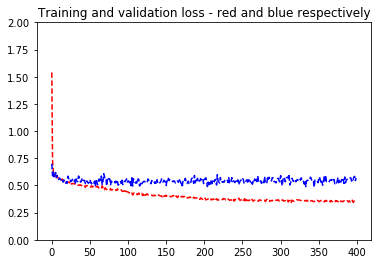

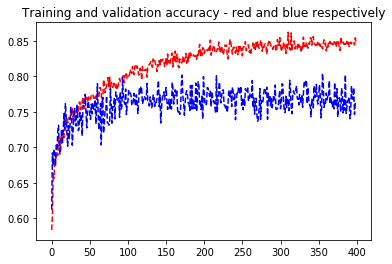

done


In [11]:
saved_dir = '../saved/IMPRS_hdf5_sumproj_mask/0702_200625'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [12]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    #classes = ('endothelium', 'pct', 'vasculature')
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 2:
                m = torch.nn.Softmax(dim=0)
                print("prediction percentages")
                print(m(output.cpu()[0]))
                print(all_true[i])
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [13]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


Tesla K80


  0%|          | 0/7 [00:00<?, ?it/s]/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 57%|█████▋    | 4/7 [00:00<00:00,  6.26it/s]

prediction percentages
tensor([0.1714, 0.8286])
0
prediction percentages
tensor([0.7121, 0.2879])
0


100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


num test images = 418
loss = 0.5983
my_metric = 0.7321
f1 = 0.7759
balanced_accuracy = 0.7216
precision = 0.8528
recall = 0.7321
My_metric is accuracy
Confusion matrix, without normalization
[[ 94  41]
 [ 71 212]]


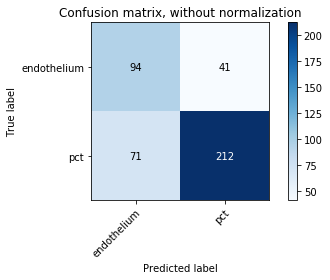

In [14]:
#Test
main2(config, resume)
